In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import collections
import struct

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

In [2]:
TMFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / GreedyBytes,
)

In [3]:
frame_size = 1113
frames = np.fromfile('orx_frames.u8', dtype='uint8').reshape(-1, frame_size)
frames.shape

(2073, 1113)

# AOS frames

Frames are AOS frames using spacecraft ID [0x40](https://sanaregistry.org/r/spacecraftid/records/14049). Virtual channels 0 and 63 (OID) are in use.

In [4]:
tm = [TMFrame.parse(f) for f in frames]
scid = [a.primary_header.spacecraft_id for a in tm]
vcid = np.array([a.primary_header.virtual_channel_id for a in tm])
vcfc = np.array([a.primary_header.virtual_channel_frame_count for a in tm])
[a.primary_header for a in tm[:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=64, virtual_channel_id=0, virtual_channel_frame_count=1644345, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=64, virtual_channel_id=63, virtual_channel_frame_count=5918496, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=64, virtual_channel_id=63, virtual_channel_frame_count=5918497, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=64, virtual_channel_id=63, virtual_channel_frame_count=5918498, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=64, virtual_channel_id=63, virtual_channel_frame_count=5918499, replay_flag=False, vc_frame_cou

In [5]:
collections.Counter(scid)

Counter({64: 2073})

In [6]:
collections.Counter(vcid)

Counter({63: 1195, 0: 878})

In [7]:
np.average(vcid != 63)

0.42354076218041486

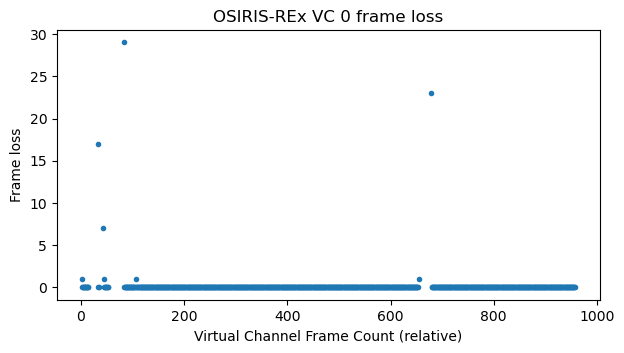

In [8]:
plt.plot(vcfc[vcid == 0][1:] - vcfc[vcid == 0][0], np.diff(vcfc[vcid == 0]) - 1, '.')
plt.title('OSIRIS-REx VC 0 frame loss')
plt.xlabel('Virtual Channel Frame Count (relative)')
plt.ylabel('Frame loss');

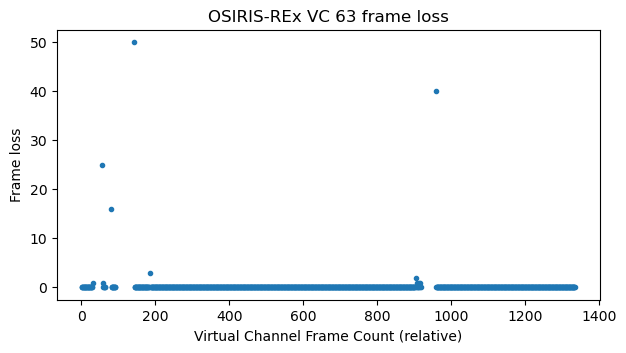

In [9]:
plt.plot(vcfc[vcid == 63][1:] - vcfc[vcid == 63][0], np.diff(vcfc[vcid == 63]) - 1, '.')
plt.title('OSIRIS-REx VC 63 frame loss')
plt.xlabel('Virtual Channel Frame Count (relative)')
plt.ylabel('Frame loss');

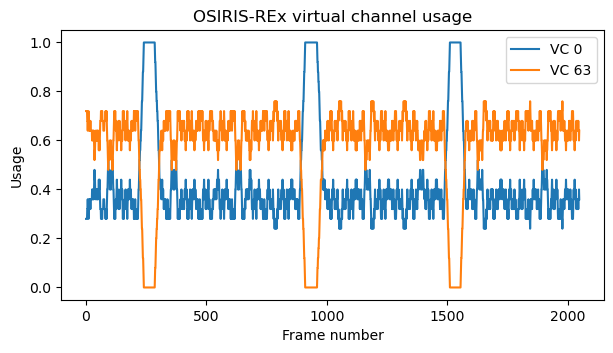

In [10]:
navg = 25
for v in [0, 63]:
    plt.plot(np.convolve(vcid == v, np.ones(navg)/navg, mode='valid'), label=f'VC {v}')
plt.legend()
plt.title('OSIRIS-REx virtual channel usage')
plt.xlabel('Frame number')
plt.ylabel('Usage');

# VC 0

Virtual channel 0 carries Space Packets. All the packets have a 5 byte secondary header containing a timestamp. The timestamp gives the number of 1/256 second units elapsed since the J2000 epoch. APIDs 3, 4, 5, 6, and 2047 (idle) are in use. The non-idle APIDs carry data in a key-value format. The length of the values is implicit per key. Idle packets are filled with `0x55` bytes.

Apparently there is a glitch in the M_PDU of one of the frames. In frame with VCFC 1644628 the last packet is an idle packet that should continue on the next frame. There is an idle AOS frame between this frame and the next, VCFC 1644629, which has the first header pointer set to zero, so the last part of the idle packet is missing.

The length of the Space Packets seems limited to 2048 bytes (including the header).

In [11]:
packets = list(ccsds.extract_space_packets(tm[510:513], 0x40, 0))

/home/daniel/contracting/orx/ccsds.py:58: UserWarning: Space Packet has incorrect size. Expected 11 has 6
  warnings.warn(f'Space Packet has incorrect size. Expected {expected} has {len(packet)}')


In [12]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=5, sequence_flags=3, packet_sequence_count_or_name=4510, data_length=182),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=6, sequence_flags=3, packet_sequence_count_or_name=8728, data_length=280),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=3, sequence_flags=3, packet_sequence_count_or_name=13276, data_length=124),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=0, packet_sequence_count_or_name=3664, data_length=967)]

In [13]:
tm[510:513]

[Container(primary_header=Container(transfer_frame_version_number=1, spacecraft_id=64, virtual_channel_id=0, virtual_channel_frame_count=1644628, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0), m_pdu_header=Container(rsv_spare=0, first_header_pointer=623), m_pdu_packet_zone=b'\xda\x04\xd8\xb0\xdb\x05+\xb0\xdc\x04;\xb0\xdd\x04\xaa\xb0\xde\x05T\xb0\xdf\x04\xce\xb0\xe0\x05\x0e\xb0\xe1\x04\xef\xb0\xe2\x02\x1d\xb0\xe3\x05 \xb0\xe4\x05\x90\xb0\xe5\x04\xc8\xb0\xe6\x05D\xb0\xe7\x04\xd8\xb0\xe8\x05y\xb0\xe9\x05!\xb0\xea\x05~\xb0\xeb\x052\xb0\xec\x05H\xb0\xed\x05;\xb0\xee\x05*\xb0\xef\x05P\xb0\xf0\x057\xb0\xf1\x05_\xb0\xf2\x05.\xb0\xf3\x05}\xb0\xf4\x05#\xb0\xf5\x05%\xb0\xf6\x05\xa1\xb0\xf7\x05N\xb0\xf8\x05E\xb0\xf9\x05\x7f\xb0\xfa\x05W\xb0\xfb\x05Y\xb0\xfc\x05D\xb0\xfd\x05U\xb0\xfe\x05Y\xb0\xff\x05\x1c\xb1\x00\x05I\xb1\x01\x05\'\xb1\x02\x05*\xb1\x03\x058\xb1\x04\x051\xb1\x05\x05\xfc\xb1\x06\x02\t\xb1\x07\x02\x9d\xb1\x18\n+\xb1\x19\ta\xb1\x1a\tn\xb1\x1b\t

In [14]:
ccsds.SpacePacketPrimaryHeader.parse(tm[510].m_pdu_packet_zone[623+7+182+7+280:])

Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=0, packet_sequence_count_or_name=3663, data_length=4)

In [15]:
len(tm[510].m_pdu_packet_zone[623+7+182+7+280:])

6

In [16]:
packets = list(ccsds.extract_space_packets(tm, 0x40, 0))

/home/daniel/contracting/orx/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 64 VC 0] Broken stream. Last frame count 1644345, current frame count 1644347
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/orx/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 64 VC 0] Broken stream. Last frame count 1644360, current frame count 1644378
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/orx/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 64 VC 0] Broken stream. Last frame count 1644380, current frame count 1644388
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame

In [17]:
max([len(p) for p in packets])

2048

In [18]:
headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]
apids = collections.Counter([p.APID for p in headers])
apids

Counter({6: 558, 2047: 556, 3: 464, 4: 139, 5: 101})

In [19]:
by_apid = {apid: [p for p, h in zip(packets, headers) if h.APID == apid]
           for apid in apids}

In [20]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in by_apid[2047]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=0, packet_sequence_count_or_name=3484, data_length=686),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=0, packet_sequence_count_or_name=3486, data_length=963),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=0, packet_sequence_count_or_name=3487, data_length=865),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=0, packet_sequence_count_or_name=3488, data_length=469),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=0, packet_sequence_count_or_name=3489, data_length=805),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=2047, sequence_flags=0, packet_sequence_count_or_name=3490, data_length=728),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=

In [21]:
all([np.all(np.frombuffer(p[6+5:], 'uint8') == 0x55) for p in by_apid[2047]])

True

In [22]:
sec_headers = np.array([np.frombuffer(p[6:6+5], 'uint8') for p in packets])
timestamps = (sec_headers[:, 0] * 2**32 + sec_headers[:, -4:].view('uint32').byteswap().ravel()) / 256
timestamps[-1] - timestamps[0]

513.58984375

In [23]:
np.datetime64('2023-09-24T14:35:47.139944') - np.timedelta64(1, 'ns') * (1e9 * timestamps[0])

numpy.datetime64('2000-01-01T11:59:58.542287808')

In [24]:
# *____SCLK0_______  ____SCET0____________ _DUT__ _SCLKRATE___
# 0744187124.000    2023-213T18:40:28.544 69.184 01.000000492
#
# from https://naif.jpl.nasa.gov/pub/naif/ORX/kernels/sclk/ORX_SCLKSCET.00092.tsc
packet_timestamps = np.datetime64('2023-08-01T18:40:28.544') + np.timedelta64(1, 'ns') * (1e9 * (timestamps - 744187124))
packet_timestamps[0]

numpy.datetime64('2023-09-24T14:37:33.141656250')

In [25]:
{apid: collections.Counter([len(p) for p in by_apid[apid]])
 for apid in apids}

{3: Counter({131: 405, 135: 59}),
 6: Counter({191: 65,
          227: 56,
          239: 35,
          233: 28,
          185: 28,
          197: 27,
          245: 24,
          221: 22,
          281: 21,
          251: 19,
          203: 14,
          287: 12,
          2045: 12,
          2048: 12,
          275: 11,
          225: 11,
          257: 11,
          263: 8,
          293: 7,
          269: 6,
          2043: 6,
          2044: 6,
          2027: 6,
          2039: 6,
          2041: 6,
          2046: 6,
          2047: 6,
          2040: 6,
          231: 5,
          291: 4,
          1973: 3,
          2033: 3,
          1979: 3,
          2015: 3,
          2009: 3,
          2042: 3,
          2018: 3,
          1011: 3,
          237: 3,
          285: 3,
          299: 3,
          199: 3,
          209: 3,
          248: 3,
          297: 2,
          247: 2,
          279: 2,
          273: 2,
          200: 2,
          194: 2,
          253: 2,
          

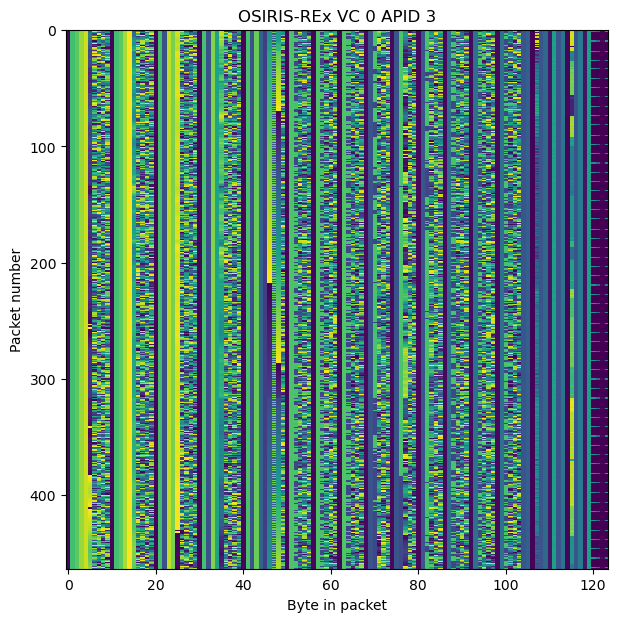

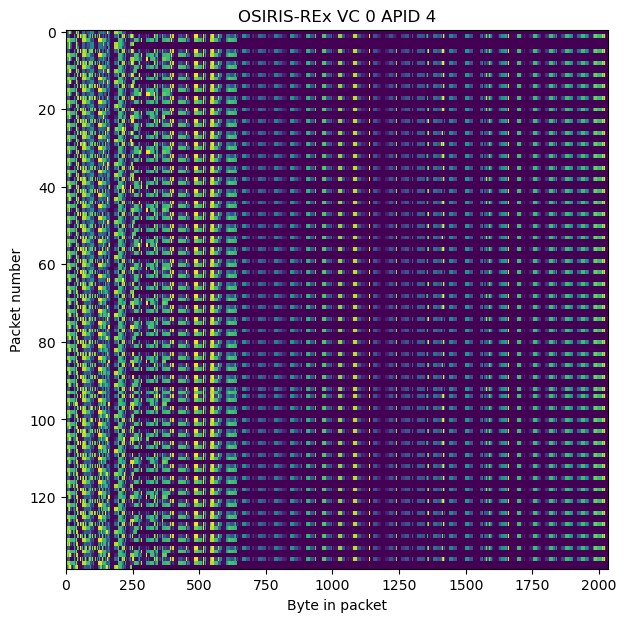

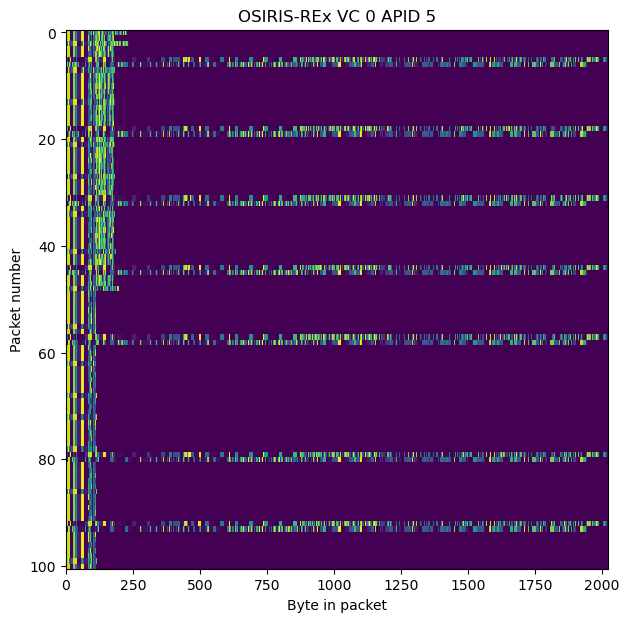

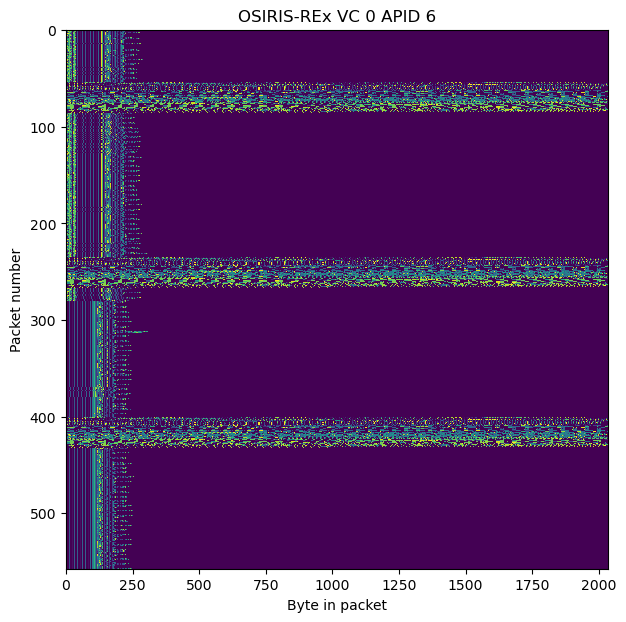

In [26]:
apid_array = {}
for apid in sorted(apids):
    if apid == 2047:
        continue
    ps = [np.frombuffer(p[6+5:], 'uint8') for p in by_apid[apid]]
    ml = max([len(p) for p in ps])
    plt.figure(figsize=(7, 7))
    apid_array[apid] = np.array([np.concatenate((p, np.zeros(ml - len(p), 'uint8'))) for p in ps])
    plt.imshow(apid_array[apid], aspect='auto', interpolation='none')
    plt.title(f'OSIRIS-REx VC 0 APID {apid}')
    plt.xlabel('Byte in packet')
    plt.ylabel('Packet number')

In [27]:
Tavg_s = 10
Tavg = Tavg_s * np.timedelta64(1, 's')
boundaries = packet_timestamps[0] + Tavg * np.arange(int(np.ceil((packet_timestamps[-1] - packet_timestamps[0])/Tavg)))

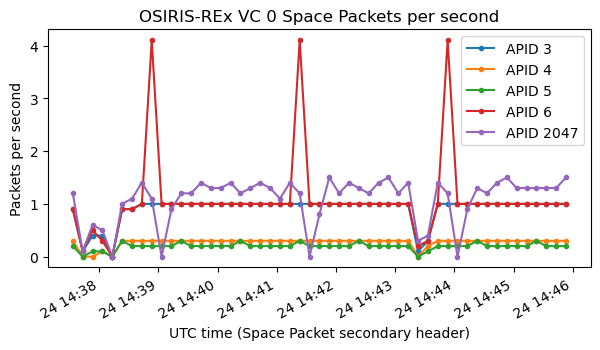

In [28]:
for apid in sorted(apids):
    packets_per_second = [sum([1 / Tavg_s for t, h in zip(packet_timestamps, headers)
                               if h.APID == apid and boundaries[j] <= t < boundaries[j+1]])
                          for j in range(len(boundaries)-1)]
    plt.plot(boundaries[:-1], packets_per_second, '.-', label=f'APID {apid}')
    plt.legend()
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx VC 0 Space Packets per second')
plt.ylabel('Packets per second')
plt.xlabel('UTC time (Space Packet secondary header)');

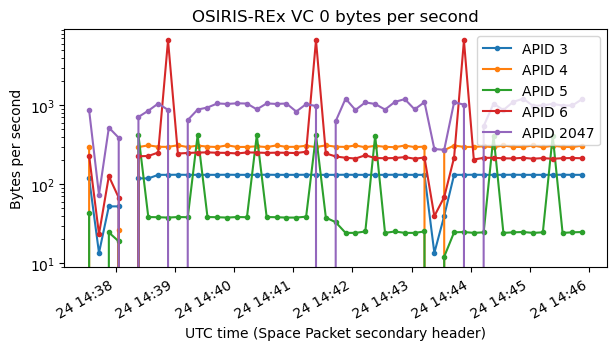

In [29]:
for apid in sorted(apids):
    bytes_per_second = [sum([len(p)/Tavg_s for p, t, h in zip(packets, packet_timestamps, headers)
                               if h.APID == apid and boundaries[j] <= t < boundaries[j+1]])
                          for j in range(len(boundaries)-1)]
    plt.semilogy(boundaries[:-1], bytes_per_second, '.-', label=f'APID {apid}')
    plt.legend()
plt.gcf().autofmt_xdate()
plt.ylabel('Bytes per second')
plt.title('OSIRIS-REx VC 0 bytes per second')
plt.xlabel('UTC time (Space Packet secondary header)');

# Key value format

In [30]:
keys = {4*256+156: 2, 4*256+216: 1, 4*256+217: 2,
        5*256+49: 1, 5*256+67: 2, 5*256+117: 1, 5*256+118: 4, 5*256+119: 8,
        5*256+120: 4, 5*256+121: 1, 5*256+122: 4, 5*256+123: 8, 5*256+124: 4,
        5*256+125: 8, 5*256+157: 1, 5*256+163: 8, 5*256+166: 1, 5*256+165: 4,
        5*256+169: 4, 5*256+179: 8, 5*256+228: 4,
        6*256+68: 1, 6*256+151: 8, 6*256+154: 2, 6*256+155: 1,
        6*256+164: 2, 6*256+195: 2, 6*256+196: 4,
        6*256+206: 2, 6*256+212: 2, 6*256+220: 1, 6*256+225: 4, 6*256+226: 1, 6*256+255: 1,
        7*256+9: 1, 7*256+14: 8, 7*256+15: 1, 7*256+17: 1, 7*256+18: 1,
        7*256+19: 4, 7*256+21: 8, 7*256+22: 1, 7*256+23: 1, 7*256+24: 4,
        7*256+25: 4, 7*256+26: 4, 7*256+27: 1, 7*256+28: 4, 7*256+30: 4,
        7*256+31: 8, 7*256+32: 4, 7*256+33: 4, 7*256+34: 1, 7*256+35: 8,
        7*256+36: 1, 7*256+37: 1, 7*256+38: 1, 7*256+39: 1, 7*256+42: 4, 
        7*256+43: 8, 7*256+45: 4, 7*256+46: 4, 7*256+47: 1, 7*256+48: 1,
        7*256+49: 4, 7*256+50: 4, 7*256+51: 4, 7*256+52: 1, 7*256+54: 8,
        7*256+55: 1, 7*256+56: 1, 7*256+58: 4, 7*256+59: 4, 7*256+69: 4,
        7*256+70: 4, 7*256+107: 1, 7*256+141: 4, 7*256+142: 1, 7*256+144: 1,
        7*256+145: 1, 7*256+146: 4, 7*256+147: 4, 7*256+148: 4, 7*256+149: 1,
        7*256+150: 1, 7*256+151: 4, 7*256+152: 4, 7*256+153: 8, 7*256+154: 4,
        7*256+155: 4, 7*256+156: 1, 7*256+157: 1, 7*256+158: 4, 7*256+161: 1,
        7*256+167: 4, 7*256+176: 1, 7*256+167: 4, 7*256+176: 1, 7*256+177: 4,
        7*256+190: 1, 7*256+191: 4, 7*256+192: 4, 7*256+196: 4, 7*256+201: 4,
        7*256+202: 8, 7*256+203: 1, 7*256+204: 4,
        7*256+230: 8,
        8*256+0: 1, 8*256+1: 1, 8*256+17: 1, 8*256+23: 1, 8*256+29: 1,
        8*256+35: 1, 8*256+41: 1, 8*256+45: 1, 8*256+49: 1, 8*256+54: 1,
        8*256+60: 1, 8*256+66: 1, 8*256+81: 2,
        8*256+18: 4, 8*256+19: 2, 8*256+20: 4, 8*256+25: 2, 8*256+26: 4,
        8*256+31: 2, 8*256+32: 4, 8*256+37: 2, 8*256+38: 4,
        8*256+56: 2, 8*256+57: 4, 8*256+62: 2, 8*256+63: 4,
        8*256+101: 8,
        10*256+2: 1,
        11*256+95: 1,
        12*256+109: 1,
        13*256+137: 4,
        34*256+114: 2, 34*256+154: 2, 34*256+194: 2, 34*256+234: 2,
        35*256+111: 4, 35*256+129: 4, 35*256+130: 1, 35*256+232: 2,
        36*256+76: 2, 36*256+77: 4, 36*256+78: 8, 36*256+82: 4,
        36*256+83: 2, 36*256+84: 8, 36*256+88: 4, 36*256+89: 2, 36*256+90: 8, 36*256+93: 1,
        36*256+189: 1, 36*256+198: 4, 36*256+210: 1, 36*256+219: 4, 36*256+242: 4,
        36*256+243: 4,
        37*256+220: 2, 37*256+244: 4,
        38*256+38: 2, 38*256+92: 2, 38*256+103: 2, 38*256+114: 4,
        39*256+25: 2, 39*256+26: 4, 39*256+28: 4, 39*256+29: 2, 39*256+30: 4, 39*256+31: 4,
        39*256+33: 4, 39*256+34: 8, 39*256+37: 4, 39*256+38: 8, 39*256+40: 4, 39*256+42: 4,
        39*256+43: 2, 39*256+44: 4, 39*256+46: 4, 39*256+47: 2, 39*256+48: 2, 39*256+49: 2, 39*256+50: 2,
        39*256+67: 4, 39*256+68: 4, 39*256+69: 1,
        39*256+76: 4, 39*256+80: 4, 39*256+93: 4,
        39*256+97: 4, 39*256+212: 4, 39*256+216: 4,
        40*256+149: 4,
        55*256+121: 4, 55*256+131: 4,
        64*256+112: 2, 64*256+119: 2, 64*256+122: 2, 64*256+127:2, 64*256+138: 2,
        64*256+147: 2,
        65*256+206: 2,
        66*256+123: 2, 66*256+163: 2, 66*256+203: 2, 66*256+243: 2,
        67*256+27: 2, 67*256+67: 2, 67*256+99: 2,
        68*256+17: 2, 68*256+19: 2, 68*256+37: 2, 68*256+39: 2, 68*256+54: 2, 68*256+55: 4, 68*256+56: 2,
        68*256+68: 4, 68*256+70: 4, 68*256+119: 4, 68*256+121: 4, 68*256+131: 4, 
        68*256+135: 4, 68*256+141: 4, 68*256+145: 4,
        69*256+37: 1, 69*256+52: 1, 69*256+67: 1, 69*256+82: 1, 69*256+97: 1, 69*256+137: 1, 69*256+152: 1,
        69*256+167: 1, 69*256+182: 1, 69*256+197: 1,
        76*256+34: 2,
        129*256+63: 2, 129*256+72: 2,
        130*256+7: 2, 130*256+16: 2,
        131*256+233: 2, 131*256+235: 2, 131*256+242: 1, 131*256+252: 1,
        132*256+79: 2, 132*256+80: 2, 132*256+85: 2, 132*256+88: 2, 132*256+89: 2, 132*256+95: 2, 132*256+96: 2,
        161*256+211: 4,
        176*256+50: 2, 176*256+57: 2, 176*256+59: 2, 176*256+103: 2, 176*256+120: 2, 176*256+126: 2, 176*256+133: 2,
        177*256+58: 2,
        178*256+2: 2, 178*256+100: 2, 178*256+115: 2, 178*256+140: 2, 178*256+155: 2, 178*256+180: 2,
        178*256+195: 2, 178*256+220: 2, 178*256+235: 2,
        179*256+4: 2, 179*256+19: 2, 179*256+44: 2, 179*256+59: 2,}
for j in range(19, 27):
    keys[j] = 4
for j in range(27, 34):
    keys[j] = 2
for j in range(47, 57):
    keys[j] = 4
for j in range(59, 63):
    keys[256+j] = 2
for j in range(73, 76):
    keys[256+j] = 2
for j in range(3, 7):
    keys[2*256+j] = 2
for j in range(17, 20):
    keys[2*256+j] = 2
for j in range(233, 256):
    keys[3*256+j] = 2
for j in range(177):
    keys[4*256+j] = 2
for j in range(178, 184):
    keys[4*256+j] = 8
for j in range(184, 187):
    keys[4*256+j] = 4
for j in range(187, 195):
    keys[4*256+j] = 8
for j in range(195, 197):
    keys[4*256+j] = 4
for j in range(197, 207):
    keys[4*256+j] = 8
for j in range(208, 211):
    keys[4*256+j] = 1
for j in range(212, 215):
    keys[4*256+j] = 4
for j in range(219, 256):
    keys[4*256+j] = 4
for j in range(1, 4):
    keys[5*256+j] = 4
for j in range(5, 8):
    keys[5*256+j] = 1
for j in range(10, 12):
    keys[5*256+j] = 2
for j in range(13, 20):
    keys[5*256+j] = 4
for j in range(21, 25):
    keys[5*256+j] = 4
for j in range(26, 30):
    keys[5*256+j] = 1
for j in range(35, 39):
    keys[5*256+j] = 4
for j in range(40, 44):
    keys[5*256+j] = 2
for j in range(45, 49):
    keys[5*256+j] = 2
for j in range(51, 54):
    keys[5*256+j] = 4
for j in range(63, 67):
    keys[5*256+j] = 2
for j in range(71, 115):
    keys[5*256+j] = 4
for j in range(127, 133):
    keys[5*256+j] = 4
for j in range(137, 139):
    keys[5*256+j] = 1
for j in range(140, 144):
    keys[5*256+j] = 4
for j in range(149, 157):
    keys[5*256+j] = 4
for j in range(174, 178):
    keys[5*256+j] = 8
for j in range(197, 224):
    keys[5*256+j] = 4
for j in range(225, 227):
    keys[5*256+j] = 4
for j in range(231, 234):
    keys[5*256+j] = 4
for j in range(235, 239):
    keys[5*256+j] = 1
for j in range(239, 248):
    keys[5*256+j] = 4
for j in range(249, 256):
    keys[5*256+j] = 4
for j in range(0, 29):
    keys[6*256+j] = 4
for j in range(33, 47):
    keys[6*256+j] = 4
for j in range(53, 57):
    keys[6*256+j] = 4
for j in range(60, 68):
    keys[6*256+j] = 4
for j in range(70, 97):
    keys[6*256+j] = 4
for j in range(98, 111):
    keys[6*256+j] = 4
for j in range(114, 117):
    keys[6*256+j] = 4
for j in range(123, 126):
    keys[6*256+j] = 4
for j in range(127, 130):
    keys[6*256+j] = 2
for j in range(131, 136):
    keys[6*256+j] = 8
for j in range(137, 140):
    keys[6*256+j] = 4
for j in range(140, 142):
    keys[6*256+j] = 8
for j in range(142, 151):
    keys[6*256+j] = 4
for j in range(152, 154):
    keys[6*256+j] = 4
for j in range(157, 160):
    keys[6*256+j] = 2
for j in range(160, 164):
    keys[6*256+j] = 4
for j in range(166, 171):
    keys[6*256+j] = 8
for j in range(172, 175):
    keys[6*256+j] = 2
for j in range(176, 179):
    keys[6*256+j] = 4
for j in range(180, 183):
    keys[6*256+j] = 2
for j in range(184, 187):
    keys[6*256+j] = 4
for j in range(187, 195):
    keys[6*256+j] = 2
for j in range(197, 208):
    keys[6*256+j] = 2
for j in range(209, 220):
    keys[6*256+j] = 2
for j in range(221, 225):
    keys[6*256+j] = 2
for j in range(228, 255):
    keys[6*256+j] = 1
for j in range(0, 8):
    keys[7*256+j] = 1
for j in range(10, 14):
    keys[7*256+j] = 4
for j in range(72, 105):
    keys[7*256+j] = 2
for j in range(72, 105):
    keys[7*256+j] = 2
for j in range(109, 125):
    keys[7*256+j] = 1
for j in range(129, 131):
    keys[7*256+j] = 1
for j in range(131, 136):
    keys[7*256+j] = 4
for j in range(169, 176):
    keys[7*256+j] = 4
for j in range(198, 201):
    keys[7*256+j] = 1
for j in range(209, 213):
    keys[7*256+j] = 1
for j in range(215, 219):
    keys[7*256+j] = 4
for j in range(221, 226):
    keys[7*256+j] = 1
for j in range(227, 230):
    keys[7*256+j] = 4
for j in range(233, 240):
    keys[7*256+j] = 1
for j in range(253, 256):
    keys[7*256+j] = 1
for j in range(9, 16):
    keys[8*256+j] = 1
for j in range(21, 25):
    keys[8*256+j] = 4
for j in range(27, 31):
    keys[8*256+j] = 4
for j in range(33, 37):
    keys[8*256+j] = 4
for j in range(39, 56):
    keys[8*256+j] = 4
for j in range(58, 62):
    keys[8*256+j] = 4
for j in range(64, 69):
    keys[8*256+j] = 4
for j in range(70, 74):
    keys[8*256+j] = 2
for j in range(82, 101):
    keys[8*256+j] = 2
for j in range(103, 105):
    keys[8*256+j] = 4
for j in range(107, 109):
    keys[8*256+j] = 4
for j in range(110, 113):
    keys[8*256+j] = 4
for j in range(114, 117):
    keys[8*256+j] = 4
for j in range(118, 121):
    keys[8*256+j] = 4
for j in range(122, 125):
    keys[8*256+j] = 4
for j in range(126, 129):
    keys[8*256+j] = 4
for j in range(130, 133):
    keys[8*256+j] = 4
for j in range(186, 191):
    keys[8*256+j] = 4
for j in range(190, 200):
    keys[8*256+j] = 1
for j in range(201, 204):
    keys[8*256+j] = 4
for j in range(205, 208):
    keys[8*256+j] = 4
for j in range(209, 225):
    keys[8*256+j] = 4
for j in range(226, 242):
    keys[8*256+j] = 4
for j in range(243, 256):
    keys[8*256+j] = 4
for j in range(0, 3):
    keys[9*256+j] = 4
for j in range(4, 20):
    keys[9*256+j] = 4
for j in range(21, 37):
    keys[9*256+j] = 4
for j in range(38, 54):
    keys[9*256+j] = 4
for j in range(55, 71):
    keys[9*256+j] = 4
for j in range(72, 88):
    keys[9*256+j] = 4
for j in range(89, 105):
    keys[9*256+j] = 4
for j in range(106, 122):
    keys[9*256+j] = 4
for j in range(123, 139):
    keys[9*256+j] = 4
for j in range(140, 156):
    keys[9*256+j] = 4
for j in range(157, 173):
    keys[9*256+j] = 4
for j in range(174, 190):
    keys[9*256+j] = 4
for j in range(191, 207):
    keys[9*256+j] = 4
for j in range(208, 224):
    keys[9*256+j] = 4
for j in range(225, 241):
    keys[9*256+j] = 4
for j in range(242, 256):
    keys[9*256+j] = 4
for j in range(0, 2):
    keys[10*256+j] = 4
for j in range(4, 7):
    keys[10*256+j] = 4
for j in range(8, 11):
    keys[10*256+j] = 4
for j in range(12, 15):
    keys[10*256+j] = 4
for j in range(16, 19):
    keys[10*256+j] = 4
for j in range(20, 23):
    keys[10*256+j] = 4
for j in range(24, 27):
    keys[10*256+j] = 4
for j in range(28, 31):
    keys[10*256+j] = 4
for j in range(32, 35):
    keys[10*256+j] = 4
for j in range(43, 47):
    keys[10*256+j] = 4
for j in range(47, 51):
    keys[10*256+j] = 8
for j in range(52, 55):
    keys[10*256+j] = 4
for j in range(56, 59):
    keys[10*256+j] = 4
for j in range(60, 63):
    keys[10*256+j] = 1
for j in range(67, 83):
    keys[10*256+j] = 4
for j in range(84, 88):
    keys[10*256+j] = 1
for j in range(90, 92):
    keys[10*256+j] = 1
for j in range(93, 96):
    keys[10*256+j] = 4
for j in range(97, 100):
    keys[10*256+j] = 4
for j in range(101, 104):
    keys[10*256+j] = 4
for j in range(105, 108):
    keys[10*256+j] = 4
for j in range(109, 112):
    keys[10*256+j] = 4
for j in range(113, 116):
    keys[10*256+j] = 4
for j in range(117, 120):
    keys[10*256+j] = 4
for j in range(121, 124):
    keys[10*256+j] = 4
for j in range(132, 136):
    keys[10*256+j] = 4
for j in range(136, 140):
    keys[10*256+j] = 8
for j in range(141, 144):
    keys[10*256+j] = 4
for j in range(145, 148):
    keys[10*256+j] = 4
for j in range(149, 152):
    keys[10*256+j] = 1
for j in range(153, 157):
    keys[10*256+j] = 1
for j in range(159, 160):
    keys[10*256+j] = 1
for j in range(75, 93):
    keys[11*256+j] = 4
for j in range(156, 172):
    keys[11*256+j] = 4
for j in range(172, 175):
    keys[11*256+j] = 4
for j in range(175, 179):
    keys[11*256+j] = 1
for j in range(180, 186):
    keys[11*256+j] = 4
for j in range(121, 123):
    keys[13*256+j] = 1
for j in range(216, 219):
    keys[13*256+j] = 2
for j in range(221, 224):
    keys[13*256+j] = 2
for j in range(225, 228):
    keys[13*256+j] = 2
for j in range(44, 58):
    keys[33*256+j] = 2
for j in range(76, 79):
    keys[33*256+j] = 2
for j in range(85, 90):
    keys[33*256+j] = 2
for j in range(244, 256):
    keys[33*256+j] = 2
for j in range(0, 2):
    keys[34*256+j] = 2
for j in range(20, 22):
    keys[34*256+j] = 2
for j in range(29, 31):
    keys[34*256+j] = 2
for j in range(112, 117):
    keys[35*256+j] = 1
for j in range(117, 124):
    keys[35*256+j] = 4
for j in range(124, 127):
    keys[35*256+j] = 1
for j in range(131, 228):
    keys[35*256+j] = 4
for j in range(240, 243):
    keys[35*256+j] = 4
for j in range(244, 256):
    keys[35*256+j] = 4
for j in range(0, 1):
    keys[36*256+j] = 4
for j in range(8, 76):
    keys[36*256+j] = 4
for j in range(106, 114):
    keys[36*256+j] = 4
for j in range(156, 157):
    keys[36*256+j] = 4
for j in range(178, 179):
    keys[36*256+j] = 4
for j in range(181, 189):
    keys[36*256+j] = 4
for j in range(190, 198):
    keys[36*256+j] = 4
for j in range(199, 201):
    keys[36*256+j] = 4
for j in range(204, 210):
    keys[36*256+j] = 4
for j in range(211, 219):
    keys[36*256+j] = 4
for j in range(220, 222):
    keys[36*256+j] = 4
for j in range(223, 224):
    keys[36*256+j] = 4
for j in range(238, 241):
    keys[36*256+j] = 4
for j in range(244, 255):
    keys[36*256+j] = 4
for j in range(20, 28):
    keys[37*256+j] = 4
for j in range(108, 110):
    keys[37*256+j] = 4
for j in range(155, 160):
    keys[37*256+j] = 4
for j in range(161, 162):
    keys[37*256+j] = 4
for j in range(163, 169):
    keys[37*256+j] = 4
for j in range(184, 187):
    keys[37*256+j] = 4
for j in range(188, 191):
    keys[37*256+j] = 2
for j in range(191, 198):
    keys[37*256+j] = 4
for j in range(221, 234):
    keys[37*256+j] = 4
for j in range(237, 250):
    keys[37*256+j] = 4
for j in range(250, 251):
    keys[37*256+j] = 2
for j in range(252, 256):
    keys[37*256+j] = 2
for j in range(0, 29):
    keys[38*256+j] = 2
for j in range(29, 38):
    keys[38*256+j] = 4
for j in range(41, 44):
    keys[38*256+j] = 4
for j in range(66, 73):
    keys[38*256+j] = 4
for j in range(74, 79):
    keys[38*256+j] = 4
for j in range(80, 84):
    keys[38*256+j] = 4
for j in range(85, 92):
    keys[38*256+j] = 4
for j in range(93, 96):
    keys[38*256+j] = 4
for j in range(97, 103):
    keys[38*256+j] = 4
for j in range(104, 125):
    keys[38*256+j] = 4
for j in range(21, 23):
    keys[39*256+j] = 4
for j in range(24, 25):
    keys[39*256+j] = 4
for j in range(70, 82):
    keys[39*256+j] = 4
for j in range(84, 86):
    keys[39*256+j] = 4
for j in range(86, 87):
    keys[39*256+j] = 1
for j in range(87, 98):
    keys[39*256+j] = 4
for j in range(98, 100):
    keys[39*256+j] = 2
for j in range(100, 103):
    keys[39*256+j] = 1
for j in range(105, 106):
    keys[39*256+j] = 4
for j in range(107, 117):
    keys[39*256+j] = 2
for j in range(124, 134):
    keys[39*256+j] = 2
for j in range(141, 151):
    keys[39*256+j] = 2
for j in range(175, 185):
    keys[39*256+j] = 2
for j in range(192, 204):
    keys[39*256+j] = 4
for j in range(207, 208):
    keys[39*256+j] = 4
for j in range(209, 221):
    keys[39*256+j] = 4
for j in range(224, 236):
    keys[39*256+j] = 4
for j in range(239, 251):
    keys[39*256+j] = 4
for j in range(11, 21):
    keys[40*256+j] = 2
for j in range(28, 40):
    keys[40*256+j] = 4
for j in range(52, 58):
    keys[40*256+j] = 4
for j in range(68, 92):
    keys[40*256+j] = 4
for j in range(132, 150):
    keys[40*256+j] = 4
for j in range(156, 192):
    keys[40*256+j] = 4
for j in range(196, 202):
    keys[40*256+j] = 4
for j in range(214, 215):
    keys[40*256+j] = 4
for j in range(217, 228):
    keys[40*256+j] = 4
for j in range(229, 239):
    keys[40*256+j] = 4
for j in range(252, 256):
    keys[40*256+j] = 4
for j in range(0, 32):
    keys[41*256+j] = 4
for j in range(96, 106):
    keys[41*256+j] = 4
for j in range(108, 111):
    keys[41*256+j] = 4
for j in range(112, 115):
    keys[41*256+j] = 4
for j in range(118, 121):
    keys[41*256+j] = 4
for j in range(122, 125):
    keys[41*256+j] = 4
for j in range(127, 130):
    keys[41*256+j] = 2
for j in range(137, 140):
    keys[41*256+j] = 2
for j in range(146, 148):
    keys[41*256+j] = 4
for j in range(148, 149):
    keys[41*256+j] = 1
for j in range(149, 153):
    keys[41*256+j] = 4
for j in range(197, 205):
    keys[41*256+j] = 1
for j in range(207, 215):
    keys[41*256+j] = 1
for j in range(40, 41):
    keys[42*256+j] = 1
for j in range(42, 45):
    keys[42*256+j] = 2
for j in range(45, 46):
    keys[42*256+j] = 1
for j in range(47, 50):
    keys[42*256+j] = 2
for j in range(51, 54):
    keys[42*256+j] = 2
for j in range(55, 58):
    keys[42*256+j] = 2
for j in range(58, 59):
    keys[42*256+j] = 4
for j in range(60, 63):
    keys[42*256+j] = 2
for j in range(63, 64):
    keys[42*256+j] = 4
for j in range(65, 68):
    keys[42*256+j] = 2
for j in range(68, 69):
    keys[42*256+j] = 1
for j in range(69, 71):
    keys[42*256+j] = 2
for j in range(71, 72):
    keys[42*256+j] = 1
for j in range(72, 74):
    keys[42*256+j] = 2
for j in range(74, 75):
    keys[42*256+j] = 1
for j in range(75, 76):
    keys[42*256+j] = 2
for j in range(77, 78):
    keys[42*256+j] = 1
for j in range(78, 79):
    keys[42*256+j] = 2
for j in range(98, 99):
    keys[42*256+j] = 1
for j in range(99, 100):
    keys[42*256+j] = 2
for j in range(101, 102):
    keys[42*256+j] = 1
for j in range(102, 103):
    keys[42*256+j] = 2
for j in range(110, 111):
    keys[42*256+j] = 1
for j in range(111, 112):
    keys[42*256+j] = 2
for j in range(113, 114):
    keys[42*256+j] = 1
for j in range(114, 115):
    keys[42*256+j] = 2
for j in range(116, 117):
    keys[42*256+j] = 1
for j in range(118, 121):
    keys[42*256+j] = 2
for j in range(122, 124):
    keys[42*256+j] = 2
for j in range(184, 256):
    keys[43*256+j] = 4
for j in range(0, 132):
    keys[44*256+j] = 4
for j in range(250, 256):
    keys[47*256+j] = 2
for j in range(31, 39):
    keys[48*256+j] = 4
for j in range(41, 49):
    keys[48*256+j] = 4
for j in range(51, 59):
    keys[48*256+j] = 4
for j in range(61, 69):
    keys[48*256+j] = 4
for j in range(71, 79):
    keys[48*256+j] = 4
for j in range(81, 89):
    keys[48*256+j] = 4
for j in range(91, 99):
    keys[48*256+j] = 4
for j in range(101, 109):
    keys[48*256+j] = 4
for j in range(111, 119):
    keys[48*256+j] = 4
for j in range(121, 129):
    keys[48*256+j] = 4
for j in range(131, 139):
    keys[48*256+j] = 4
for j in range(141, 149):
    keys[48*256+j] = 4
for j in range(151, 159):
    keys[48*256+j] = 4
for j in range(161, 169):
    keys[48*256+j] = 4
for j in range(171, 179):
    keys[48*256+j] = 4
for j in range(181, 189):
    keys[48*256+j] = 4
for j in range(191, 199):
    keys[48*256+j] = 4
for j in range(201, 209):
    keys[48*256+j] = 4
for j in range(211, 219):
    keys[48*256+j] = 4
for j in range(221, 229):
    keys[48*256+j] = 4
for j in range(231, 239):
    keys[48*256+j] = 4
for j in range(241, 249):
    keys[48*256+j] = 4
for j in range(251, 256):
    keys[48*256+j] = 4
for j in range(0, 3):
    keys[49*256+j] = 4
for j in range(5, 13):
    keys[49*256+j] = 4
for j in range(15, 23):
    keys[49*256+j] = 4
for j in range(25, 33):
    keys[49*256+j] = 4
for j in range(35, 43):
    keys[49*256+j] = 4
for j in range(45, 53):
    keys[49*256+j] = 4
for j in range(55, 63):
    keys[49*256+j] = 4
for j in range(65, 73):
    keys[49*256+j] = 4
for j in range(75, 83):
    keys[49*256+j] = 4
for j in range(85, 93):
    keys[49*256+j] = 4
for j in range(95, 103):
    keys[49*256+j] = 4
for j in range(105, 113):
    keys[49*256+j] = 4
for j in range(115, 123):
    keys[49*256+j] = 4
for j in range(125, 133):
    keys[49*256+j] = 4
for j in range(135, 143):
    keys[49*256+j] = 4
for j in range(145, 153):
    keys[49*256+j] = 4
for j in range(155, 163,):
    keys[49*256+j] = 4
for j in range(165, 173):
    keys[49*256+j] = 4
for j in range(175, 183):
    keys[49*256+j] = 4
for j in range(185, 193):
    keys[49*256+j] = 4
for j in range(195, 203):
    keys[49*256+j] = 4
for j in range(205, 213):
    keys[49*256+j] = 4
for j in range(215, 223):
    keys[49*256+j] = 4
for j in range(225, 233):
    keys[49*256+j] = 4
for j in range(235, 243):
    keys[49*256+j] = 4
for j in range(245, 253):
    keys[49*256+j] = 4
for j in range(255, 256):
    keys[49*256+j] = 4
for j in range(0, 7):
    keys[50*256+j] = 4
for j in range(9, 17):
    keys[50*256+j] = 4
for j in range(19, 27):
    keys[50*256+j] = 4
for j in range(29, 37):
    keys[50*256+j] = 4
for j in range(39, 47):
    keys[50*256+j] = 4
for j in range(49, 57):
    keys[50*256+j] = 4
for j in range(59, 67):
    keys[50*256+j] = 4
for j in range(69, 77):
    keys[50*256+j] = 4
for j in range(79, 87):
    keys[50*256+j] = 4
for j in range(89, 97):
    keys[50*256+j] = 4
for j in range(99, 107):
    keys[50*256+j] = 4
for j in range(109, 117):
    keys[50*256+j] = 4
for j in range(119, 127):
    keys[50*256+j] = 4
for j in range(129, 137):
    keys[50*256+j] = 4
for j in range(139, 147):
    keys[50*256+j] = 4
for j in range(149, 157):
    keys[50*256+j] = 4
for j in range(159, 167):
    keys[50*256+j] = 4
for j in range(169, 177):
    keys[50*256+j] = 4
for j in range(179, 187):
    keys[50*256+j] = 4
for j in range(189, 197):
    keys[50*256+j] = 4
for j in range(199, 207):
    keys[50*256+j] = 4
for j in range(199, 207):
    keys[50*256+j] = 4
for j in range(209, 217):
    keys[50*256+j] = 4
for j in range(219, 227):
    keys[50*256+j] = 4
for j in range(229, 237):
    keys[50*256+j] = 4
for j in range(239, 247):
    keys[50*256+j] = 4
for j in range(249, 256):
    keys[50*256+j] = 4
for j in range(0, 1):
    keys[51*256+j] = 4
for j in range(3, 11):
    keys[51*256+j] = 4
for j in range(13, 21):
    keys[51*256+j] = 4
for j in range(23, 31):
    keys[51*256+j] = 4
for j in range(33, 41):
    keys[51*256+j] = 4
for j in range(43, 51):
    keys[51*256+j] = 4
for j in range(53, 61):
    keys[51*256+j] = 4
for j in range(63, 71):
    keys[51*256+j] = 4
for j in range(73, 81):
    keys[51*256+j] = 4
for j in range(83, 91):
    keys[51*256+j] = 4
for j in range(93, 101):
    keys[51*256+j] = 4
for j in range(103, 111):
    keys[51*256+j] = 4
for j in range(113, 121):
    keys[51*256+j] = 4
for j in range(123, 131):
    keys[51*256+j] = 4
for j in range(133, 141):
    keys[51*256+j] = 4
for j in range(143, 151):
    keys[51*256+j] = 4
for j in range(153, 161):
    keys[51*256+j] = 4
for j in range(163, 171):
    keys[51*256+j] = 4
for j in range(173, 181):
    keys[51*256+j] = 4
for j in range(183, 191):
    keys[51*256+j] = 4
for j in range(193, 201):
    keys[51*256+j] = 4
for j in range(203, 211):
    keys[51*256+j] = 4
for j in range(213, 221):
    keys[51*256+j] = 4
for j in range(223, 231):
    keys[51*256+j] = 4
for j in range(233, 241):
    keys[51*256+j] = 4
for j in range(243, 251):
    keys[51*256+j] = 4
for j in range(253, 256):
    keys[51*256+j] = 4
for j in range(0, 5):
    keys[52*256+j] = 4
for j in range(7, 15):
    keys[52*256+j] = 4
for j in range(17, 25):
    keys[52*256+j] = 4
for j in range(27, 35):
    keys[52*256+j] = 4
for j in range(37, 45):
    keys[52*256+j] = 4
for j in range(47, 55):
    keys[52*256+j] = 4
for j in range(57, 65):
    keys[52*256+j] = 4
for j in range(77, 79):
    keys[52*256+j] = 4
for j in range(79, 82):
    keys[52*256+j] = 1
for j in range(82, 90):
    keys[52*256+j] = 4
for j in range(90, 93):
    keys[52*256+j] = 4
for j in range(93, 94):
    keys[52*256+j] = 1
for j in range(94, 95):
    keys[52*256+j] = 4
for j in range(97, 99):
    keys[52*256+j] = 4
for j in range(99, 102):
    keys[52*256+j] = 1
for j in range(102, 113):
    keys[52*256+j] = 4
for j in range(113, 114):
    keys[52*256+j] = 1
for j in range(114, 115):
    keys[52*256+j] = 4
for j in range(117, 119):
    keys[52*256+j] = 4
for j in range(119, 122):
    keys[52*256+j] = 1
for j in range(122, 133):
    keys[52*256+j] = 4
for j in range(133, 134):
    keys[52*256+j] = 1
for j in range(134, 135):
    keys[52*256+j] = 4
for j in range(137, 139):
    keys[52*256+j] = 4
for j in range(139, 142):
    keys[52*256+j] = 1
for j in range(142, 153):
    keys[52*256+j] = 4
for j in range(153, 154):
    keys[52*256+j] = 1
for j in range(154, 155):
    keys[52*256+j] = 4
for j in range(157, 159):
    keys[52*256+j] = 4
for j in range(159, 162):
    keys[52*256+j] = 1
for j in range(162, 173):
    keys[52*256+j] = 4
for j in range(173, 174):
    keys[52*256+j] = 1
for j in range(174, 175):
    keys[52*256+j] = 4
for j in range(177, 180):
    keys[52*256+j] = 4
for j in range(181, 182):
    keys[52*256+j] = 1
for j in range(182, 193):
    keys[52*256+j] = 4
for j in range(193, 194):
    keys[52*256+j] = 1
for j in range(194, 195):
    keys[52*256+j] = 4
for j in range(197, 199):
    keys[52*256+j] = 4
for j in range(199, 202):
    keys[52*256+j] = 1
for j in range(202, 213):
    keys[52*256+j] = 4
for j in range(213, 214):
    keys[52*256+j] = 1
for j in range(214, 215):
    keys[52*256+j] = 4
for j in range(217, 219):
    keys[52*256+j] = 4
for j in range(219, 222):
    keys[52*256+j] = 1
for j in range(222, 233):
    keys[52*256+j] = 4
for j in range(233, 234):
    keys[52*256+j] = 1
for j in range(234, 235):
    keys[52*256+j] = 4
for j in range(237, 239):
    keys[52*256+j] = 4
for j in range(239, 242):
    keys[52*256+j] = 1
for j in range(242, 253):
    keys[52*256+j] = 4
for j in range(253, 254):
    keys[52*256+j] = 1
for j in range(254, 255):
    keys[52*256+j] = 4
for j in range(1, 3):
    keys[53*256+j] = 4
for j in range(3, 6):
    keys[53*256+j] = 1
for j in range(6, 17):
    keys[53*256+j] = 4
for j in range(17, 18):
    keys[53*256+j] = 1
for j in range(18, 19):
    keys[53*256+j] = 4
for j in range(21, 23):
    keys[53*256+j] = 4
for j in range(23, 24):
    keys[53*256+j] = 4
for j in range(24, 25):
    keys[53*256+j] = 1
for j in range(25, 26):
    keys[53*256+j] = 4
for j in range(26, 37):
    keys[53*256+j] = 4
for j in range(37, 38):
    keys[53*256+j] = 1
for j in range(38, 39):
    keys[53*256+j] = 4
for j in range(41, 43):
    keys[53*256+j] = 4
for j in range(43, 46):
    keys[53*256+j] = 1
for j in range(46, 57):
    keys[53*256+j] = 4
for j in range(57, 58):
    keys[53*256+j] = 1
for j in range(58, 59):
    keys[53*256+j] = 4
for j in range(61, 63):
    keys[53*256+j] = 4
for j in range(63, 66):
    keys[53*256+j] = 1
for j in range(66, 77):
    keys[53*256+j] = 4
for j in range(77, 78):
    keys[53*256+j] = 1
for j in range(78, 79):
    keys[53*256+j] = 4
for j in range(81, 83):
    keys[53*256+j] = 4
for j in range(83, 86):
    keys[53*256+j] = 1
for j in range(86, 97):
    keys[53*256+j] = 4
for j in range(97, 98):
    keys[53*256+j] = 1
for j in range(98, 99):
    keys[53*256+j] = 4
for j in range(108, 109):
    keys[53*256+j] = 2
for j in range(108, 109):
    keys[55*256+j] = 2
for j in range(109, 116):
    keys[55*256+j] = 4
for j in range(116, 121):
    keys[55*256+j] = 1
for j in range(122, 125):
    keys[55*256+j] = 1
for j in range(125, 132):
    keys[55*256+j] = 4
for j in range(133, 134):
    keys[55*256+j] = 4
for j in range(138, 142):
    keys[55*256+j] = 2
for j in range(158, 159):
    keys[55*256+j] = 4
for j in range(168, 169):
    keys[55*256+j] = 4
for j in range(179, 183):
    keys[55*256+j] = 4
for j in range(189, 193):
    keys[55*256+j] = 4
for j in range(209, 212):
    keys[55*256+j] = 2
for j in range(213, 216):
    keys[55*256+j] = 2
for j in range(52, 57):
    keys[64*256+j] = 2
for j in range(61, 63):
    keys[64*256+j] = 2
for j in range(88, 94):
    keys[64*256+j] = 2
for j in range(100, 103):
    keys[64*256+j] = 2
for j in range(104, 108):
    keys[64*256+j] = 2
for j in range(109, 115):
    keys[64*256+j] = 2
for j in range(127, 131):
    keys[64*256+j] = 2
for j in range(132, 144):
    keys[64*256+j] = 2
for j in range(6, 8):
    keys[65*256+j] = 2
for j in range(64, 72):
    keys[65*256+j] = 2
for j in range(8, 16):
    keys[66*256+j] = 2
for j in range(88, 100):
    keys[66*256+j] = 2
for j in range(101, 104):
    keys[66*256+j] = 2
for j in range(108, 114):
    keys[66*256+j] = 2
for j in range(116, 119):
    keys[66*256+j] = 2
for j in range(116, 119):
    keys[66*256+j] = 2
for j in range(128, 140):
    keys[66*256+j] = 2
for j in range(141, 144):
    keys[66*256+j] = 2
for j in range(148, 154):
    keys[66*256+j] = 2
for j in range(156, 159):
    keys[66*256+j] = 2
for j in range(168, 180):
    keys[66*256+j] = 2
for j in range(181, 184):
    keys[66*256+j] = 2
for j in range(188, 194):
    keys[66*256+j] = 2
for j in range(196, 199):
    keys[66*256+j] = 2
for j in range(208, 220):
    keys[66*256+j] = 2
for j in range(221, 224):
    keys[66*256+j] = 2
for j in range(228, 234):
    keys[66*256+j] = 2
for j in range(236, 239):
    keys[66*256+j] = 2
for j in range(248, 256):
    keys[66*256+j] = 2
for j in range(0, 4):
    keys[67*256+j] = 2
for j in range(5, 8):
    keys[67*256+j] = 2
for j in range(12, 19):
    keys[67*256+j] = 2
for j in range(20, 23):
    keys[67*256+j] = 2
for j in range(32, 44):
    keys[67*256+j] = 2
for j in range(45, 48):
    keys[67*256+j] = 2
for j in range(52, 59):
    keys[67*256+j] = 2
for j in range(60, 63):
    keys[67*256+j] = 2
for j in range(72, 80):
    keys[67*256+j] = 2
for j in range(80, 87):
    keys[67*256+j] = 2
for j in range(92, 99):
    keys[67*256+j] = 2
for j in range(100, 107):
    keys[67*256+j] = 2
for j in range(112, 128):
    keys[67*256+j] = 2
for j in range(132, 148):
    keys[67*256+j] = 2
for j in range(232, 235):
    keys[67*256+j] = 1
for j in range(242, 243):
    keys[67*256+j] = 4
for j in range(243, 244):
    keys[67*256+j] = 2
for j in range(244, 245):
    keys[67*256+j] = 4
for j in range(245, 248):
    keys[67*256+j] = 2
for j in range(248, 249):
    keys[67*256+j] = 1
for j in range(252, 253):
    keys[67*256+j] = 4
for j in range(253, 254):
    keys[67*256+j] = 2
for j in range(254, 255):
    keys[67*256+j] = 4
for j in range(255, 256):
    keys[67*256+j] = 2
for j in range(0, 2):
    keys[68*256+j] = 2
for j in range(2, 3):
    keys[68*256+j] = 1
for j in range(6, 7):
    keys[68*256+j] = 4
for j in range(7, 8):
    keys[68*256+j] = 2
for j in range(8, 9):
    keys[68*256+j] = 4
for j in range(9, 12):
    keys[68*256+j] = 2
for j in range(12, 13):
    keys[68*256+j] = 1
for j in range(16, 17):
    keys[68*256+j] = 4
for j in range(17, 18):
    keys[68*256+j] = 2
for j in range(18, 19):
    keys[68*256+j] = 4
for j in range(19, 22):
    keys[68*256+j] = 2
for j in range(22, 23):
    keys[68*256+j] = 1
for j in range(23, 24):
    keys[68*256+j] = 1
for j in range(26, 27):
    keys[68*256+j] = 4
for j in range(27, 28):
    keys[68*256+j] = 2
for j in range(28, 29):
    keys[68*256+j] = 4
for j in range(29, 32):
    keys[68*256+j] = 2
for j in range(32, 34):
    keys[68*256+j] = 1
for j in range(36, 37):
    keys[68*256+j] = 4
for j in range(37, 38):
    keys[68*256+j] = 2
for j in range(38, 39):
    keys[68*256+j] = 4
for j in range(39, 42):
    keys[68*256+j] = 2
for j in range(42, 43):
    keys[68*256+j] = 1
for j in range(45, 46):
    keys[68*256+j] = 1
for j in range(47, 53):
    keys[68*256+j] = 2
for j in range(58, 59):
    keys[68*256+j] = 2
for j in range(59, 60):
    keys[68*256+j] = 4
for j in range(60, 61):
    keys[68*256+j] = 2
for j in range(67, 68):
    keys[68*256+j] = 1
for j in range(76, 84):
    keys[68*256+j] = 1
for j in range(85, 88):
    keys[68*256+j] = 1
for j in range(89, 93):
    keys[68*256+j] = 1
for j in range(94, 97):
    keys[68*256+j] = 1
for j in range(98, 99):
    keys[68*256+j] = 1
for j in range(100, 103):
    keys[68*256+j] = 1
for j in range(104, 105):
    keys[68*256+j] = 1
for j in range(106, 110):
    keys[68*256+j] = 1
for j in range(123, 124):
    keys[68*256+j] = 1
for j in range(129, 131):
    keys[68*256+j] = 1
for j in range(132, 135):
    keys[68*256+j] = 1
for j in range(139, 141):
    keys[68*256+j] = 1
for j in range(142, 145):
    keys[68*256+j] = 1
for j in range(176, 187):
    keys[68*256+j] = 2
for j in range(20, 37):
    keys[69*256+j] = 2
for j in range(38, 52):
    keys[69*256+j] = 2
for j in range(53, 67):
    keys[69*256+j] = 2
for j in range(68, 82):
    keys[69*256+j] = 2
for j in range(83, 97):
    keys[69*256+j] = 2
for j in range(98, 114):
    keys[69*256+j] = 2
for j in range(120, 137):
    keys[69*256+j] = 2
for j in range(138, 152):
    keys[69*256+j] = 2
for j in range(153, 167):
    keys[69*256+j] = 2
for j in range(168, 182):
    keys[69*256+j] = 2
for j in range(183, 197):
    keys[69*256+j] = 2
for j in range(198, 214):
    keys[69*256+j] = 2
for j in range(1, 4):
    keys[80*256+j] = 2
for j in range(5, 8):
    keys[80*256+j] = 2
for j in range(8, 9):
    keys[80*256+j] = 1
for j in range(9, 10):
    keys[80*256+j] = 4
for j in range(11, 14):
    keys[80*256+j] = 2
for j in range(15, 18):
    keys[80*256+j] = 2
for j in range(19, 22):
    keys[80*256+j] = 2
for j in range(22, 23):
    keys[80*256+j] = 1
for j in range(23, 24):
    keys[80*256+j] = 4
for j in range(25, 28):
    keys[80*256+j] = 2
for j in range(29, 32):
    keys[80*256+j] = 2
for j in range(33, 36):
    keys[80*256+j] = 2
for j in range(36, 37):
    keys[80*256+j] = 1
for j in range(37, 38):
    keys[80*256+j] = 4
for j in range(39, 42):
    keys[80*256+j] = 2
for j in range(43, 46):
    keys[80*256+j] = 2
for j in range(47, 50):
    keys[80*256+j] = 2
for j in range(50, 51):
    keys[80*256+j] = 1
for j in range(51, 52):
    keys[80*256+j] = 4
for j in range(53, 56):
    keys[80*256+j] = 2
for j in range(57, 60):
    keys[80*256+j] = 2
for j in range(61, 64):
    keys[80*256+j] = 2
for j in range(65, 68):
    keys[80*256+j] = 2
for j in range(68, 69):
    keys[80*256+j] = 1
for j in range(69, 70):
    keys[80*256+j] = 4
for j in range(71, 74):
    keys[80*256+j] = 2
for j in range(74, 75):
    keys[80*256+j] = 1
for j in range(75, 76):
    keys[80*256+j] = 4
for j in range(77, 80):
    keys[80*256+j] = 2
for j in range(80, 81):
    keys[80*256+j] = 1
for j in range(81, 82):
    keys[80*256+j] = 4
for j in range(83, 86):
    keys[80*256+j] = 2
for j in range(86, 87):
    keys[80*256+j] = 1
for j in range(87, 88):
    keys[80*256+j] = 4
for j in range(89, 92):
    keys[80*256+j] = 2
for j in range(92, 93):
    keys[80*256+j] = 1
for j in range(93, 94):
    keys[80*256+j] = 4
for j in range(95, 98):
    keys[80*256+j] = 2
for j in range(98, 99):
    keys[80*256+j] = 1
for j in range(99, 100):
    keys[80*256+j] = 4
for j in range(101, 104):
    keys[80*256+j] = 2
for j in range(104, 105):
    keys[80*256+j] = 1
for j in range(105, 106):
    keys[80*256+j] = 4
for j in range(107, 110):
    keys[80*256+j] = 2
for j in range(110, 111):
    keys[80*256+j] = 1
for j in range(111, 112):
    keys[80*256+j] = 4
for j in range(113, 116):
    keys[80*256+j] = 2
for j in range(116, 117):
    keys[80*256+j] = 1
for j in range(117, 118):
    keys[80*256+j] = 4
for j in range(119, 122):
    keys[80*256+j] = 2
for j in range(122, 123):
    keys[80*256+j] = 1
for j in range(123, 124):
    keys[80*256+j] = 4
for j in range(125, 128):
    keys[80*256+j] = 2
for j in range(129, 132):
    keys[80*256+j] = 2
for j in range(132, 133):
    keys[80*256+j] = 1
for j in range(133, 134):
    keys[80*256+j] = 4
for j in range(134, 135):
    keys[80*256+j] = 1
for j in range(135, 136):
    keys[80*256+j] = 4
for j in range(137, 140):
    keys[80*256+j] = 2
for j in range(140, 141):
    keys[80*256+j] = 1
for j in range(141, 142):
    keys[80*256+j] = 4
for j in range(143, 146):
    keys[80*256+j] = 2
for j in range(146, 147):
    keys[80*256+j] = 1
for j in range(147, 148):
    keys[80*256+j] = 4
for j in range(149, 152):
    keys[80*256+j] = 2
for j in range(152, 153):
    keys[80*256+j] = 1
for j in range(153, 154):
    keys[80*256+j] = 4
for j in range(155, 158):
    keys[80*256+j] = 2
for j in range(158, 159):
    keys[80*256+j] = 1
for j in range(159, 160):
    keys[80*256+j] = 4
for j in range(161, 164):
    keys[80*256+j] = 2
for j in range(165, 168):
    keys[80*256+j] = 2
for j in range(168, 169):
    keys[80*256+j] = 1
for j in range(169, 170):
    keys[80*256+j] = 4
for j in range(170, 171):
    keys[80*256+j] = 1
for j in range(171, 172):
    keys[80*256+j] = 4
for j in range(173, 176):
    keys[80*256+j] = 2
for j in range(176, 177):
    keys[80*256+j] = 1
for j in range(177, 178):
    keys[80*256+j] = 4
for j in range(179, 182):
    keys[80*256+j] = 2
for j in range(183, 186):
    keys[80*256+j] = 2
for j in range(186, 187):
    keys[80*256+j] = 1
for j in range(187, 188):
    keys[80*256+j] = 4
for j in range(188, 189):
    keys[80*256+j] = 1
for j in range(189, 190):
    keys[80*256+j] = 4
for j in range(191, 194):
    keys[80*256+j] = 2
for j in range(194, 195):
    keys[80*256+j] = 1
for j in range(195, 196):
    keys[80*256+j] = 4
for j in range(197, 200):
    keys[80*256+j] = 2
for j in range(201, 204):
    keys[80*256+j] = 2
for j in range(205, 208):
    keys[80*256+j] = 2
for j in range(209, 212):
    keys[80*256+j] = 2
for j in range(213, 216):
    keys[80*256+j] = 2
for j in range(217, 220):
    keys[80*256+j] = 2
for j in range(221, 224):
    keys[80*256+j] = 2
for j in range(225, 228):
    keys[80*256+j] = 2
for j in range(229, 232):
    keys[80*256+j] = 2
for j in range(233, 236):
    keys[80*256+j] = 2
for j in range(236, 237):
    keys[80*256+j] = 1
for j in range(237, 238):
    keys[80*256+j] = 4
for j in range(239, 242):
    keys[80*256+j] = 2
for j in range(243, 246):
    keys[80*256+j] = 2
for j in range(247, 250):
    keys[80*256+j] = 2
for j in range(250, 251):
    keys[80*256+j] = 1
for j in range(251, 252):
    keys[80*256+j] = 4
for j in range(253, 256):
    keys[80*256+j] = 2
for j in range(0, 1):
    keys[81*256+j] = 1
for j in range(1, 2):
    keys[81*256+j] = 4
for j in range(3, 6):
    keys[81*256+j] = 2
for j in range(6, 7):
    keys[81*256+j] = 1
for j in range(7, 8):
    keys[81*256+j] = 4
for j in range(9, 12):
    keys[81*256+j] = 2
for j in range(12, 13):
    keys[81*256+j] = 1
for j in range(13, 14):
    keys[81*256+j] = 4
for j in range(15, 18):
    keys[81*256+j] = 2
for j in range(18, 19):
    keys[81*256+j] = 1
for j in range(19, 20):
    keys[81*256+j] = 4
for j in range(21, 24):
    keys[81*256+j] = 2
for j in range(24, 25):
    keys[81*256+j] = 1
for j in range(25, 26):
    keys[81*256+j] = 4
for j in range(27, 30):
    keys[81*256+j] = 2
for j in range(30, 31):
    keys[81*256+j] = 1
for j in range(31, 32):
    keys[81*256+j] = 4
for j in range(33, 36):
    keys[81*256+j] = 2
for j in range(37, 40):
    keys[81*256+j] = 2
for j in range(40, 41):
    keys[81*256+j] = 1
for j in range(41, 42):
    keys[81*256+j] = 4
for j in range(42, 43):
    keys[81*256+j] = 1
for j in range(43, 44):
    keys[81*256+j] = 4
for j in range(45, 48):
    keys[81*256+j] = 2
for j in range(49, 52):
    keys[81*256+j] = 2
for j in range(53, 56):
    keys[81*256+j] = 2
for j in range(57, 60):
    keys[81*256+j] = 2
for j in range(60, 61):
    keys[81*256+j] = 1
for j in range(61, 62):
    keys[81*256+j] = 4
for j in range(62, 63):
    keys[81*256+j] = 1
for j in range(63, 64):
    keys[81*256+j] = 4
for j in range(65, 68):
    keys[81*256+j] = 2
for j in range(68, 69):
    keys[81*256+j] = 1
for j in range(69, 70):
    keys[81*256+j] = 4
for j in range(71, 74):
    keys[81*256+j] = 2
for j in range(74, 75):
    keys[81*256+j] = 1
for j in range(75, 76):
    keys[81*256+j] = 4
for j in range(77, 80):
    keys[81*256+j] = 2
for j in range(80, 81):
    keys[81*256+j] = 1
for j in range(81, 82):
    keys[81*256+j] = 4
for j in range(83, 86):
    keys[81*256+j] = 2
for j in range(87, 90):
    keys[81*256+j] = 2
for j in range(91, 94):
    keys[81*256+j] = 2
for j in range(95, 98):
    keys[81*256+j] = 2
for j in range(99, 102):
    keys[81*256+j] = 2
for j in range(103, 106):
    keys[81*256+j] = 2
for j in range(107, 110):
    keys[81*256+j] = 2
for j in range(111, 114):
    keys[81*256+j] = 2
for j in range(115, 118):
    keys[81*256+j] = 2
for j in range(119, 122):
    keys[81*256+j] = 2
for j in range(123, 126):
    keys[81*256+j] = 2
for j in range(127, 130):
    keys[81*256+j] = 2
for j in range(131, 134):
    keys[81*256+j] = 2
for j in range(135, 138):
    keys[81*256+j] = 2
for j in range(139, 142):
    keys[81*256+j] = 2
for j in range(143, 146):
    keys[81*256+j] = 2
for j in range(147, 150):
    keys[81*256+j] = 2
for j in range(151, 154):
    keys[81*256+j] = 2
for j in range(154, 155):
    keys[81*256+j] = 1
for j in range(155, 156):
    keys[81*256+j] = 4
for j in range(157, 160):
    keys[81*256+j] = 2
for j in range(160, 161):
    keys[81*256+j] = 1
for j in range(161, 162):
    keys[81*256+j] = 4
for j in range(163, 166):
    keys[81*256+j] = 2
for j in range(166, 167):
    keys[81*256+j] = 1
for j in range(167, 168):
    keys[81*256+j] = 4
for j in range(169, 172):
    keys[81*256+j] = 2
for j in range(172, 173):
    keys[81*256+j] = 1
for j in range(173, 174):
    keys[81*256+j] = 4
for j in range(175, 178):
    keys[81*256+j] = 2
for j in range(178, 179):
    keys[81*256+j] = 1
for j in range(179, 180):
    keys[81*256+j] = 4
for j in range(181, 184):
    keys[81*256+j] = 2
for j in range(184, 185):
    keys[81*256+j] = 1
for j in range(185, 186):
    keys[81*256+j] = 4
for j in range(187, 190):
    keys[81*256+j] = 2
for j in range(190, 191):
    keys[81*256+j] = 1
for j in range(191, 192):
    keys[81*256+j] = 4
for j in range(193, 196):
    keys[81*256+j] = 2
for j in range(196, 197):
    keys[81*256+j] = 1
for j in range(197, 198):
    keys[81*256+j] = 4
for j in range(199, 202):
    keys[81*256+j] = 2
for j in range(202, 203):
    keys[81*256+j] = 1
for j in range(203, 204):
    keys[81*256+j] = 4
for j in range(205, 208):
    keys[81*256+j] = 2
for j in range(208, 209):
    keys[81*256+j] = 1
for j in range(209, 210):
    keys[81*256+j] = 4
for j in range(211, 214):
    keys[81*256+j] = 2
for j in range(214, 215):
    keys[81*256+j] = 1
for j in range(215, 216):
    keys[81*256+j] = 4
for j in range(217, 220):
    keys[81*256+j] = 2
for j in range(220, 221):
    keys[81*256+j] = 1
for j in range(221, 222):
    keys[81*256+j] = 4
for j in range(223, 226):
    keys[81*256+j] = 2
for j in range(227, 230):
    keys[81*256+j] = 2
for j in range(230, 231):
    keys[81*256+j] = 1
for j in range(231, 232):
    keys[81*256+j] = 4
for j in range(232, 233):
    keys[81*256+j] = 1
for j in range(233, 234):
    keys[81*256+j] = 4
for j in range(235, 238):
    keys[81*256+j] = 2
for j in range(238, 239):
    keys[81*256+j] = 1
for j in range(239, 240):
    keys[81*256+j] = 4
for j in range(241, 244):
    keys[81*256+j] = 2
for j in range(244, 245):
    keys[81*256+j] = 1
for j in range(245, 246):
    keys[81*256+j] = 4
for j in range(247, 250):
    keys[81*256+j] = 2
for j in range(250, 251):
    keys[81*256+j] = 1
for j in range(251, 252):
    keys[81*256+j] = 4
for j in range(253, 256):
    keys[81*256+j] = 2
for j in range(0, 1):
    keys[82*256+j] = 1
for j in range(1, 2):
    keys[82*256+j] = 4
for j in range(3, 6):
    keys[82*256+j] = 2
for j in range(6, 7):
    keys[82*256+j] = 1
for j in range(7, 8):
    keys[82*256+j] = 4
for j in range(9, 12):
    keys[82*256+j] = 2
for j in range(12, 13):
    keys[82*256+j] = 1
for j in range(13, 14):
    keys[82*256+j] = 4
for j in range(15, 18):
    keys[82*256+j] = 2
for j in range(18, 19):
    keys[82*256+j] = 1
for j in range(19, 20):
    keys[82*256+j] = 4
for j in range(21, 24):
    keys[82*256+j] = 2
for j in range(24, 25):
    keys[82*256+j] = 1
for j in range(25, 26):
    keys[82*256+j] = 4
for j in range(27, 30):
    keys[82*256+j] = 2
for j in range(31, 34):
    keys[82*256+j] = 2
for j in range(35, 38):
    keys[82*256+j] = 2
for j in range(39, 42):
    keys[82*256+j] = 2
for j in range(42, 43):
    keys[82*256+j] = 4
for j in range(44, 47):
    keys[82*256+j] = 2
for j in range(48, 51):
    keys[82*256+j] = 2
for j in range(52, 55):
    keys[82*256+j] = 2
for j in range(55, 57):
    keys[82*256+j] = 1
for j in range(58, 61):
    keys[82*256+j] = 2
for j in range(62, 65):
    keys[82*256+j] = 2
for j in range(66, 70):
    keys[82*256+j] = 4
for j in range(70, 71):
    keys[82*256+j] = 1
for j in range(72, 75):
    keys[82*256+j] = 2
for j in range(75, 76):
    keys[82*256+j] = 1
for j in range(77, 80):
    keys[82*256+j] = 2
for j in range(80, 81):
    keys[82*256+j] = 1
for j in range(82, 85):
    keys[82*256+j] = 2
for j in range(85, 86):
    keys[82*256+j] = 1
for j in range(87, 90):
    keys[82*256+j] = 2
for j in range(91, 94):
    keys[82*256+j] = 2
for j in range(94, 95):
    keys[82*256+j] = 1
for j in range(96, 99):
    keys[82*256+j] = 2
for j in range(100, 103):
    keys[82*256+j] = 2
for j in range(103, 104):
    keys[82*256+j] = 4
for j in range(104, 105):
    keys[82*256+j] = 1
for j in range(106, 109):
    keys[82*256+j] = 2
for j in range(110, 113):
    keys[82*256+j] = 2
for j in range(113, 115):
    keys[82*256+j] = 1
for j in range(116, 119):
    keys[82*256+j] = 2
for j in range(120, 123):
    keys[82*256+j] = 2
for j in range(123, 125):
    keys[82*256+j] = 1
for j in range(126, 129):
    keys[82*256+j] = 2
for j in range(130, 133):
    keys[82*256+j] = 2
for j in range(133, 134):
    keys[82*256+j] = 1
for j in range(135, 138):
    keys[82*256+j] = 2
for j in range(138, 141):
    keys[82*256+j] = 1
for j in range(141, 142):
    keys[82*256+j] = 4
for j in range(143, 146):
    keys[82*256+j] = 2
for j in range(147, 150):
    keys[82*256+j] = 2
for j in range(151, 154):
    keys[82*256+j] = 2
for j in range(154, 155):
    keys[82*256+j] = 4
for j in range(156, 159):
    keys[82*256+j] = 2
for j in range(160, 163):
    keys[82*256+j] = 2
for j in range(164, 167):
    keys[82*256+j] = 2
for j in range(168, 171):
    keys[82*256+j] = 2
for j in range(171, 172):
    keys[82*256+j] = 4
for j in range(173, 176):
    keys[82*256+j] = 2
for j in range(177, 180):
    keys[82*256+j] = 2
for j in range(181, 184):
    keys[82*256+j] = 2
for j in range(185, 188):
    keys[82*256+j] = 2
for j in range(189, 192):
    keys[82*256+j] = 2
for j in range(193, 196):
    keys[82*256+j] = 2
for j in range(197, 200):
    keys[82*256+j] = 2
for j in range(200, 204):
    keys[82*256+j] = 1
for j in range(205, 208):
    keys[82*256+j] = 2
for j in range(209, 212):
    keys[82*256+j] = 2
for j in range(213, 216):
    keys[82*256+j] = 2
for j in range(216, 217):
    keys[82*256+j] = 1
for j in range(218, 221):
    keys[82*256+j] = 2
for j in range(221, 222):
    keys[82*256+j] = 1
for j in range(223, 226):
    keys[82*256+j] = 2
for j in range(227, 230):
    keys[82*256+j] = 2
for j in range(231, 234):
    keys[82*256+j] = 2
for j in range(234, 235):
    keys[82*256+j] = 1
for j in range(236, 239):
    keys[82*256+j] = 2
for j in range(239, 240):
    keys[82*256+j] = 1
for j in range(241, 244):
    keys[82*256+j] = 2
for j in range(245, 248):
    keys[82*256+j] = 2
for j in range(249, 252):
    keys[82*256+j] = 2
for j in range(252, 253):
    keys[82*256+j] = 1
for j in range(254, 256):
    keys[82*256+j] = 2
for j in range(0, 1):
    keys[83*256+j] = 2
for j in range(1, 2):
    keys[83*256+j] = 1
for j in range(3, 6):
    keys[83*256+j] = 2
for j in range(7, 10):
    keys[83*256+j] = 2
for j in range(10, 11):
    keys[83*256+j] = 1
for j in range(12, 15):
    keys[83*256+j] = 2
for j in range(16, 19):
    keys[83*256+j] = 2
for j in range(19, 20):
    keys[83*256+j] = 1
for j in range(21, 24):
    keys[83*256+j] = 2
for j in range(24, 25):
    keys[83*256+j] = 1
for j in range(26, 29):
    keys[83*256+j] = 2
for j in range(30, 33):
    keys[83*256+j] = 2
for j in range(33, 34):
    keys[83*256+j] = 1
for j in range(35, 38):
    keys[83*256+j] = 2
for j in range(38, 39):
    keys[83*256+j] = 1
for j in range(40, 43):
    keys[83*256+j] = 2
for j in range(44, 47):
    keys[83*256+j] = 2
for j in range(47, 48):
    keys[83*256+j] = 1
for j in range(49, 52):
    keys[83*256+j] = 2
for j in range(53, 55):
    keys[83*256+j] = 2
for j in range(55, 56):
    keys[83*256+j] = 1
for j in range(56, 57):
    keys[83*256+j] = 4
for j in range(58, 61):
    keys[83*256+j] = 2
for j in range(62, 66):
    keys[83*256+j] = 2
for j in range(67, 70):
    keys[83*256+j] = 2
for j in range(71, 74):
    keys[83*256+j] = 2
for j in range(74, 75):
    keys[83*256+j] = 1
for j in range(76, 79):
    keys[83*256+j] = 2
for j in range(80, 83):
    keys[83*256+j] = 2
for j in range(83, 84):
    keys[83*256+j] = 4
for j in range(85, 88):
    keys[83*256+j] = 2
for j in range(88, 89):
    keys[83*256+j] = 1
for j in range(90, 93):
    keys[83*256+j] = 2
for j in range(94, 97):
    keys[83*256+j] = 2
for j in range(97, 98):
    keys[83*256+j] = 4
for j in range(99, 102):
    keys[83*256+j] = 2
for j in range(102, 103):
    keys[83*256+j] = 1
for j in range(104, 107):
    keys[83*256+j] = 2
for j in range(108, 111):
    keys[83*256+j] = 2
for j in range(111, 112):
    keys[83*256+j] = 4
for j in range(113, 116):
    keys[83*256+j] = 2
for j in range(116, 117):
    keys[83*256+j] = 1
for j in range(118, 121):
    keys[83*256+j] = 2
for j in range(122, 125):
    keys[83*256+j] = 2
for j in range(125, 126):
    keys[83*256+j] = 4
for j in range(127, 130):
    keys[83*256+j] = 2
for j in range(131, 134):
    keys[83*256+j] = 2
for j in range(134, 135):
    keys[83*256+j] = 1
for j in range(136, 139):
    keys[83*256+j] = 2
for j in range(139, 140):
    keys[83*256+j] = 1
for j in range(141, 144):
    keys[83*256+j] = 2
for j in range(145, 148):
    keys[83*256+j] = 2
for j in range(149, 152):
    keys[83*256+j] = 2
for j in range(152, 153):
    keys[83*256+j] = 1
for j in range(154, 157):
    keys[83*256+j] = 2
for j in range(158, 161):
    keys[83*256+j] = 2
for j in range(162, 165):
    keys[83*256+j] = 2
for j in range(165, 166):
    keys[83*256+j] = 4
for j in range(166, 167):
    keys[83*256+j] = 1
for j in range(168, 171):
    keys[83*256+j] = 2
for j in range(172, 175):
    keys[83*256+j] = 2
for j in range(175, 176):
    keys[83*256+j] = 4
for j in range(177, 180):
    keys[83*256+j] = 2
for j in range(181, 184):
    keys[83*256+j] = 2
for j in range(185, 188):
    keys[83*256+j] = 2
for j in range(189, 192):
    keys[83*256+j] = 2
for j in range(192, 195):
    keys[83*256+j] = 1
for j in range(195, 196):
    keys[83*256+j] = 4
for j in range(197, 200):
    keys[83*256+j] = 2
for j in range(200, 201):
    keys[83*256+j] = 1
for j in range(201, 202):
    keys[83*256+j] = 4
for j in range(202, 203):
    keys[83*256+j] = 1
for j in range(204, 207):
    keys[83*256+j] = 2
for j in range(208, 211):
    keys[83*256+j] = 2
for j in range(212, 215):
    keys[83*256+j] = 2
for j in range(215, 218):
    keys[83*256+j] = 2
for j in range(218, 219):
    keys[83*256+j] = 1
for j in range(220, 223):
    keys[83*256+j] = 2
for j in range(224, 227):
    keys[83*256+j] = 2
for j in range(229, 232):
    keys[83*256+j] = 2
for j in range(232, 233):
    keys[83*256+j] = 1
for j in range(233, 234):
    keys[83*256+j] = 4
for j in range(235, 238):
    keys[83*256+j] = 2
for j in range(238, 239):
    keys[83*256+j] = 1
for j in range(239, 240):
    keys[83*256+j] = 4
for j in range(241, 244):
    keys[83*256+j] = 2
for j in range(244, 245):
    keys[83*256+j] = 1
for j in range(245, 246):
    keys[83*256+j] = 4
for j in range(247, 250):
    keys[83*256+j] = 2
for j in range(250, 251):
    keys[83*256+j] = 1
for j in range(251, 252):
    keys[83*256+j] = 4
for j in range(253, 256):
    keys[83*256+j] = 2
for j in range(0, 1):
    keys[84*256+j] = 1
for j in range(1, 2):
    keys[84*256+j] = 4
for j in range(3, 6):
    keys[84*256+j] = 2
for j in range(7, 10):
    keys[84*256+j] = 2
for j in range(10, 11):
    keys[84*256+j] = 1
for j in range(11, 12):
    keys[84*256+j] = 4
for j in range(13, 16):
    keys[84*256+j] = 2
for j in range(17, 20):
    keys[84*256+j] = 2
for j in range(20, 22):
    keys[84*256+j] = 4
for j in range(22, 23):
    keys[84*256+j] = 1
for j in range(23, 26):
    keys[84*256+j] = 4
for j in range(26, 27):
    keys[84*256+j] = 1
for j in range(28, 31):
    keys[84*256+j] = 2
for j in range(32, 35):
    keys[84*256+j] = 2
for j in range(35, 37):
    keys[84*256+j] = 1
for j in range(38, 41):
    keys[84*256+j] = 2
for j in range(42, 45):
    keys[84*256+j] = 2
for j in range(45, 46):
    keys[84*256+j] = 1
for j in range(47, 50):
    keys[84*256+j] = 2
for j in range(51, 54):
    keys[84*256+j] = 2
for j in range(55, 58):
    keys[84*256+j] = 2
for j in range(62, 65):
    keys[84*256+j] = 2
for j in range(66, 69):
    keys[84*256+j] = 2
for j in range(70, 73):
    keys[84*256+j] = 2
for j in range(74, 77):
    keys[84*256+j] = 2
for j in range(77, 78):
    keys[84*256+j] = 4
for j in range(79, 82):
    keys[84*256+j] = 2
for j in range(82, 83):
    keys[84*256+j] = 1
for j in range(84, 87):
    keys[84*256+j] = 2
for j in range(88, 91):
    keys[84*256+j] = 2
for j in range(92, 95):
    keys[84*256+j] = 2
for j in range(96, 99):
    keys[84*256+j] = 2
for j in range(99, 100):
    keys[84*256+j] = 1
for j in range(100, 101):
    keys[84*256+j] = 4
for j in range(102, 105):
    keys[84*256+j] = 2
for j in range(106, 109):
    keys[84*256+j] = 2
for j in range(110, 113):
    keys[84*256+j] = 2
for j in range(114, 117):
    keys[84*256+j] = 2
for j in range(118, 121):
    keys[84*256+j] = 2
for j in range(122, 125):
    keys[84*256+j] = 2
for j in range(126, 129):
    keys[84*256+j] = 2
for j in range(129, 131):
    keys[84*256+j] = 4
for j in range(131, 132):
    keys[84*256+j] = 1
for j in range(132, 135):
    keys[84*256+j] = 4
for j in range(135, 136):
    keys[84*256+j] = 1
for j in range(136, 137):
    keys[84*256+j] = 4
for j in range(137, 138):
    keys[84*256+j] = 1
for j in range(138, 139):
    keys[84*256+j] = 4
for j in range(140, 143):
    keys[84*256+j] = 2
for j in range(143, 144):
    keys[84*256+j] = 1
for j in range(144, 145):
    keys[84*256+j] = 4
for j in range(145, 146):
    keys[84*256+j] = 1
for j in range(147, 150):
    keys[84*256+j] = 2
for j in range(150, 151):
    keys[84*256+j] = 4
for j in range(152, 155):
    keys[84*256+j] = 4
for j in range(155, 156):
    keys[84*256+j] = 1
for j in range(157, 160):
    keys[84*256+j] = 2
for j in range(160, 162):
    keys[84*256+j] = 4
for j in range(163, 166):
    keys[84*256+j] = 2
for j in range(166, 168):
    keys[84*256+j] = 4
for j in range(168, 169):
    keys[84*256+j] = 2
for j in range(170, 173):
    keys[84*256+j] = 2
for j in range(173, 176):
    keys[84*256+j] = 1
for j in range(176, 179):
    keys[84*256+j] = 4
for j in range(179, 184):
    keys[84*256+j] = 1
for j in range(184, 190):
    keys[84*256+j] = 2
for j in range(190, 191):
    keys[84*256+j] = 1
for j in range(191, 193):
    keys[84*256+j] = 2
for j in range(193, 194):
    keys[84*256+j] = 4
for j in range(194, 200):
    keys[84*256+j] = 1
for j in range(200, 202):
    keys[84*256+j] = 2
for j in range(202, 206):
    keys[84*256+j] = 1
for j in range(206, 230):
    keys[84*256+j] = 2
for j in range(230, 231):
    keys[84*256+j] = 1
for j in range(232, 242):
    keys[84*256+j] = 2
for j in range(242, 250):
    keys[84*256+j] = 4
for j in range(250, 252):
    keys[84*256+j] = 1
for j in range(252, 253):
    keys[84*256+j] = 4
for j in range(254, 256):
    keys[84*256+j] = 2
for j in range(0, 1):
    keys[85*256+j] = 2
for j in range(1, 2):
    keys[85*256+j] = 1
for j in range(3, 6):
    keys[85*256+j] = 2
for j in range(7, 10):
    keys[85*256+j] = 2
for j in range(11, 14):
    keys[85*256+j] = 2
for j in range(15, 18):
    keys[85*256+j] = 2
for j in range(18, 19):
    keys[85*256+j] = 1
for j in range(19, 20):
    keys[85*256+j] = 4
for j in range(21, 24):
    keys[85*256+j] = 2
for j in range(25, 28):
    keys[85*256+j] = 2
for j in range(28, 29):
    keys[85*256+j] = 4
for j in range(30, 33):
    keys[85*256+j] = 2
for j in range(34, 37):
    keys[85*256+j] = 2
for j in range(38, 41):
    keys[85*256+j] = 2
for j in range(42, 45):
    keys[85*256+j] = 2
for j in range(46, 49):
    keys[85*256+j] = 2
for j in range(50, 53):
    keys[85*256+j] = 2
for j in range(54, 56):
    keys[85*256+j] = 1
for j in range(56, 60):
    keys[85*256+j] = 4
for j in range(61, 64):
    keys[85*256+j] = 2
for j in range(65, 68):
    keys[85*256+j] = 2
for j in range(69, 72):
    keys[85*256+j] = 2
for j in range(73, 76):
    keys[85*256+j] = 2
for j in range(76, 77):
    keys[85*256+j] = 1
for j in range(78, 81):
    keys[85*256+j] = 4
for j in range(81, 82):
    keys[85*256+j] = 1
for j in range(84, 92):
    keys[85*256+j] = 4
for j in range(92, 93):
    keys[85*256+j] = 1
for j in range(93, 95):
    keys[85*256+j] = 4
for j in range(95, 96):
    keys[85*256+j] = 1
for j in range(96, 103):
    keys[85*256+j] = 4
for j in range(103, 106):
    keys[85*256+j] = 2
for j in range(107, 110):
    keys[85*256+j] = 2
for j in range(111, 114):
    keys[85*256+j] = 2
for j in range(115, 118):
    keys[85*256+j] = 2
for j in range(119, 122):
    keys[85*256+j] = 2
for j in range(123, 126):
    keys[85*256+j] = 2
for j in range(127, 130):
    keys[85*256+j] = 2
for j in range(131, 134):
    keys[85*256+j] = 2
for j in range(135, 138):
    keys[85*256+j] = 2
for j in range(138, 141):
    keys[85*256+j] = 4
for j in range(142, 145):
    keys[85*256+j] = 2
for j in range(146, 149):
    keys[85*256+j] = 2
for j in range(150, 153):
    keys[85*256+j] = 2
for j in range(154, 157):
    keys[85*256+j] = 2
for j in range(158, 161):
    keys[85*256+j] = 2
for j in range(162, 165):
    keys[85*256+j] = 2
for j in range(166, 169):
    keys[85*256+j] = 2
for j in range(170, 173):
    keys[85*256+j] = 2
for j in range(174, 177):
    keys[85*256+j] = 2
for j in range(178, 181):
    keys[85*256+j] = 2
for j in range(182, 185):
    keys[85*256+j] = 2
for j in range(186, 189):
    keys[85*256+j] = 2
for j in range(190, 193):
    keys[85*256+j] = 2
for j in range(194, 197):
    keys[85*256+j] = 2
for j in range(198, 201):
    keys[85*256+j] = 2
for j in range(202, 205):
    keys[85*256+j] = 2
for j in range(206, 209):
    keys[85*256+j] = 2
for j in range(210, 213):
    keys[85*256+j] = 2
for j in range(214, 217):
    keys[85*256+j] = 2
for j in range(218, 221):
    keys[85*256+j] = 2
for j in range(222, 225):
    keys[85*256+j] = 2
for j in range(226, 229):
    keys[85*256+j] = 2
for j in range(230, 233):
    keys[85*256+j] = 2
for j in range(233, 236):
    keys[85*256+j] = 4
for j in range(237, 240):
    keys[85*256+j] = 2
for j in range(241, 244):
    keys[85*256+j] = 2
for j in range(245, 248):
    keys[85*256+j] = 2
for j in range(249, 252):
    keys[85*256+j] = 2
for j in range(253, 256):
    keys[85*256+j] = 2
for j in range(1, 4):
    keys[86*256+j] = 2
for j in range(5, 8):
    keys[86*256+j] = 2
for j in range(9, 12):
    keys[86*256+j] = 2
for j in range(13, 16):
    keys[86*256+j] = 2
for j in range(17, 20):
    keys[86*256+j] = 2
for j in range(21, 24):
    keys[86*256+j] = 2
for j in range(25, 28):
    keys[86*256+j] = 2
for j in range(29, 32):
    keys[86*256+j] = 2
for j in range(33, 36):
    keys[86*256+j] = 2
for j in range(37, 40):
    keys[86*256+j] = 2
for j in range(40, 41):
    keys[86*256+j] = 1
for j in range(42, 43):
    keys[86*256+j] = 4
for j in range(43, 44):
    keys[86*256+j] = 1
for j in range(45, 48):
    keys[86*256+j] = 2
for j in range(49, 52):
    keys[86*256+j] = 2
for j in range(53, 56):
    keys[86*256+j] = 2
for j in range(57, 60):
    keys[86*256+j] = 2
for j in range(61, 64):
    keys[86*256+j] = 2
for j in range(69, 72):
    keys[86*256+j] = 2
for j in range(72, 73):
    keys[86*256+j] = 4
for j in range(75, 78):
    keys[86*256+j] = 2
for j in range(79, 82):
    keys[86*256+j] = 2
for j in range(83, 86):
    keys[86*256+j] = 2
for j in range(86, 87):
    keys[86*256+j] = 1
for j in range(87, 88):
    keys[86*256+j] = 4
for j in range(89, 92):
    keys[86*256+j] = 2
for j in range(93, 96):
    keys[86*256+j] = 2
for j in range(97, 100):
    keys[86*256+j] = 2
for j in range(101, 104):
    keys[86*256+j] = 2
for j in range(105, 108):
    keys[86*256+j] = 2
for j in range(109, 112):
    keys[86*256+j] = 2
for j in range(112, 113):
    keys[86*256+j] = 1
for j in range(114, 117):
    keys[86*256+j] = 2
for j in range(118, 121):
    keys[86*256+j] = 2
for j in range(121, 122):
    keys[86*256+j] = 1
for j in range(123, 126):
    keys[86*256+j] = 2
for j in range(127, 130):
    keys[86*256+j] = 2
for j in range(130, 131):
    keys[86*256+j] = 1
for j in range(132, 135):
    keys[86*256+j] = 2
for j in range(136, 139):
    keys[86*256+j] = 2
for j in range(139, 140):
    keys[86*256+j] = 1
for j in range(141, 144):
    keys[86*256+j] = 2
for j in range(145, 148):
    keys[86*256+j] = 2
for j in range(148, 149):
    keys[86*256+j] = 1
for j in range(149, 150):
    keys[86*256+j] = 4
for j in range(151, 154):
    keys[86*256+j] = 2
for j in range(155, 158):
    keys[86*256+j] = 2
for j in range(159, 162):
    keys[86*256+j] = 2
for j in range(162, 163):
    keys[86*256+j] = 1
for j in range(163, 164):
    keys[86*256+j] = 4
for j in range(165, 168):
    keys[86*256+j] = 2
for j in range(169, 172):
    keys[86*256+j] = 2
for j in range(173, 176):
    keys[86*256+j] = 2
for j in range(176, 177):
    keys[86*256+j] = 1
for j in range(177, 178):
    keys[86*256+j] = 4
for j in range(179, 182):
    keys[86*256+j] = 2
for j in range(182, 186):
    keys[86*256+j] = 2
for j in range(187, 190):
    keys[86*256+j] = 2
for j in range(190, 191):
    keys[86*256+j] = 1
for j in range(191, 192):
    keys[86*256+j] = 4
for j in range(193, 196):
    keys[86*256+j] = 2
for j in range(197, 200):
    keys[86*256+j] = 2
for j in range(201, 204):
    keys[86*256+j] = 2
for j in range(204, 205):
    keys[86*256+j] = 1
for j in range(205, 206):
    keys[86*256+j] = 4
for j in range(207, 210):
    keys[86*256+j] = 2
for j in range(211, 214):
    keys[86*256+j] = 2
for j in range(215, 218):
    keys[86*256+j] = 2
for j in range(218, 219):
    keys[86*256+j] = 1
for j in range(219, 220):
    keys[86*256+j] = 4
for j in range(220, 224):
    keys[86*256+j] = 2
for j in range(225, 228):
    keys[86*256+j] = 2
for j in range(229, 232):
    keys[86*256+j] = 2
for j in range(232, 233):
    keys[86*256+j] = 1
for j in range(233, 234):
    keys[86*256+j] = 4
for j in range(235, 238):
    keys[86*256+j] = 2
for j in range(239, 242):
    keys[86*256+j] = 2
for j in range(243, 246):
    keys[86*256+j] = 2
for j in range(246, 247):
    keys[86*256+j] = 1
for j in range(247, 248):
    keys[86*256+j] = 4
for j in range(249, 252):
    keys[86*256+j] = 2
for j in range(253, 256):
    keys[86*256+j] = 2
for j in range(1, 4):
    keys[87*256+j] = 2
for j in range(4, 5):
    keys[87*256+j] = 1
for j in range(5, 6):
    keys[87*256+j] = 4
for j in range(7, 10):
    keys[87*256+j] = 2
for j in range(11, 14):
    keys[87*256+j] = 2
for j in range(15, 18):
    keys[87*256+j] = 2
for j in range(18, 19):
    keys[87*256+j] = 1
for j in range(19, 20):
    keys[87*256+j] = 4
for j in range(21, 24):
    keys[87*256+j] = 2
for j in range(25, 28):
    keys[87*256+j] = 2
for j in range(29, 32):
    keys[87*256+j] = 2
for j in range(32, 33):
    keys[87*256+j] = 1
for j in range(33, 34):
    keys[87*256+j] = 4
for j in range(35, 38):
    keys[87*256+j] = 2
for j in range(39, 42):
    keys[87*256+j] = 2
for j in range(43, 46):
    keys[87*256+j] = 2
for j in range(46, 47):
    keys[87*256+j] = 1
for j in range(47, 48):
    keys[87*256+j] = 4
for j in range(49, 52):
    keys[87*256+j] = 2
for j in range(53, 56):
    keys[87*256+j] = 2
for j in range(57, 60):
    keys[87*256+j] = 2
for j in range(60, 61):
    keys[87*256+j] = 1
for j in range(61, 62):
    keys[87*256+j] = 4
for j in range(63, 66):
    keys[87*256+j] = 2
for j in range(67, 70):
    keys[87*256+j] = 2
for j in range(71, 74):
    keys[87*256+j] = 2
for j in range(74, 75):
    keys[87*256+j] = 1
for j in range(75, 76):
    keys[87*256+j] = 4
for j in range(77, 80):
    keys[87*256+j] = 2
for j in range(81, 84):
    keys[87*256+j] = 2
for j in range(85, 88):
    keys[87*256+j] = 2
for j in range(88, 89):
    keys[87*256+j] = 1
for j in range(89, 90):
    keys[87*256+j] = 4
for j in range(91, 94):
    keys[87*256+j] = 2
for j in range(95, 98):
    keys[87*256+j] = 2
for j in range(99, 102):
    keys[87*256+j] = 2
for j in range(102, 103):
    keys[87*256+j] = 1
for j in range(103, 104):
    keys[87*256+j] = 4
for j in range(105, 108):
    keys[87*256+j] = 2
for j in range(109, 112):
    keys[87*256+j] = 2
for j in range(113, 116):
    keys[87*256+j] = 2
for j in range(116, 117):
    keys[87*256+j] = 1
for j in range(117, 118):
    keys[87*256+j] = 4
for j in range(119, 122):
    keys[87*256+j] = 2
for j in range(123, 126):
    keys[87*256+j] = 2
for j in range(127, 130):
    keys[87*256+j] = 2
for j in range(130, 131):
    keys[87*256+j] = 1
for j in range(131, 132):
    keys[87*256+j] = 4
for j in range(133, 136):
    keys[87*256+j] = 2
for j in range(137, 140):
    keys[87*256+j] = 2
for j in range(141, 144):
    keys[87*256+j] = 2
for j in range(144, 145):
    keys[87*256+j] = 1
for j in range(145, 146):
    keys[87*256+j] = 4
for j in range(147, 150):
    keys[87*256+j] = 2
for j in range(151, 154):
    keys[87*256+j] = 2
for j in range(155, 158):
    keys[87*256+j] = 2
for j in range(158, 159):
    keys[87*256+j] = 1
for j in range(159, 160):
    keys[87*256+j] = 1
for j in range(161, 164):
    keys[87*256+j] = 2
for j in range(165, 168):
    keys[87*256+j] = 2
for j in range(169, 172):
    keys[87*256+j] = 2
for j in range(172, 173):
    keys[87*256+j] = 1
for j in range(173, 174):
    keys[87*256+j] = 1
for j in range(175, 178):
    keys[87*256+j] = 2
for j in range(179, 182):
    keys[87*256+j] = 2
for j in range(183, 186):
    keys[87*256+j] = 2
for j in range(186, 188):
    keys[87*256+j] = 1
for j in range(189, 192):
    keys[87*256+j] = 2
for j in range(193, 196):
    keys[87*256+j] = 2
for j in range(197, 200):
    keys[87*256+j] = 2
for j in range(200, 202):
    keys[87*256+j] = 1
for j in range(203, 206):
    keys[87*256+j] = 2
for j in range(207, 210):
    keys[87*256+j] = 2
for j in range(211, 214):
    keys[87*256+j] = 2
for j in range(214, 216):
    keys[87*256+j] = 1

a = 87*256 + 217
while a < 94*256 + 105:
    for _ in range(3):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

a = 94*256 + 105
for _ in range(8):
    for _ in range(3):
        keys[a] = 2
        a += 1
    a += 1
a -= 1
keys[a] = 4
a += 2
for _ in range(8):
    for _ in range(3):
        keys[a] = 2
        a += 1
    a += 1

for j in range(169, 171):
    keys[94*256+j] = 1
for j in range(172, 173):
    keys[94*256+j] = 1
for j in range(173, 174):
    keys[94*256+j] = 4

a = 94*256 + 175
while a < 95*256 + 57:
    for _ in range(3):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

for j in range(59, 62):
    keys[95*256+j] = 2
for j in range(62, 63):
    keys[95*256+j] = 1
for j in range(63, 64):
    keys[95*256+j] = 4
for j in range(65, 68):
    keys[95*256+j] = 2
for j in range(68, 69):
    keys[95*256+j] = 1
for j in range(69, 70):
    keys[95*256+j] = 4
for j in range(71, 74):
    keys[95*256+j] = 2
for j in range(75, 78):
    keys[95*256+j] = 2
for j in range(79, 82):
    keys[95*256+j] = 2
for j in range(82, 83):
    keys[95*256+j] = 4
for j in range(83, 85):
    keys[95*256+j] = 1
for j in range(85, 86):
    keys[95*256+j] = 4
for j in range(87, 90):
    keys[95*256+j] = 2
for j in range(91, 94):
    keys[95*256+j] = 2
for j in range(95, 98):
    keys[95*256+j] = 2
for j in range(99, 102):
    keys[95*256+j] = 2
for j in range(103, 106):
    keys[95*256+j] = 2
for j in range(106, 107):
    keys[95*256+j] = 1
for j in range(107, 108):
    keys[95*256+j] = 4
for j in range(109, 112):
    keys[95*256+j] = 2
for j in range(113, 116):
    keys[95*256+j] = 2
for j in range(117, 120):
    keys[95*256+j] = 2
for j in range(120, 121):
    keys[95*256+j] = 1
for j in range(121, 122):
    keys[95*256+j] = 4
for j in range(123, 126):
    keys[95*256+j] = 2
for j in range(127, 130):
    keys[95*256+j] = 2
for j in range(131, 134):
    keys[95*256+j] = 2
for j in range(134, 135):
    keys[95*256+j] = 1
for j in range(135, 136):
    keys[95*256+j] = 4
for j in range(137, 140):
    keys[95*256+j] = 2
for j in range(140, 141):
    keys[95*256+j] = 1
for j in range(141, 142):
    keys[95*256+j] = 4
for j in range(143, 146):
    keys[95*256+j] = 2
for j in range(147, 150):
    keys[95*256+j] = 2
for j in range(151, 154):
    keys[95*256+j] = 2
for j in range(155, 158):
    keys[95*256+j] = 2
for j in range(159, 162):
    keys[95*256+j] = 2
for j in range(163, 166):
    keys[95*256+j] = 2
for j in range(167, 170):
    keys[95*256+j] = 2
for j in range(171, 174):
    keys[95*256+j] = 2
for j in range(174, 180):
    keys[95*256+j] = 1

a = 95*256 + 181
while a < 96*256:
    for _ in range(3):
        keys[a] = 2
        a += 1
    a += 1


for j in range(0, 3):
    keys[112*256+j] = 2
for j in range(4, 7):
    keys[112*256+j] = 2
for j in range(7, 11):
    keys[112*256+j] = 4
for j in range(11, 12):
    keys[112*256+j] = 1
for j in range(12, 14):
    keys[112*256+j] = 2
for j in range(15, 19):
    keys[112*256+j] = 2
for j in range(20, 30):
    keys[112*256+j] = 2
for j in range(30, 31):
    keys[112*256+j] = 4
for j in range(31, 32):
    keys[112*256+j] = 1
for j in range(32, 34):
    keys[112*256+j] = 2
for j in range(35, 39):
    keys[112*256+j] = 2
for j in range(40, 45):
    keys[112*256+j] = 2
for j in range(46, 49):
    keys[112*256+j] = 2
for j in range(49, 50):
    keys[112*256+j] = 4
for j in range(50, 51):
    keys[112*256+j] = 1
for j in range(51, 55):
    keys[112*256+j] = 2
for j in range(55, 57):
    keys[112*256+j] = 1
for j in range(57, 58):
    keys[112*256+j] = 4
for j in range(58, 59):
    keys[112*256+j] = 1
for j in range(59, 60):
    keys[112*256+j] = 2
for j in range(66, 67):
    keys[112*256+j] = 1
for j in range(67, 70):
    keys[112*256+j] = 4
for j in range(70, 71):
    keys[112*256+j] = 2
for j in range(76, 77):
    keys[112*256+j] = 2
for j in range(77, 80):
    keys[112*256+j] = 1
for j in range(80, 81):
    keys[112*256+j] = 2
for j in range(84, 87):
    keys[112*256+j] = 2
for j in range(88, 91):
    keys[112*256+j] = 4
for j in range(102, 105):
    keys[112*256+j] = 2
for j in range(109, 110):
    keys[112*256+j] = 2
for j in range(111, 114):
    keys[112*256+j] = 2
for j in range(114, 115):
    keys[112*256+j] = 1
for j in range(124, 125):
    keys[112*256+j] = 4
for j in range(125, 127):
    keys[112*256+j] = 2
for j in range(127, 128):
    keys[112*256+j] = 1
for j in range(128, 129):
    keys[112*256+j] = 2
for j in range(129, 130):
    keys[112*256+j] = 4
for j in range(130, 131):
    keys[112*256+j] = 2
for j in range(132, 133):
    keys[112*256+j] = 1
for j in range(133, 137):
    keys[112*256+j] = 4
for j in range(137, 138):
    keys[112*256+j] = 1
for j in range(138, 140):
    keys[112*256+j] = 2
for j in range(141, 145):
    keys[112*256+j] = 2
for j in range(146, 149):
    keys[112*256+j] = 2
for j in range(149, 150):
    keys[112*256+j] = 1
for j in range(8, 9):
    keys[128*256+j] = 4

for j in range(6, 7):
    keys[132*256+j] = 1
for j in range(16, 18):
    keys[132*256+j] = 1
for j in range(36, 37):
    keys[132*256+j] = 1
for j in range(77, 79):
    keys[132*256+j] = 2
for j in range(81, 85):
    keys[132*256+j] = 2
for j in range(86, 88):
    keys[132*256+j] = 2
for j in range(90, 95):
    keys[132*256+j] = 2
for j in range(97, 109):
    keys[132*256+j] = 2
for j in range(117, 120):
    keys[132*256+j] = 4
for j in range(208, 209):
    keys[135*256+j] = 1
for j in range(210, 213):
    keys[135*256+j] = 2
for j in range(213, 214):
    keys[135*256+j] = 1
for j in range(215, 218):
    keys[135*256+j] = 2
for j in range(218, 219):
    keys[135*256+j] = 1
for j in range(220, 223):
    keys[135*256+j] = 2
for j in range(223, 224):
    keys[135*256+j] = 1
for j in range(225, 228):
    keys[135*256+j] = 2
for j in range(228, 229):
    keys[135*256+j] = 1
for j in range(230, 233):
    keys[135*256+j] = 2
for j in range(233, 234):
    keys[135*256+j] = 1
for j in range(235, 238):
    keys[135*256+j] = 2
for j in range(238, 239):
    keys[135*256+j] = 1
for j in range(240, 243):
    keys[135*256+j] = 2
for j in range(243, 244):
    keys[135*256+j] = 1
for j in range(245, 248):
    keys[135*256+j] = 2
for j in range(248, 249):
    keys[135*256+j] = 1
for j in range(250, 253):
    keys[135*256+j] = 2
for j in range(253, 254):
    keys[135*256+j] = 1
for j in range(210, 213):
    keys[135*256+j] = 2
for j in range(255, 256):
    keys[135*256+j] = 2
for j in range(0, 2):
    keys[136*256+j] = 2
for j in range(2, 3):
    keys[136*256+j] = 4
for j in range(3, 4):
    keys[136*256+j] = 1
for j in range(5, 8):
    keys[136*256+j] = 2
for j in range(8, 9):
    keys[136*256+j] = 4
for j in range(10, 13):
    keys[136*256+j] = 2
for j in range(14, 17):
    keys[136*256+j] = 2
for j in range(18, 21):
    keys[136*256+j] = 2
for j in range(22, 25):
    keys[136*256+j] = 2
for j in range(26, 29):
    keys[136*256+j] = 2
for j in range(29, 30):
    keys[136*256+j] = 1
for j in range(31, 34):
    keys[136*256+j] = 2
for j in range(34, 35):
    keys[136*256+j] = 4
for j in range(36, 39):
    keys[136*256+j] = 2
for j in range(40, 43):
    keys[136*256+j] = 2
for j in range(44, 47):
    keys[136*256+j] = 2
for j in range(44, 47):
    keys[136*256+j] = 2
for j in range(48, 51):
    keys[136*256+j] = 2
for j in range(52, 55):
    keys[136*256+j] = 2
for j in range(55, 56):
    keys[136*256+j] = 4
for j in range(56, 64):
    keys[136*256+j] = 1
for j in range(64, 65):
    keys[136*256+j] = 4
for j in range(65, 66):
    keys[136*256+j] = 1
for j in range(67, 70):
    keys[136*256+j] = 2
for j in range(71, 74):
    keys[136*256+j] = 2
for j in range(75, 78):
    keys[136*256+j] = 2
for j in range(79, 82):
    keys[136*256+j] = 2
for j in range(82, 83):
    keys[136*256+j] = 1
for j in range(84, 87):
    keys[136*256+j] = 2
for j in range(88, 91):
    keys[136*256+j] = 2
for j in range(92, 95):
    keys[136*256+j] = 2
for j in range(96, 99):
    keys[136*256+j] = 2
for j in range(31, 35):
    keys[140*256+j] = 1
for j in range(37, 41):
    keys[140*256+j] = 1
for j in range(53, 54):
    keys[140*256+j] = 1
for j in range(251, 255):
    keys[140*256+j] = 1
for j in range(1, 5):
    keys[141*256+j] = 1
for j in range(12, 13):
    keys[141*256+j] = 1

a = 144*256 + 1
while a < 147*256 + 142:
    for _ in range(5):
        keys[a] = 8
        a += 1
    a += 1
    keys[a] = 4
    a += 1
    keys[a] = 2
    a += 1
    keys[a] = 4
    a += 2

for j in range(232, 239):
    keys[147*256+j] = 1
for j in range(241, 251):
    keys[147*256+j] = 1
for j in range(242, 247):
    keys[148*256+j] = 1
for j in range(248, 253):
    keys[148*256+j] = 1
for j in range(255, 256):
    keys[148*256+j] = 1
for j in range(0, 1):
    keys[149*256+j] = 1
for j in range(2, 4):
    keys[149*256+j] = 1
for j in range(8, 13):
    keys[149*256+j] = 1
for j in range(14, 16):
    keys[149*256+j] = 1
for j in range(19, 20):
    keys[149*256+j] = 1
for j in range(31, 32):
    keys[149*256+j] = 1
for j in range(40, 41):
    keys[149*256+j] = 1
for j in range(44, 45):
    keys[149*256+j] = 1

a = 151*256 + 209
while a < 152*256 + 182:
    for _ in range(5):
        keys[a] = 8
        a += 1
    a += 1
    keys[a] = 4
    a += 1
    keys[a] = 2
    a += 1
    keys[a] = 4
    a += 2

a = 154*256 + 51
while a < 157*256 + 2:
    for _ in range(5):
        keys[a] = 8
        a += 1
    a += 1
    keys[a] = 4
    a += 1
    keys[a] = 2
    a += 1
    keys[a] = 4
    a += 2

a = 157*256 + 93
while a < 157*256 + 122:
    for _ in range(5):
        keys[a] = 8
        a += 1
    a += 1
    keys[a] = 4
    a += 1
    keys[a] = 2
    a += 1
    keys[a] = 4
    a += 2

for j in range(172, 173):
    keys[157*256+j] = 1
for j in range(174, 175):
    keys[157*256+j] = 1

a = 157*256 + 183
while a < 157*256 + 212:
    for _ in range(5):
        keys[a] = 8
        a += 1
    a += 1
    keys[a] = 4
    a += 1
    keys[a] = 2
    a += 1
    keys[a] = 4
    a += 2

for j in range(1, 2):
    keys[160*256+j] = 1
for j in range(3, 15):
    keys[160*256+j] = 1
for j in range(17, 20):
    keys[160*256+j] = 1
for j in range(23, 24):
    keys[160*256+j] = 1
for j in range(70, 77):
    keys[160*256+j] = 1
for j in range(80, 87):
    keys[160*256+j] = 1
for j in range(99, 100):
    keys[160*256+j] = 2
for j in range(100, 101):
    keys[160*256+j] = 1
for j in range(151, 154):
    keys[160*256+j] = 2
for j in range(155, 158):
    keys[160*256+j] = 2
for j in range(159, 162):
    keys[160*256+j] = 2
for j in range(163, 166):
    keys[160*256+j] = 2
for j in range(167, 170):
    keys[160*256+j] = 2
for j in range(171, 174):
    keys[160*256+j] = 2
for j in range(191, 199):
    keys[160*256+j] = 4
for j in range(200, 256):
    keys[160*256+j] = 2
for j in range(0, 8):
    keys[161*256+j] = 2
for j in range(44, 108):
    keys[161*256+j] = 1
for j in range(154, 155):
    keys[161*256+j] = 2
for j in range(164, 166):
    keys[161*256+j] = 1
for j in range(167, 169):
    keys[161*256+j] = 8
for j in range(169, 171):
    keys[161*256+j] = 4
for j in range(171, 172):
    keys[161*256+j] = 1
for j in range(173, 175):
    keys[161*256+j] = 8
for j in range(193, 194):
    keys[161*256+j] = 2
for j in range(196, 198):
    keys[161*256+j] = 2
for j in range(199, 203):
    keys[161*256+j] = 4
for j in range(206, 209):
    keys[161*256+j] = 4
for j in range(211, 209):
    keys[161*256+j] = 4
for j in range(215, 232):
    keys[161*256+j] = 2
for j in range(243, 244):
    keys[161*256+j] = 4
for j in range(249, 250):
    keys[161*256+j] = 1
for j in range(250, 251):
    keys[161*256+j] = 4
for j in range(254, 256):
    keys[161*256+j] = 1
for j in range(0, 2):
    keys[162*256+j] = 1
for j in range(3, 7):
    keys[162*256+j] = 1
for j in range(9, 10):
    keys[162*256+j] = 4
for j in range(10, 11):
    keys[162*256+j] = 2
for j in range(12, 13):
    keys[162*256+j] = 4
for j in range(13, 14):
    keys[162*256+j] = 2
for j in range(15, 16):
    keys[162*256+j] = 4
for j in range(16, 17):
    keys[162*256+j] = 2
for j in range(18, 19):
    keys[162*256+j] = 4
for j in range(19, 20):
    keys[162*256+j] = 2
for j in range(28, 31):
    keys[162*256+j] = 1
for j in range(31, 33):
    keys[162*256+j] = 4
for j in range(33, 34):
    keys[162*256+j] = 1
for j in range(34, 35):
    keys[162*256+j] = 4
for j in range(35, 36):
    keys[162*256+j] = 2
for j in range(36, 37):
    keys[162*256+j] = 1
for j in range(47, 53):
    keys[162*256+j] = 8
for j in range(52, 68):
    keys[162*256+j] = 4
for j in range(88, 89):
    keys[162*256+j] = 2
for j in range(92, 94):
    keys[162*256+j] = 2
for j in range(99, 100):
    keys[162*256+j] = 2
for j in range(105, 106):
    keys[162*256+j] = 2
for j in range(108, 110):
    keys[162*256+j] = 2
for j in range(111, 113):
    keys[162*256+j] = 2
for j in range(114, 116):
    keys[162*256+j] = 2
for j in range(119, 121):
    keys[162*256+j] = 2
for j in range(121, 122):
    keys[162*256+j] = 1
for j in range(122, 123):
    keys[162*256+j] = 2
for j in range(188, 256):
    keys[162*256+j] = 4
for j in range(0, 90):
    keys[163*256+j] = 4
for j in range(188, 190):
    keys[163*256+j] = 1
for j in range(191, 205):
    keys[163*256+j] = 1
for j in range(206, 207):
    keys[163*256+j] = 1
for j in range(208, 215):
    keys[163*256+j] = 1
for j in range(216, 221):
    keys[163*256+j] = 1
for j in range(222, 232):
    keys[163*256+j] = 1
for j in range(230, 238):
    keys[165*256+j] = 2
for j in range(241, 256):
    if j % 2 == 1:
        keys[165*256+j] = 2
for j in range(254, 256):
    keys[165*256+j] = 2
for j in range(1, 7):
    if j % 2 == 1:
        keys[166*256+j] = 2
for j in [  8,  11,  14,  17,  20,  23,  26,  29,  32,  44,  50,  56,  62,
            68,  74,  80,  83,  98, 104]:
    keys[166*256+j] = 2
for j in [ 10,  13,  16,  19,  22,  25,  28,  31,  43,  49,  55,  61,  67,
            73,  79,  82,  97, 103, 112]:
    keys[166*256+j] = 4
for j in range(113, 122):
    keys[166*256+j] = 2
for j in range(125, 138):
    if j % 2 == 1:
        keys[166*256+j] = 2
for j in range(138, 139):
    keys[166*256+j] = 2
for j in range(143, 144):
    keys[166*256+j] = 2
for j in range(145, 146):
    keys[166*256+j] = 2
for j in range(148, 149):
    keys[166*256+j] = 2

a = 167*256+209
while a < 169*256 + 231:
    for _ in range(4):
        keys[a] = 1
        a += 1
    keys[a] = 4
    a += 6

for j in range(0, 64):
    keys[176*256+j] = 2
for j in range(80, 82):
    keys[176*256+j] = 2
for j in range(83, 96):
    keys[176*256+j] = 2
for j in range(200, 243):
    keys[176*256+j] = 2
for j in range(222, 256):
    keys[176*256+j] = 2
for j in range(0, 8):
    keys[177*256+j] = 2
for j in range(24, 40):
    keys[177*256+j] = 2
for j in range(144, 208):
    keys[177*256+j] = 2
for j in range(224, 240):
    keys[177*256+j] = 2
for j in range(220, 256):
    keys[181*256+j] = 1
for j in range(0, 27):
    keys[182*256+j] = 1
keys[183*256+208] = 2
for j in range(172, 235):
    keys[189*256+j] = 1
for j in range(160, 161):
    keys[191*256+j] = 1
for j in range(161, 162):
    keys[191*256+j] = 4
for j in range(163, 166):
    keys[191*256+j] = 2
for j in range(167, 170):
    keys[191*256+j] = 2
for j in range(171, 174):
    keys[191*256+j] = 2
for j in range(174, 175):
    keys[191*256+j] = 1
for j in range(175, 176):
    keys[191*256+j] = 4
for j in range(177, 180):
    keys[191*256+j] = 2
for j in range(181, 184):
    keys[191*256+j] = 2
for j in range(185, 188):
    keys[191*256+j] = 2
for j in range(188, 189):
    keys[191*256+j] = 1
for j in range(189, 190):
    keys[191*256+j] = 4
for j in range(191, 194):
    keys[191*256+j] = 2
for j in range(144, 145):
    keys[193*256+j] = 4
for j in range(145, 146):
    keys[193*256+j] = 2
for j in range(146, 148):
    keys[193*256+j] = 4
for j in range(148, 149):
    keys[193*256+j] = 2
for j in range(149, 151):
    keys[193*256+j] = 4
for j in range(165, 166):
    keys[193*256+j] = 1
for j in range(167, 170):
    keys[193*256+j] = 2
for j in range(171, 174):
    keys[193*256+j] = 2
for j in range(175, 176):
    keys[193*256+j] = 1
for j in range(177, 180):
    keys[193*256+j] = 2
for j in range(181, 184):
    keys[193*256+j] = 2
for j in range(185, 186):
    keys[193*256+j] = 1
for j in range(187, 190):
    keys[193*256+j] = 2
for j in range(191, 194):
    keys[193*256+j] = 2
for j in range(195, 196):
    keys[193*256+j] = 1
for j in range(197, 200):
    keys[193*256+j] = 2
for j in range(201, 204):
    keys[193*256+j] = 2
for j in range(204, 205):
    keys[193*256+j] = 1
for j in range(205, 206):
    keys[193*256+j] = 1
for j in range(207, 210):
    keys[193*256+j] = 2
for j in range(211, 214):
    keys[193*256+j] = 2
for j in range(214, 216):
    keys[193*256+j] = 1
for j in range(217, 220):
    keys[193*256+j] = 2
for j in range(221, 224):
    keys[193*256+j] = 2
for j in range(224, 226):
    keys[193*256+j] = 1
for j in range(227, 230):
    keys[193*256+j] = 2
for j in range(231, 234):
    keys[193*256+j] = 2
for j in range(234, 236):
    keys[193*256+j] = 1
for j in range(237, 240):
    keys[193*256+j] = 2
for j in range(241, 244):
    keys[193*256+j] = 2
for j in range(244, 246):
    keys[193*256+j] = 1
for j in range(247, 250):
    keys[193*256+j] = 2
for j in range(251, 254):
    keys[193*256+j] = 2
for j in range(254, 256):
    keys[193*256+j] = 1
for j in range(1, 4):
    keys[194*256+j] = 2
for j in range(5, 8):
    keys[194*256+j] = 2
for j in range(9, 10):
    keys[194*256+j] = 1
for j in range(11, 14):
    keys[194*256+j] = 2
for j in range(15, 18):
    keys[194*256+j] = 2
for j in range(19, 20):
    keys[194*256+j] = 1
for j in range(21, 24):
    keys[194*256+j] = 2
for j in range(25, 28):
    keys[194*256+j] = 2
for j in range(28, 30):
    keys[194*256+j] = 1
for j in range(31, 34):
    keys[194*256+j] = 2
for j in range(35, 38):
    keys[194*256+j] = 2
for j in range(38, 40):
    keys[194*256+j] = 1
for j in range(41, 44):
    keys[194*256+j] = 2
for j in range(45, 48):
    keys[194*256+j] = 2
for j in range(48, 50):
    keys[194*256+j] = 1
for j in range(51, 54):
    keys[194*256+j] = 2
for j in range(55, 58):
    keys[194*256+j] = 2
for j in range(58, 60):
    keys[194*256+j] = 1
for j in range(61, 64):
    keys[194*256+j] = 2
for j in range(65, 68):
    keys[194*256+j] = 2
for j in range(68, 70):
    keys[194*256+j] = 1
for j in range(71, 74):
    keys[194*256+j] = 2
for j in range(75, 78):
    keys[194*256+j] = 2
for j in range(79, 80):
    keys[194*256+j] = 1
for j in range(81, 84):
    keys[194*256+j] = 2
for j in range(85, 88):
    keys[194*256+j] = 2
for j in range(88, 89):
    keys[194*256+j] = 4
for j in range(89, 90):
    keys[194*256+j] = 2
for j in range(90, 92):
    keys[194*256+j] = 4
for j in range(92, 93):
    keys[194*256+j] = 2
for j in range(93, 95):
    keys[194*256+j] = 4
for j in range(109, 110):
    keys[194*256+j] = 1

a = 194*256+111
while a < 195*256 + 25:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    for _ in range(2):
        keys[a] = 1
        a += 1
    a += 1

for j in range(25, 28):
    keys[195*256+j] = 2
for j in range(29, 32):
    keys[195*256+j] = 2
for j in range(32, 33):
    keys[195*256+j] = 4
for j in range(33, 34):
    keys[195*256+j] = 2
for j in range(34, 36):
    keys[195*256+j] = 4
for j in range(36, 37):
    keys[195*256+j] = 2
for j in range(37, 39):
    keys[195*256+j] = 4
for j in range(52, 54):
    keys[195*256+j] = 1

a = 195*256+55
while a < 195*256 + 225:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    for _ in range(2):
        keys[a] = 1
        a += 1
    a += 1

for j in range(225, 228):
    keys[195*256+j] = 2
for j in range(229, 232):
    keys[195*256+j] = 2
for j in range(232, 233):
    keys[195*256+j] = 4
for j in range(233, 234):
    keys[195*256+j] = 2
for j in range(234, 236):
    keys[195*256+j] = 4
for j in range(236, 237):
    keys[195*256+j] = 2
for j in range(237, 239):
    keys[195*256+j] = 4
for j in range(252, 254):
    keys[195*256+j] = 1

a = 195*256+255
while a < 196*256 + 169:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    for _ in range(2):
        keys[a] = 1
        a += 1
    a += 1

for j in range(169, 172):
    keys[196*256+j] = 2
for j in range(173, 176):
    keys[196*256+j] = 2
for j in range(176, 177):
    keys[196*256+j] = 4
for j in range(177, 178):
    keys[196*256+j] = 2
for j in range(178, 180):
    keys[196*256+j] = 4
for j in range(180, 181):
    keys[196*256+j] = 2
for j in range(181, 183):
    keys[196*256+j] = 4
for j in range(196, 198):
    keys[196*256+j] = 1

a = 196*256+199
while a < 197*256 + 113:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    for _ in range(2):
        keys[a] = 1
        a += 1
    a += 1

for j in range(113, 116):
    keys[197*256+j] = 2
for j in range(117, 120):
    keys[197*256+j] = 2
for j in range(120, 121):
    keys[197*256+j] = 4
for j in range(121, 122):
    keys[197*256+j] = 2
for j in range(122, 124):
    keys[197*256+j] = 4
for j in range(124, 125):
    keys[197*256+j] = 2
for j in range(125, 127):
    keys[197*256+j] = 4
for j in range(140, 142):
    keys[197*256+j] = 1

a = 197*256+143
while a < 198*256 + 57:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    for _ in range(2):
        keys[a] = 1
        a += 1
    a += 1

a = 198*256 + 57
while a < 202*256 + 248:
    for _ in range(3):
        keys[a] = 2
        a += 1
    a += 1

keys[202*256+252] = 1
keys[202*256+253] = 4

a = 202*256 + 255
while a < 203*256 + 18:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a += 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

for j in range(18, 19):
    keys[203*256+j] = 1
for j in range(19, 20):
    keys[203*256+j] = 4
for j in range(21, 24):
    keys[203*256+j] = 2
for j in range(25, 28):
    keys[203*256+j] = 2
for j in range(28, 29):
    keys[203*256+j] = 1
for j in range(29, 30):
    keys[203*256+j] = 4
for j in range(30, 31):
    keys[203*256+j] = 1
for j in range(31, 32):
    keys[203*256+j] = 4

a = 203*256 + 33
while a < 203*256 + 53:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

for j in range(53, 56):
    keys[203*256+j] = 2
for j in range(57, 60):
    keys[203*256+j] = 2
for j in range(61, 64):
    keys[203*256+j] = 2
for j in range(64, 65):
    keys[203*256+j] = 1
for j in range(65, 66):
    keys[203*256+j] = 4

a = 203*256 + 67
while a < 203*256 + 107:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

a = 203*256 + 107
while a < 203*256 + 119:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

a = 203*256 + 119
while a < 203*256 + 129:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

a = 203*256 + 129
while a < 203*256 + 141:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

a = 203*256 + 141
while a < 203*256 + 151:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

a = 203*256 + 151
while a < 203*256 + 169:
    for _ in range(4):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

a = 203*256 + 169
while a < 203*256 + 183:
    for _ in range(3):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

a = 203*256 + 183
while a < 203*256 + 195:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

for j in range(195, 198):
    keys[203*256+j] = 2
for j in range(199, 202):
    keys[203*256+j] = 2
for j in range(203, 204):
    keys[203*256+j] = 4
for j in range(205, 206):
    keys[203*256+j] = 4
for j in range(210, 211):
    keys[203*256+j] = 1
for j in range(211, 212):
    keys[203*256+j] = 4
for j in range(220, 221):
    keys[203*256+j] = 1
for j in range(221, 222):
    keys[203*256+j] = 4

a = 203*256 + 223
while a < 203*256 + 237:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

for j in range(245, 248):
    keys[203*256+j] = 2
for j in range(249, 252):
    keys[203*256+j] = 2
for j in range(253, 256):
    keys[203*256+j] = 2
for j in range(0, 1):
    keys[204*256+j] = 1
for j in range(1, 2):
    keys[204*256+j] = 4
for j in range(3, 6):
    keys[204*256+j] = 2
for j in range(7, 10):
    keys[204*256+j] = 2
for j in range(10, 11):
    keys[204*256+j] = 1
for j in range(11, 12):
    keys[204*256+j] = 4
for j in range(13, 16):
    keys[204*256+j] = 2
for j in range(17, 20):
    keys[204*256+j] = 2
for j in range(21, 24):
    keys[204*256+j] = 2
for j in range(25, 28):
    keys[204*256+j] = 2
for j in range(31, 34):
    keys[204*256+j] = 2
for j in range(37, 40):
    keys[204*256+j] = 2
for j in range(40, 42):
    keys[204*256+j] = 4
for j in range(43, 46):
    keys[204*256+j] = 2
for j in range(46, 48):
    keys[204*256+j] = 4
for j in range(49, 52):
    keys[204*256+j] = 2
for j in range(52, 54):
    keys[204*256+j] = 4
for j in range(55, 58):
    keys[204*256+j] = 2
for j in range(61, 64):
    keys[204*256+j] = 2
for j in range(64, 66):
    keys[204*256+j] = 4
for j in range(67, 70):
    keys[204*256+j] = 2
for j in range(70, 72):
    keys[204*256+j] = 4
for j in range(73, 76):
    keys[204*256+j] = 2
for j in range(77, 80):
    keys[204*256+j] = 2
for j in range(83, 86):
    keys[204*256+j] = 2
for j in range(87, 90):
    keys[204*256+j] = 2
for j in range(91, 94):
    keys[204*256+j] = 2
for j in range(95, 98):
    keys[204*256+j] = 2
for j in range(98, 99):
    keys[204*256+j] = 1
for j in range(99, 100):
    keys[204*256+j] = 4
for j in range(101, 104):
    keys[204*256+j] = 2
for j in range(105, 108):
    keys[204*256+j] = 2
for j in range(108, 109):
    keys[204*256+j] = 1
for j in range(109, 110):
    keys[204*256+j] = 4
for j in range(111, 114):
    keys[204*256+j] = 2
for j in range(115, 118):
    keys[204*256+j] = 2
for j in range(118, 119):
    keys[204*256+j] = 1
for j in range(119, 120):
    keys[204*256+j] = 4
for j in range(121, 124):
    keys[204*256+j] = 2
for j in range(125, 128):
    keys[204*256+j] = 2
for j in range(131, 134):
    keys[204*256+j] = 2
for j in range(137, 140):
    keys[204*256+j] = 2
for j in range(140, 142):
    keys[204*256+j] = 4
for j in range(143, 146):
    keys[204*256+j] = 2
for j in range(146, 148):
    keys[204*256+j] = 4
for j in range(149, 152):
    keys[204*256+j] = 2
for j in range(152, 154):
    keys[204*256+j] = 4
for j in range(155, 158):
    keys[204*256+j] = 2
for j in range(161, 164):
    keys[204*256+j] = 2
for j in range(164, 166):
    keys[204*256+j] = 4
for j in range(167, 170):
    keys[204*256+j] = 2
for j in range(170, 172):
    keys[204*256+j] = 4
for j in range(173, 176):
    keys[204*256+j] = 2
for j in range(177, 180):
    keys[204*256+j] = 2
for j in range(183, 186):
    keys[204*256+j] = 2
for j in range(187, 190):
    keys[204*256+j] = 2
for j in range(190, 191):
    keys[204*256+j] = 1
for j in range(191, 192):
    keys[204*256+j] = 4
for j in range(193, 196):
    keys[204*256+j] = 2
for j in range(197, 200):
    keys[204*256+j] = 2
for j in range(228, 230):
    keys[204*256+j] = 4
for j in range(231, 234):
    keys[204*256+j] = 2
for j in range(234, 236):
    keys[204*256+j] = 4
for j in range(237, 240):
    keys[204*256+j] = 2
for j in range(240, 242):
    keys[204*256+j] = 4
for j in range(243, 246):
    keys[204*256+j] = 2
for j in range(249, 252):
    keys[204*256+j] = 2
for j in range(252, 254):
    keys[204*256+j] = 4
for j in range(255, 256):
    keys[204*256+j] = 2
for j in range(0, 2):
    keys[205*256+j] = 2
for j in range(2, 4):
    keys[205*256+j] = 4
for j in range(5, 8):
    keys[205*256+j] = 2
for j in range(8, 10):
    keys[205*256+j] = 4
for j in range(11, 14):
    keys[205*256+j] = 2
for j in range(14, 16):
    keys[205*256+j] = 4
for j in range(17, 20):
    keys[205*256+j] = 2
for j in range(21, 24):
    keys[205*256+j] = 2
for j in range(27, 30):
    keys[205*256+j] = 2
for j in range(31, 34):
    keys[205*256+j] = 2
for j in range(72, 74):
    keys[205*256+j] = 4
for j in range(75, 78):
    keys[205*256+j] = 2
for j in range(78, 80):
    keys[205*256+j] = 4
for j in range(81, 84):
    keys[205*256+j] = 2
for j in range(84, 86):
    keys[205*256+j] = 4
for j in range(87, 90):
    keys[205*256+j] = 2
for j in range(93, 96):
    keys[205*256+j] = 2
for j in range(96, 98):
    keys[205*256+j] = 4
for j in range(99, 102):
    keys[205*256+j] = 2
for j in range(102, 104):
    keys[205*256+j] = 4
for j in range(105, 108):
    keys[205*256+j] = 2
for j in range(108, 110):
    keys[205*256+j] = 4
for j in range(111, 114):
    keys[205*256+j] = 2
for j in range(114, 117):
    keys[205*256+j] = 4
for j in range(117, 120):
    keys[205*256+j] = 2
for j in range(121, 124):
    keys[205*256+j] = 2
for j in range(127, 130):
    keys[205*256+j] = 2
for j in range(131, 134):
    keys[205*256+j] = 2
for j in range(172, 174):
    keys[205*256+j] = 4
for j in range(175, 178):
    keys[205*256+j] = 2
for j in range(178, 180):
    keys[205*256+j] = 4
for j in range(181, 184):
    keys[205*256+j] = 2
for j in range(184, 186):
    keys[205*256+j] = 4
for j in range(187, 190):
    keys[205*256+j] = 2
for j in range(190, 192):
    keys[205*256+j] = 4
for j in range(193, 196):
    keys[205*256+j] = 2
for j in range(196, 198):
    keys[205*256+j] = 4
for j in range(199, 202):
    keys[205*256+j] = 2
for j in range(202, 204):
    keys[205*256+j] = 4
for j in range(205, 208):
    keys[205*256+j] = 2
for j in range(208, 210):
    keys[205*256+j] = 4
for j in range(211, 214):
    keys[205*256+j] = 2
for j in range(214, 216):
    keys[205*256+j] = 4
for j in range(217, 220):
    keys[205*256+j] = 2
for j in range(221, 224):
    keys[205*256+j] = 2
for j in range(227, 230):
    keys[205*256+j] = 2
for j in range(231, 234):
    keys[205*256+j] = 2
for j in range(16, 18):
    keys[206*256+j] = 4
for j in range(19, 22):
    keys[206*256+j] = 2
for j in range(22, 24):
    keys[206*256+j] = 4
for j in range(25, 28):
    keys[206*256+j] = 2
for j in range(28, 30):
    keys[206*256+j] = 4
for j in range(31, 34):
    keys[206*256+j] = 2
for j in range(34, 36):
    keys[206*256+j] = 4
for j in range(37, 40):
    keys[206*256+j] = 2
for j in range(40, 42):
    keys[206*256+j] = 4
for j in range(43, 46):
    keys[206*256+j] = 2
for j in range(46, 48):
    keys[206*256+j] = 4
for j in range(49, 52):
    keys[206*256+j] = 2
for j in range(52, 54):
    keys[206*256+j] = 4
for j in range(55, 58):
    keys[206*256+j] = 2
for j in range(58, 60):
    keys[206*256+j] = 4
for j in range(61, 64):
    keys[206*256+j] = 2
for j in range(65, 68):
    keys[206*256+j] = 2
for j in range(71, 74):
    keys[206*256+j] = 2
for j in range(75, 78):
    keys[206*256+j] = 2
for j in range(78, 79):
    keys[206*256+j] = 1
for j in range(79, 80):
    keys[206*256+j] = 4
for j in range(81, 84):
    keys[206*256+j] = 2
for j in range(85, 88):
    keys[206*256+j] = 2
for j in range(88, 89):
    keys[206*256+j] = 1
for j in range(89, 90):
    keys[206*256+j] = 4
for j in range(91, 94):
    keys[206*256+j] = 2
for j in range(95, 98):
    keys[206*256+j] = 2
for j in range(98, 99):
    keys[206*256+j] = 1
for j in range(99, 100):
    keys[206*256+j] = 4
for j in range(101, 104):
    keys[206*256+j] = 2
for j in range(105, 108):
    keys[206*256+j] = 2
for j in range(108, 109):
    keys[206*256+j] = 1
for j in range(109, 110):
    keys[206*256+j] = 4
for j in range(111, 114):
    keys[206*256+j] = 2
for j in range(115, 118):
    keys[206*256+j] = 2
for j in range(118, 119):
    keys[206*256+j] = 1
for j in range(119, 120):
    keys[206*256+j] = 4
for j in range(121, 124):
    keys[206*256+j] = 2
for j in range(125, 128):
    keys[206*256+j] = 2
for j in range(128, 129):
    keys[206*256+j] = 1
for j in range(129, 130):
    keys[206*256+j] = 4
for j in range(131, 134):
    keys[206*256+j] = 2
for j in range(135, 138):
    keys[206*256+j] = 2
for j in range(138, 139):
    keys[206*256+j] = 1
for j in range(139, 140):
    keys[206*256+j] = 4
for j in range(141, 144):
    keys[206*256+j] = 2
for j in range(145, 148):
    keys[206*256+j] = 2
for j in range(148, 149):
    keys[206*256+j] = 1
for j in range(149, 150):
    keys[206*256+j] = 4
for j in range(151, 154):
    keys[206*256+j] = 2

a = 206*256 + 157
while a < 207*256 + 96:
    for _ in range(3):
        keys[a] = 2
        a += 1
    a += 1

for j in range(101, 104):
    keys[207*256+j] = 2
for j in range(105, 108):
    keys[207*256+j] = 2
for j in range(108, 109):
    keys[207*256+j] = 1
for j in range(109, 110):
    keys[207*256+j] = 4
for j in range(111, 114):
    keys[207*256+j] = 2
for j in range(115, 118):
    keys[207*256+j] = 2
for j in range(118, 119):
    keys[207*256+j] = 1
for j in range(119, 120):
    keys[207*256+j] = 4

a = 207*256 + 121
while a < 207*256 + 188:
    for _ in range(2):
        for _ in range(3):
            keys[a] = 2
            a += 1
        a += 1
    a -= 1
    keys[a] = 1
    a += 1
    keys[a] = 4
    a += 2

for j in range(0, 1):
    keys[208*256+j] = 2
for j in range(1, 2):
    keys[208*256+j] = 4
for j in range(3, 8):
    keys[208*256+j] = 8
for j in range(100, 101):
    keys[208*256+j] = 2
for j in range(101, 102):
    keys[208*256+j] = 1
for j in range(103, 107):
    keys[208*256+j] = 8
for j in range(107, 108):
    keys[208*256+j] = 2
for j in range(109, 114):
    keys[208*256+j] = 8
for j in range(114, 116):
    keys[208*256+j] = 1
for j in range(117, 118):
    keys[208*256+j] = 4
for j in range(118, 119):
    keys[208*256+j] = 2
for j in range(119, 120):
    keys[208*256+j] = 1
for j in range(121, 122):
    keys[208*256+j] = 4
for j in range(122, 123):
    keys[208*256+j] = 2
for j in range(124, 126):
    keys[208*256+j] = 2
for j in range(126, 127):
    keys[208*256+j] = 1
for j in range(128, 129):
    keys[208*256+j] = 4
for j in range(129, 131):
    keys[208*256+j] = 2
for j in range(134, 135):
    keys[208*256+j] = 2
for j in range(135, 137):
    keys[208*256+j] = 1
for j in range(137, 138):
    keys[208*256+j] = 2
for j in range(139, 140):
    keys[208*256+j] = 4
for j in range(140, 141):
    keys[208*256+j] = 2
for j in range(141, 142):
    keys[208*256+j] = 1
for j in range(200, 201):
    keys[208*256+j] = 2
for j in range(201, 202):
    keys[208*256+j] = 1
for j in range(203, 207):
    keys[208*256+j] = 8
for j in range(207, 208):
    keys[208*256+j] = 2
for j in range(209, 214):
    keys[208*256+j] = 8
for j in range(214, 216):
    keys[208*256+j] = 1
for j in range(217, 218):
    keys[208*256+j] = 4
for j in range(218, 219):
    keys[208*256+j] = 2
for j in range(219, 220):
    keys[208*256+j] = 1
for j in range(221, 222):
    keys[208*256+j] = 4
for j in range(222, 223):
    keys[208*256+j] = 2
for j in range(224, 226):
    keys[208*256+j] = 2
for j in range(226, 227):
    keys[208*256+j] = 1
for j in range(228, 229):
    keys[208*256+j] = 4
for j in range(229, 231):
    keys[208*256+j] = 2
for j in range(234, 235):
    keys[208*256+j] = 2
for j in range(235, 237):
    keys[208*256+j] = 1
for j in range(237, 238):
    keys[208*256+j] = 2
for j in range(239, 240):
    keys[208*256+j] = 4
for j in range(240, 241):
    keys[208*256+j] = 2
for j in range(241, 242):
    keys[208*256+j] = 8
for j in range(44, 45):
    keys[209*256+j] = 2
for j in range(45, 46):
    keys[209*256+j] = 1
for j in range(47, 51):
    keys[209*256+j] = 8
for j in range(51, 52):
    keys[209*256+j] = 2
for j in range(53, 58):
    keys[209*256+j] = 8
for j in range(58, 60):
    keys[209*256+j] = 1
for j in range(61, 62):
    keys[209*256+j] = 4
for j in range(62, 63):
    keys[209*256+j] = 2
for j in range(63, 64):
    keys[209*256+j] = 1
for j in range(65, 66):
    keys[209*256+j] = 4
for j in range(66, 67):
    keys[209*256+j] = 2
for j in range(68, 70):
    keys[209*256+j] = 2
for j in range(70, 71):
    keys[209*256+j] = 1
for j in range(72, 73):
    keys[209*256+j] = 4
for j in range(73, 75):
    keys[209*256+j] = 2
for j in range(78, 79):
    keys[209*256+j] = 2
for j in range(79, 81):
    keys[209*256+j] = 1
for j in range(81, 82):
    keys[209*256+j] = 2
for j in range(83, 84):
    keys[209*256+j] = 4
for j in range(84, 85):
    keys[209*256+j] = 2
for j in range(85, 86):
    keys[209*256+j] = 1
for j in range(144, 145):
    keys[209*256+j] = 2
for j in range(145, 146):
    keys[209*256+j] = 1
for j in range(147, 151):
    keys[209*256+j] = 8
for j in range(151, 152):
    keys[209*256+j] = 2
for j in range(153, 158):
    keys[209*256+j] = 8
for j in range(158, 160):
    keys[209*256+j] = 1
for j in range(161, 162):
    keys[209*256+j] = 4
for j in range(162, 163):
    keys[209*256+j] = 2
for j in range(163, 164):
    keys[209*256+j] = 1
for j in range(165, 166):
    keys[209*256+j] = 4
for j in range(166, 167):
    keys[209*256+j] = 2
for j in range(168, 170):
    keys[209*256+j] = 2
for j in range(170, 171):
    keys[209*256+j] = 1
for j in range(172, 173):
    keys[209*256+j] = 4
for j in range(173, 175):
    keys[209*256+j] = 2
for j in range(178, 179):
    keys[209*256+j] = 2
for j in range(179, 181):
    keys[209*256+j] = 1
for j in range(181, 182):
    keys[209*256+j] = 2
for j in range(183, 184):
    keys[209*256+j] = 4
for j in range(184, 185):
    keys[209*256+j] = 2
for j in range(185, 186):
    keys[209*256+j] = 1
for j in range(244, 245):
    keys[209*256+j] = 2
for j in range(245, 246):
    keys[209*256+j] = 1
for j in range(247, 251):
    keys[209*256+j] = 8
for j in range(251, 252):
    keys[209*256+j] = 2
for j in range(253, 256):
    keys[209*256+j] = 8
for j in range(0, 2):
    keys[210*256+j] = 8
for j in range(2, 4):
    keys[210*256+j] = 1
for j in range(5, 6):
    keys[210*256+j] = 4
for j in range(6, 7):
    keys[210*256+j] = 2
for j in range(7, 8):
    keys[210*256+j] = 1
for j in range(9, 10):
    keys[210*256+j] = 4
for j in range(10, 11):
    keys[210*256+j] = 2
for j in range(12, 14):
    keys[210*256+j] = 2
for j in range(14, 15):
    keys[210*256+j] = 1
for j in range(16, 17):
    keys[210*256+j] = 4
for j in range(17, 19):
    keys[210*256+j] = 2
for j in range(22, 23):
    keys[210*256+j] = 2
for j in range(23, 25):
    keys[210*256+j] = 1
for j in range(25, 26):
    keys[210*256+j] = 2
for j in range(27, 28):
    keys[210*256+j] = 4
for j in range(28, 29):
    keys[210*256+j] = 2
for j in range(29, 30):
    keys[210*256+j] = 8
for j in range(91, 95):
    keys[210*256+j] = 8
for j in range(95, 96):
    keys[210*256+j] = 2
for j in range(97, 102):
    keys[210*256+j] = 8
for j in range(102, 104):
    keys[210*256+j] = 1
for j in range(107, 108):
    keys[210*256+j] = 1
for j in range(109, 110):
    keys[210*256+j] = 4
for j in range(110, 111):
    keys[210*256+j] = 2
for j in range(112, 114):
    keys[210*256+j] = 2
for j in range(114, 115):
    keys[210*256+j] = 1
for j in range(118, 119):
    keys[210*256+j] = 2
for j in range(122, 123):
    keys[210*256+j] = 2
for j in range(123, 125):
    keys[210*256+j] = 1
for j in range(125, 126):
    keys[210*256+j] = 2
for j in range(127, 128):
    keys[210*256+j] = 4
for j in range(128, 129):
    keys[210*256+j] = 2
for j in range(129, 130):
    keys[210*256+j] = 1
for j in range(188, 189):
    keys[210*256+j] = 2
for j in range(189, 190):
    keys[210*256+j] = 1
for j in range(191, 195):
    keys[210*256+j] = 8
for j in range(195, 196):
    keys[210*256+j] = 2
for j in range(197, 202):
    keys[210*256+j] = 8
for j in range(202, 204):
    keys[210*256+j] = 1
for j in range(207, 208):
    keys[210*256+j] = 1
for j in range(209, 210):
    keys[210*256+j] = 4
for j in range(210, 211):
    keys[210*256+j] = 2
for j in range(212, 214):
    keys[210*256+j] = 2
for j in range(214, 215):
    keys[210*256+j] = 1
for j in range(218, 219):
    keys[210*256+j] = 2
for j in range(222, 223):
    keys[210*256+j] = 2
for j in range(223, 225):
    keys[210*256+j] = 1
for j in range(225, 226):
    keys[210*256+j] = 2
for j in range(227, 228):
    keys[210*256+j] = 4
for j in range(228, 229):
    keys[210*256+j] = 2
for j in range(229, 230):
    keys[210*256+j] = 1
for j in range(32, 33):
    keys[211*256+j] = 2
for j in range(33, 34):
    keys[211*256+j] = 1
for j in range(35, 39):
    keys[211*256+j] = 8
for j in range(39, 40):
    keys[211*256+j] = 2
for j in range(41, 46):
    keys[211*256+j] = 8
for j in range(46, 48):
    keys[211*256+j] = 1
for j in range(51, 52):
    keys[211*256+j] = 1
for j in range(53, 54):
    keys[211*256+j] = 4
for j in range(54, 55):
    keys[211*256+j] = 2
for j in range(56, 58):
    keys[211*256+j] = 2
for j in range(58, 59):
    keys[211*256+j] = 1
for j in range(62, 63):
    keys[211*256+j] = 2
for j in range(66, 67):
    keys[211*256+j] = 2
for j in range(67, 69):
    keys[211*256+j] = 1
for j in range(69, 70):
    keys[211*256+j] = 2
for j in range(71, 72):
    keys[211*256+j] = 4
for j in range(72, 73):
    keys[211*256+j] = 2
for j in range(73, 74):
    keys[211*256+j] = 1
for j in range(132, 133):
    keys[211*256+j] = 2
for j in range(133, 134):
    keys[211*256+j] = 1
for j in range(135, 139):
    keys[211*256+j] = 8
for j in range(139, 140):
    keys[211*256+j] = 2
for j in range(141, 146):
    keys[211*256+j] = 8
for j in range(146, 148):
    keys[211*256+j] = 1
for j in range(149, 150):
    keys[211*256+j] = 4
for j in range(150, 151):
    keys[211*256+j] = 2
for j in range(151, 153):
    keys[211*256+j] = 1
for j in range(153, 154):
    keys[211*256+j] = 4
for j in range(154, 155):
    keys[211*256+j] = 2
for j in range(156, 158):
    keys[211*256+j] = 2
for j in range(158, 159):
    keys[211*256+j] = 1
for j in range(160, 161):
    keys[211*256+j] = 4
for j in range(161, 163):
    keys[211*256+j] = 2
for j in range(166, 167):
    keys[211*256+j] = 2
for j in range(167, 169):
    keys[211*256+j] = 1
for j in range(169, 170):
    keys[211*256+j] = 2
for j in range(171, 172):
    keys[211*256+j] = 4
for j in range(172, 173):
    keys[211*256+j] = 2
for j in range(173, 174):
    keys[211*256+j] = 1
for j in range(232, 233):
    keys[211*256+j] = 2
for j in range(233, 234):
    keys[211*256+j] = 1
for j in range(235, 239):
    keys[211*256+j] = 8
for j in range(239, 240):
    keys[211*256+j] = 2
for j in range(241, 246):
    keys[211*256+j] = 8
for j in range(246, 248):
    keys[211*256+j] = 1
for j in range(251, 252):
    keys[211*256+j] = 1
for j in range(253, 254):
    keys[211*256+j] = 4
for j in range(254, 255):
    keys[211*256+j] = 2
for j in range(0, 2):
    keys[212*256+j] = 2
for j in range(2, 3):
    keys[212*256+j] = 1
for j in range(6, 7):
    keys[212*256+j] = 2
for j in range(10, 11):
    keys[212*256+j] = 2
for j in range(11, 13):
    keys[212*256+j] = 1
for j in range(13, 14):
    keys[212*256+j] = 2
for j in range(15, 16):
    keys[212*256+j] = 4
for j in range(16, 17):
    keys[212*256+j] = 2
for j in range(17, 18):
    keys[212*256+j] = 1
for j in range(76, 77):
    keys[212*256+j] = 2
for j in range(77, 78):
    keys[212*256+j] = 1
for j in range(79, 83):
    keys[212*256+j] = 8
for j in range(83, 84):
    keys[212*256+j] = 2
for j in range(85, 90):
    keys[212*256+j] = 8
for j in range(90, 92):
    keys[212*256+j] = 1
for j in range(93, 94):
    keys[212*256+j] = 4
for j in range(94, 95):
    keys[212*256+j] = 2
for j in range(95, 96):
    keys[212*256+j] = 1
for j in range(97, 98):
    keys[212*256+j] = 4
for j in range(98, 99):
    keys[212*256+j] = 2
for j in range(100, 102):
    keys[212*256+j] = 2
for j in range(102, 103):
    keys[212*256+j] = 1
for j in range(104, 105):
    keys[212*256+j] = 4
for j in range(105, 107):
    keys[212*256+j] = 2
for j in range(110, 111):
    keys[212*256+j] = 2
for j in range(111, 113):
    keys[212*256+j] = 1
for j in range(113, 114):
    keys[212*256+j] = 2
for j in range(115, 116):
    keys[212*256+j] = 4
for j in range(116, 117):
    keys[212*256+j] = 2
for j in range(117, 118):
    keys[212*256+j] = 1
for j in range(176, 177):
    keys[212*256+j] = 2
for j in range(177, 178):
    keys[212*256+j] = 1
for j in range(179, 183):
    keys[212*256+j] = 8
for j in range(183, 184):
    keys[212*256+j] = 2
for j in range(185, 190):
    keys[212*256+j] = 8
for j in range(190, 192):
    keys[212*256+j] = 1
for j in range(195, 196):
    keys[212*256+j] = 1
for j in range(197, 198):
    keys[212*256+j] = 4
for j in range(198, 199):
    keys[212*256+j] = 2
for j in range(200, 202):
    keys[212*256+j] = 2
for j in range(202, 203):
    keys[212*256+j] = 1
for j in range(206, 207):
    keys[212*256+j] = 2
for j in range(210, 211):
    keys[212*256+j] = 2
for j in range(211, 213):
    keys[212*256+j] = 1
for j in range(213, 214):
    keys[212*256+j] = 2
for j in range(215, 216):
    keys[212*256+j] = 4
for j in range(216, 217):
    keys[212*256+j] = 2
for j in range(217, 218):
    keys[212*256+j] = 1
for j in range(20, 21):
    keys[213*256+j] = 2
for j in range(21, 22):
    keys[213*256+j] = 1
for j in range(23, 27):
    keys[213*256+j] = 8
for j in range(27, 28):
    keys[213*256+j] = 2
for j in range(29, 34):
    keys[213*256+j] = 8
for j in range(34, 36):
    keys[213*256+j] = 1
for j in range(37, 38):
    keys[213*256+j] = 4
for j in range(38, 39):
    keys[213*256+j] = 2
for j in range(39, 40):
    keys[213*256+j] = 1
for j in range(41, 42):
    keys[213*256+j] = 4
for j in range(42, 43):
    keys[213*256+j] = 2
for j in range(44, 46):
    keys[213*256+j] = 2
for j in range(46, 47):
    keys[213*256+j] = 1
for j in range(48, 49):
    keys[213*256+j] = 4
for j in range(49, 50):
    keys[213*256+j] = 2
for j in range(50, 51):
    keys[213*256+j] = 2
for j in range(54, 55):
    keys[213*256+j] = 2
for j in range(55, 57):
    keys[213*256+j] = 1
for j in range(57, 58):
    keys[213*256+j] = 2
for j in range(59, 60):
    keys[213*256+j] = 4
for j in range(60, 61):
    keys[213*256+j] = 2
for j in range(61, 62):
    keys[213*256+j] = 1
for j in range(120, 121):
    keys[213*256+j] = 2
for j in range(121, 122):
    keys[213*256+j] = 1
for j in range(123, 127):
    keys[213*256+j] = 8
for j in range(127, 128):
    keys[213*256+j] = 2
for j in range(129, 134):
    keys[213*256+j] = 8
for j in range(134, 136):
    keys[213*256+j] = 1
for j in range(139, 140):
    keys[213*256+j] = 1
for j in range(141, 142):
    keys[213*256+j] = 4
for j in range(142, 143):
    keys[213*256+j] = 2
for j in range(144, 146):
    keys[213*256+j] = 2
for j in range(146, 147):
    keys[213*256+j] = 1
for j in range(150, 151):
    keys[213*256+j] = 2
for j in range(154, 155):
    keys[213*256+j] = 2
for j in range(155, 157):
    keys[213*256+j] = 1
for j in range(157, 158):
    keys[213*256+j] = 2
for j in range(159, 160):
    keys[213*256+j] = 4
for j in range(160, 161):
    keys[213*256+j] = 2
for j in range(161, 162):
    keys[213*256+j] = 1
for j in range(220, 221):
    keys[213*256+j] = 2
for j in range(221, 222):
    keys[213*256+j] = 1
for j in range(223, 227):
    keys[213*256+j] = 8
for j in range(227, 228):
    keys[213*256+j] = 2
for j in range(229, 234):
    keys[213*256+j] = 8
for j in range(234, 236):
    keys[213*256+j] = 1
for j in range(239, 240):
    keys[213*256+j] = 1
for j in range(241, 242):
    keys[213*256+j] = 4
for j in range(242, 243):
    keys[213*256+j] = 2
for j in range(244, 246):
    keys[213*256+j] = 2
for j in range(246, 247):
    keys[213*256+j] = 1
for j in range(250, 251):
    keys[213*256+j] = 2
for j in range(254, 255):
    keys[213*256+j] = 2
for j in range(255, 256):
    keys[213*256+j] = 1
for j in range(0, 1):
    keys[214*256+j] = 1
for j in range(1, 2):
    keys[214*256+j] = 2
for j in range(3, 4):
    keys[214*256+j] = 4
for j in range(4, 5):
    keys[214*256+j] = 2
for j in range(5, 6):
    keys[214*256+j] = 1
for j in range(64, 65):
    keys[214*256+j] = 2
for j in range(65, 66):
    keys[214*256+j] = 1
for j in range(67, 71):
    keys[214*256+j] = 8
for j in range(71, 72):
    keys[214*256+j] = 2
for j in range(73, 78):
    keys[214*256+j] = 8
for j in range(78, 90):
    keys[214*256+j] = 1
for j in range(83, 84):
    keys[214*256+j] = 1
for j in range(85, 86):
    keys[214*256+j] = 4
for j in range(86, 87):
    keys[214*256+j] = 2
for j in range(88, 90):
    keys[214*256+j] = 2
for j in range(90, 91):
    keys[214*256+j] = 1
for j in range(94, 95):
    keys[214*256+j] = 2
for j in range(98, 99):
    keys[214*256+j] = 2
for j in range(99, 101):
    keys[214*256+j] = 1
for j in range(101, 102):
    keys[214*256+j] = 2
for j in range(103, 104):
    keys[214*256+j] = 4
for j in range(104, 105):
    keys[214*256+j] = 2
for j in range(105, 106):
    keys[214*256+j] = 1
for j in range(164, 165):
    keys[214*256+j] = 2
for j in range(165, 166):
    keys[214*256+j] = 1
for j in range(167, 171):
    keys[214*256+j] = 8
for j in range(171, 172):
    keys[214*256+j] = 2
for j in range(173, 178):
    keys[214*256+j] = 8
for j in range(178, 190):
    keys[214*256+j] = 1
for j in range(181, 182):
    keys[214*256+j] = 4
for j in range(182, 183):
    keys[214*256+j] = 2
for j in range(183, 184):
    keys[214*256+j] = 1
for j in range(185, 186):
    keys[214*256+j] = 4
for j in range(186, 187):
    keys[214*256+j] = 2
for j in range(188, 190):
    keys[214*256+j] = 2
for j in range(190, 191):
    keys[214*256+j] = 1
for j in range(192, 193):
    keys[214*256+j] = 4
for j in range(193, 195):
    keys[214*256+j] = 2
for j in range(198, 199):
    keys[214*256+j] = 2
for j in range(199, 201):
    keys[214*256+j] = 1
for j in range(201, 202):
    keys[214*256+j] = 2
for j in range(203, 204):
    keys[214*256+j] = 4
for j in range(204, 205):
    keys[214*256+j] = 2
for j in range(205, 206):
    keys[214*256+j] = 1
for j in range(8, 9):
    keys[215*256+j] = 2
for j in range(9, 10):
    keys[215*256+j] = 1
for j in range(11, 15):
    keys[215*256+j] = 8
for j in range(15, 17):
    keys[215*256+j] = 2
for j in range(17, 22):
    keys[215*256+j] = 8 
for j in range(22, 24):
    keys[215*256+j] = 1
for j in range(27, 28):
    keys[215*256+j] = 1
for j in range(29, 30):
    keys[215*256+j] = 4 
for j in range(30, 31):
    keys[215*256+j] = 2 
for j in range(32, 34):
    keys[215*256+j] = 2
for j in range(34, 35):
    keys[215*256+j] = 1
for j in range(38, 39):
    keys[215*256+j] = 2
for j in range(42, 43):
    keys[215*256+j] = 2
for j in range(43, 45):
    keys[215*256+j] = 1
for j in range(45, 46):
    keys[215*256+j] = 2
for j in range(47, 48):
    keys[215*256+j] = 4 
for j in range(48, 49):
    keys[215*256+j] = 2
for j in range(49, 50):
    keys[215*256+j] = 1
for j in range(108, 109):
    keys[215*256+j] = 2
for j in range(109, 110):
    keys[215*256+j] = 1
for j in range(111, 115):
    keys[215*256+j] = 8
for j in range(115, 116):
    keys[215*256+j] = 2
for j in range(117, 122):
    keys[215*256+j] = 8
for j in range(122, 124):
    keys[215*256+j] = 1
for j in range(125, 126):
    keys[215*256+j] = 4
for j in range(126, 127):
    keys[215*256+j] = 2
for j in range(127, 128):
    keys[215*256+j] = 1
for j in range(129, 130):
    keys[215*256+j] = 4
for j in range(130, 131):
    keys[215*256+j] = 2
for j in range(132, 134):
    keys[215*256+j] = 2
for j in range(134, 135):
    keys[215*256+j] = 1
for j in range(136, 137):
    keys[215*256+j] = 4
for j in range(137, 139):
    keys[215*256+j] = 2
for j in range(142, 143):
    keys[215*256+j] = 2
for j in range(143, 145):
    keys[215*256+j] = 1
for j in range(145, 146):
    keys[215*256+j] = 2
for j in range(147, 148):
    keys[215*256+j] = 4
for j in range(148, 149):
    keys[215*256+j] = 2
for j in range(149, 150):
    keys[215*256+j] = 1
for j in range(208, 209):
    keys[215*256+j] = 2
for j in range(209, 210):
    keys[215*256+j] = 1
for j in range(211, 215):
    keys[215*256+j] = 8
for j in range(215, 216):
    keys[215*256+j] = 2
for j in range(217, 222):
    keys[215*256+j] = 8
for j in range(222, 224):
    keys[215*256+j] = 1
for j in range(227, 228):
    keys[215*256+j] = 1
for j in range(229, 230):
    keys[215*256+j] = 4
for j in range(230, 231):
    keys[215*256+j] = 2
for j in range(232, 234):
    keys[215*256+j] = 2
for j in range(234, 235):
    keys[215*256+j] = 1
for j in range(238, 239):
    keys[215*256+j] = 2
for j in range(242, 243):
    keys[215*256+j] = 2
for j in range(243, 245):
    keys[215*256+j] = 1
for j in range(245, 246):
    keys[215*256+j] = 2
for j in range(247, 248):
    keys[215*256+j] = 4
for j in range(248, 249):
    keys[215*256+j] = 2
for j in range(249, 250):
    keys[215*256+j] = 1
for j in range(52, 53):
    keys[216*256+j] = 2
for j in range(53, 54):
    keys[216*256+j] = 1
for j in range(55, 59):
    keys[216*256+j] = 8
for j in range(59, 60):
    keys[216*256+j] = 2
for j in range(61, 66):
    keys[216*256+j] = 8
for j in range(66, 68):
    keys[216*256+j] = 1
for j in range(69, 70):
    keys[216*256+j] = 4
for j in range(70, 71):
    keys[216*256+j] = 2
for j in range(71, 72):
    keys[216*256+j] = 1
for j in range(73, 74):
    keys[216*256+j] = 4
for j in range(74, 75):
    keys[216*256+j] = 2
for j in range(76, 78):
    keys[216*256+j] = 2
for j in range(78, 79):
    keys[216*256+j] = 1
for j in range(80, 81):
    keys[216*256+j] = 4
for j in range(81, 83):
    keys[216*256+j] = 2
for j in range(86, 87):
    keys[216*256+j] = 2
for j in range(87, 89):
    keys[216*256+j] = 1
for j in range(89, 90):
    keys[216*256+j] = 2
for j in range(91, 92):
    keys[216*256+j] = 4
for j in range(92, 93):
    keys[216*256+j] = 2
for j in range(93, 94):
    keys[216*256+j] = 1
for j in range(152, 153):
    keys[216*256+j] = 2
for j in range(153, 154):
    keys[216*256+j] = 1
for j in range(155, 159):
    keys[216*256+j] = 8
for j in range(159, 160):
    keys[216*256+j] = 2
for j in range(161, 166):
    keys[216*256+j] = 8
for j in range(166, 168):
    keys[216*256+j] = 1
for j in range(169, 170):
    keys[216*256+j] = 4
for j in range(170, 171):
    keys[216*256+j] = 2
for j in range(171, 172):
    keys[216*256+j] = 1
for j in range(173, 174):
    keys[216*256+j] = 4
for j in range(174, 175):
    keys[216*256+j] = 2
for j in range(176, 178):
    keys[216*256+j] = 2
for j in range(178, 179):
    keys[216*256+j] = 1
for j in range(180, 181):
    keys[216*256+j] = 4
for j in range(181, 183):
    keys[216*256+j] = 2
for j in range(186, 187):
    keys[216*256+j] = 2
for j in range(187, 188):
    keys[216*256+j] = 1
for j in range(188, 189):
    keys[216*256+j] = 1
for j in range(189, 190):
    keys[216*256+j] = 2
for j in range(191, 192):
    keys[216*256+j] = 4
for j in range(192, 193):
    keys[216*256+j] = 2
for j in range(193, 194):
    keys[216*256+j] = 1
for j in range(252, 253):
    keys[216*256+j] = 2
for j in range(253, 254):
    keys[216*256+j] = 1
for j in range(255, 256):
    keys[216*256+j] = 8
for j in range(0, 3):
    keys[217*256+j] = 8
for j in range(3, 4):
    keys[217*256+j] = 2
for j in range(5, 10):
    keys[217*256+j] = 8
for j in range(10, 12):
    keys[217*256+j] = 1
for j in range(15, 16):
    keys[217*256+j] = 1
for j in range(17, 18):
    keys[217*256+j] = 4
for j in range(18, 19):
    keys[217*256+j] = 2
for j in range(20, 22):
    keys[217*256+j] = 2
for j in range(22, 23):
    keys[217*256+j] = 1
for j in range(26, 27):
    keys[217*256+j] = 2 
for j in range(30, 31):
    keys[217*256+j] = 2
for j in range(31, 33):
    keys[217*256+j] = 1
for j in range(33, 34):
    keys[217*256+j] = 2
for j in range(35, 36):
    keys[217*256+j] = 4
for j in range(36, 37):
    keys[217*256+j] = 2
for j in range(37, 38):
    keys[217*256+j] = 1
for j in range(96, 97):
    keys[217*256+j] = 2
for j in range(97, 98):
    keys[217*256+j] = 1
for j in range(99, 103):
    keys[217*256+j] = 8
for j in range(103, 104):
    keys[217*256+j] = 2
for j in range(105, 110):
    keys[217*256+j] = 8
for j in range(110, 112):
    keys[217*256+j] = 1
for j in range(115, 116):
    keys[217*256+j] = 1
for j in range(117, 118):
    keys[217*256+j] = 4
for j in range(118, 119):
    keys[217*256+j] = 2
for j in range(120, 122):
    keys[217*256+j] = 2
for j in range(122, 123):
    keys[217*256+j] = 1
for j in range(126, 127):
    keys[217*256+j] = 2
for j in range(130, 131):
    keys[217*256+j] = 2
for j in range(131, 133):
    keys[217*256+j] = 1
for j in range(133, 134):
    keys[217*256+j] = 2
for j in range(135, 136):
    keys[217*256+j] = 4
for j in range(136, 137):
    keys[217*256+j] = 2
for j in range(137, 138):
    keys[217*256+j] = 1
for j in range(196, 197):
    keys[217*256+j] = 2
for j in range(197, 198):
    keys[217*256+j] = 1
for j in range(199, 203):
    keys[217*256+j] = 8
for j in range(203, 204):
    keys[217*256+j] = 2
for j in range(205, 210):
    keys[217*256+j] = 8
for j in range(210, 212):
    keys[217*256+j] = 1
for j in range(215, 216):
    keys[217*256+j] = 1
for j in range(217, 218):
    keys[217*256+j] = 4
for j in range(218, 219):
    keys[217*256+j] = 2
for j in range(220, 222):
    keys[217*256+j] = 2
for j in range(222, 223):
    keys[217*256+j] = 1
for j in range(226, 227):
    keys[217*256+j] = 2
for j in range(230, 231):
    keys[217*256+j] = 2
for j in range(231, 233):
    keys[217*256+j] = 1
for j in range(233, 234):
    keys[217*256+j] = 2
for j in range(235, 236):
    keys[217*256+j] = 4
for j in range(236, 237):
    keys[217*256+j] = 2
for j in range(237, 238):
    keys[217*256+j] = 1
for j in range(40, 41):
    keys[218*256+j] = 2
for j in range(41, 42):
    keys[218*256+j] = 1 
for j in range(43, 47):
    keys[218*256+j] = 8
for j in range(47, 48):
    keys[218*256+j] = 2
for j in range(49, 54):
    keys[218*256+j] = 8 
for j in range(54, 56):
    keys[218*256+j] = 1
for j in range(59, 60):
    keys[218*256+j] = 1
for j in range(61, 62):
    keys[218*256+j] = 4
for j in range(62, 63):
    keys[218*256+j] = 2
for j in range(64, 66):
    keys[218*256+j] = 2
for j in range(66, 67):
    keys[218*256+j] = 1
for j in range(70, 71):
    keys[218*256+j] = 2
for j in range(74, 75):
    keys[218*256+j] = 2
for j in range(75, 77):
    keys[218*256+j] = 1
for j in range(77, 78):
    keys[218*256+j] = 2
for j in range(79, 80):
    keys[218*256+j] = 4
for j in range(80, 81):
    keys[218*256+j] = 2
for j in range(81, 82):
    keys[218*256+j] = 1
for j in range(140, 141):
    keys[218*256+j] = 2
for j in range(141, 142):
    keys[218*256+j] = 1
for j in range(143, 147):
    keys[218*256+j] = 8
for j in range(147, 148):
    keys[218*256+j] = 2
for j in range(149, 154):
    keys[218*256+j] = 8
for j in range(154, 156):
    keys[218*256+j] = 1
for j in range(157, 158):
    keys[218*256+j] = 4
for j in range(158, 159):
    keys[218*256+j] = 2
for j in range(159, 160):
    keys[218*256+j] = 1
for j in range(161, 162):
    keys[218*256+j] = 4
for j in range(162, 163):
    keys[218*256+j] = 2
for j in range(164, 166):
    keys[218*256+j] = 2
for j in range(166, 167):
    keys[218*256+j] = 1
for j in range(168, 169):
    keys[218*256+j] = 4
for j in range(169, 171):
    keys[218*256+j] = 2
for j in range(174, 175):
    keys[218*256+j] = 2
for j in range(175, 177):
    keys[218*256+j] = 1
for j in range(177, 178):
    keys[218*256+j] = 2
for j in range(179, 180):
    keys[218*256+j] = 4
for j in range(180, 181):
    keys[218*256+j] = 2
for j in range(181, 182):
    keys[218*256+j] = 1
for j in range(240, 241):
    keys[218*256+j] = 2
for j in range(241, 242):
    keys[218*256+j] = 1
for j in range(243, 247):
    keys[218*256+j] = 8
for j in range(247, 248):
    keys[218*256+j] = 2
for j in range(249, 254):
    keys[218*256+j] = 8
for j in range(254, 256):
    keys[218*256+j] = 1
for j in range(3, 4):
    keys[219*256+j] = 1
for j in range(5, 6):
    keys[219*256+j] = 4
for j in range(6, 7):
    keys[219*256+j] = 2
for j in range(8, 10):
    keys[219*256+j] = 2
for j in range(10, 11):
    keys[219*256+j] = 1
for j in range(14, 15):
    keys[219*256+j] = 2
for j in range(18, 19):
    keys[219*256+j] = 2
for j in range(19, 21):
    keys[219*256+j] = 1
for j in range(21, 22):
    keys[219*256+j] = 2
for j in range(23, 24):
    keys[219*256+j] = 4
for j in range(24, 25):
    keys[219*256+j] = 2
for j in range(25, 26):
    keys[219*256+j] = 1
for j in range(84, 85):
    keys[219*256+j] = 2
for j in range(85, 86):
    keys[219*256+j] = 1
for j in range(87, 91):
    keys[219*256+j] = 8
for j in range(91, 92):
    keys[219*256+j] = 2
for j in range(93, 98):
    keys[219*256+j] = 8 
for j in range(98, 100):
    keys[219*256+j] = 1
for j in range(101, 102):
    keys[219*256+j] = 4
for j in range(102, 103):
    keys[219*256+j] = 2
for j in range(103, 104):
    keys[219*256+j] = 1
for j in range(105, 106):
    keys[219*256+j] = 4
for j in range(106, 107):
    keys[219*256+j] = 2
for j in range(108, 110):
    keys[219*256+j] = 2
for j in range(110, 111):
    keys[219*256+j] = 1
for j in range(112, 113):
    keys[219*256+j] = 4
for j in range(113, 115):
    keys[219*256+j] = 2
for j in range(118, 119):
    keys[219*256+j] = 2
for j in range(119, 121):
    keys[219*256+j] = 1
for j in range(121, 122):
    keys[219*256+j] = 2
for j in range(123, 124):
    keys[219*256+j] = 4
for j in range(124, 125):
    keys[219*256+j] = 2
for j in range(125, 126):
    keys[219*256+j] = 1
for j in range(184, 185):
    keys[219*256+j] = 2
for j in range(185, 186):
    keys[219*256+j] = 1
for j in range(187, 191):
    keys[219*256+j] = 8
for j in range(191, 192):
    keys[219*256+j] = 2
for j in range(193, 198):
    keys[219*256+j] = 8
for j in range(198, 200):
    keys[219*256+j] = 1
for j in range(203, 204):
    keys[219*256+j] = 1
for j in range(205, 206):
    keys[219*256+j] = 4
for j in range(206, 207):
    keys[219*256+j] = 2
for j in range(208, 210):
    keys[219*256+j] = 2
for j in range(210, 211):
    keys[219*256+j] = 1
for j in range(214, 215):
    keys[219*256+j] = 2
for j in range(218, 219):
    keys[219*256+j] = 2
for j in range(219, 221):
    keys[219*256+j] = 1
for j in range(221, 222):
    keys[219*256+j] = 2
for j in range(223, 224):
    keys[219*256+j] = 4
for j in range(224, 225):
    keys[219*256+j] = 2
for j in range(225, 226):
    keys[219*256+j] = 1
for j in range(28, 29):
    keys[220*256+j] = 2
for j in range(29, 30):
    keys[220*256+j] = 1
for j in range(31, 35):
    keys[220*256+j] = 8
for j in range(35, 36):
    keys[220*256+j] = 2
for j in range(37, 42):
    keys[220*256+j] = 8 
for j in range(42, 44):
    keys[220*256+j] = 1
for j in range(47, 48):
    keys[220*256+j] = 1
for j in range(49, 50):
    keys[220*256+j] = 4
for j in range(50, 51):
    keys[220*256+j] = 2
for j in range(52, 54):
    keys[220*256+j] = 2
for j in range(54, 55):
    keys[220*256+j] = 1
for j in range(58, 59):
    keys[220*256+j] = 2
for j in range(62, 63):
    keys[220*256+j] = 2
for j in range(63, 65):
    keys[220*256+j] = 1
for j in range(65, 66):
    keys[220*256+j] = 2
for j in range(67, 68):
    keys[220*256+j] = 4
for j in range(68, 69):
    keys[220*256+j] = 2
for j in range(69, 70):
    keys[220*256+j] = 1
for j in range(128, 129):
    keys[220*256+j] = 2
for j in range(129, 130):
    keys[220*256+j] = 1
for j in range(131, 135):
    keys[220*256+j] = 8
for j in range(135, 136):
    keys[220*256+j] = 2
for j in range(137, 142):
    keys[220*256+j] = 8
for j in range(142, 144):
    keys[220*256+j] = 1
for j in range(145, 146):
    keys[220*256+j] = 4
for j in range(146, 147):
    keys[220*256+j] = 2
for j in range(147, 148):
    keys[220*256+j] = 1
for j in range(149, 150):
    keys[220*256+j] = 4
for j in range(150, 151):
    keys[220*256+j] = 2
for j in range(152, 154):
    keys[220*256+j] = 2
for j in range(154, 155):
    keys[220*256+j] = 1
for j in range(156, 157):
    keys[220*256+j] = 4
for j in range(157, 159):
    keys[220*256+j] = 2
for j in range(162, 163):
    keys[220*256+j] = 2
for j in range(163, 165):
    keys[220*256+j] = 1
for j in range(165, 166):
    keys[220*256+j] = 2
for j in range(167, 168):
    keys[220*256+j] = 4
for j in range(168, 169):
    keys[220*256+j] = 2
for j in range(169, 170):
    keys[220*256+j] = 1
for j in range(252, 254):
    keys[220*256+j] = 2
for j in range(97, 98):
    keys[221*256+j] = 2
for j in range(172, 231):
    keys[221*256+j] = 1
for j in range(231, 248):
    keys[221*256+j] = 4
for j in range(248, 249):
    keys[221*256+j] = 1
for j in range(249, 250):
    keys[221*256+j] = 4
for j in range(250, 251):
    keys[221*256+j] = 8
for j in range(251, 252):
    keys[221*256+j] = 4
for j in range(252, 256):
    keys[221*256+j] = 1
for j in range(0, 24):
    keys[222*256+j] = 4
for j in range(24, 25):
    keys[222*256+j] = 1
for j in range(25, 26):
    keys[222*256+j] = 4
for j in range(26, 56):
    keys[222*256+j] = 8
for j in range(56, 67):
    keys[222*256+j] = 4
for j in range(67, 256):
    keys[222*256+j] = 8
for j in range(0, 110):
    keys[223*256+j] = 8

def extract_values(apid):
    data = {}
    timestamps = {}
    for j, packet in enumerate(by_apid[apid]):
        sec_header = np.frombuffer(packet[6:6+5], 'uint8')
        timestamp = (sec_header[0] * 2**32 + sec_header[-4:].view('uint32').byteswap().ravel()) / 256
        timestamp = np.datetime64('2023-08-01T18:40:28.544') + np.timedelta64(1, 'ns') * (1e9 * (timestamp - 744187124))
        buff = np.frombuffer(packet[6+5:], 'uint8')
        while buff.size:
            key = buff[:2].view('uint16').byteswap()[0]
            if apid == 4 and key in [6*256+225, 8*256+46]:
                len = 2  # special case for APID 4 apparently; in APID 5 it's length 4
            elif apid == 6 and key in [4*256+188, 4*256+189, 4*256+190, 4*256+192, 4*256+193, 4*256+194]:
                len = 4
            elif apid == 6 and key in [4*256+198, 4*256+199, 4*256+200, 4*256+215, 6*256+200, 6*256+205,
                                   8*256+66]:
                len = 1
            else:
                len = keys[key]
            data.setdefault(key, []).append(buff[2:][:len])
            timestamps.setdefault(key, []).append(timestamp)
            buff = buff[2+len:]
    for k, v in data.items():
        data[k] = np.array(v)
    for k, v in timestamps.items():
        timestamps[k] = np.array(v)
    return data, timestamps

# Key value format end

In [31]:
apids

Counter({6: 558, 2047: 556, 3: 464, 4: 139, 5: 101})

In [32]:
extracted = {apid: extract_values(apid) for apid in apids if apid not in [2047]}
values_by_apid = {k: v[0] for k, v in extracted.items()}
timestamps_by_apid = {k: v[1] for k, v in extracted.items()}

In [33]:
len({k for v in values_by_apid.values() for k in v.keys()})

14052

In [34]:
len(keys.keys())

14703

## APID 3

APID 3 is the simplest to interpret, because as seen in the raster map the key-value fields always line up. The only thing that can change is the presence of an extra key-value at the end of the packet. Some of the fields in this APID seem to correspond to the ADCS, including quaternions and gyroscopes.

In [35]:
{k: v.shape[0] for k, v in values_by_apid[3].items()}

{1202: 464,
 1203: 464,
 1204: 464,
 1205: 464,
 1206: 464,
 1208: 464,
 1209: 464,
 1210: 464,
 1601: 464,
 1602: 464,
 1603: 464,
 1630: 464,
 1631: 464,
 1632: 464,
 17231: 464,
 17237: 464,
 17251: 464,
 17257: 464,
 33880: 59}

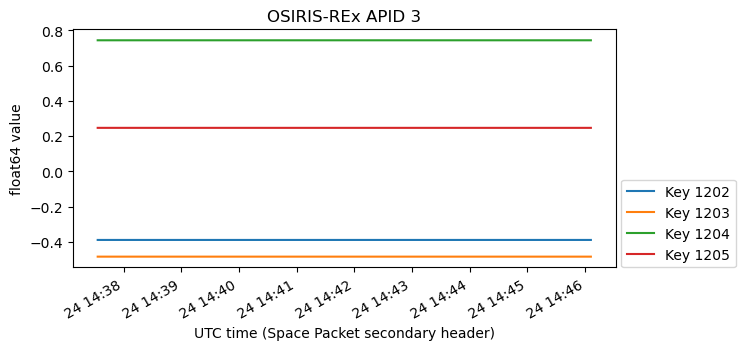

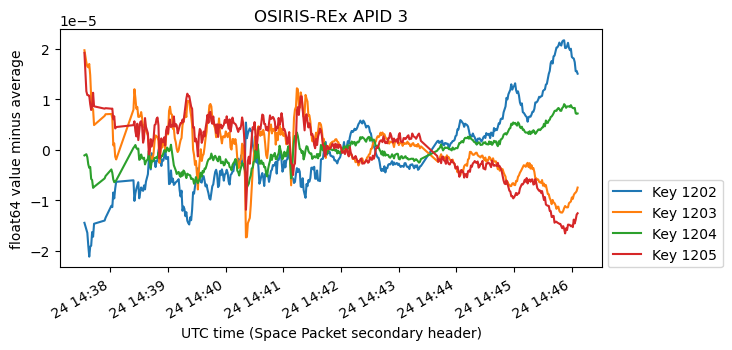

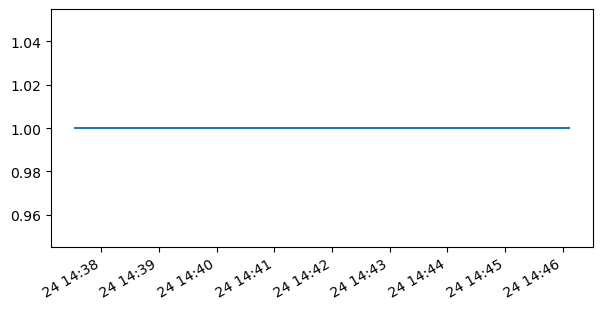

In [36]:
a = values_by_apid[3][1202].view('float64').byteswap()
b = values_by_apid[3][1203].view('float64').byteswap()
c = values_by_apid[3][1204].view('float64').byteswap()
d = values_by_apid[3][1205].view('float64').byteswap()
ta = timestamps_by_apid[3][1202]
tb = timestamps_by_apid[3][1203]
tc = timestamps_by_apid[3][1204]
td = timestamps_by_apid[3][1205]
plt.figure()
plt.plot(ta, a, label='Key 1202')
plt.plot(tb, b, label='Key 1203')
plt.plot(tc, c, label='Key 1204')
plt.plot(td, d, label='Key 1205')
plt.gcf().autofmt_xdate()
plt.legend(loc=(1.01, 0))
plt.title('OSIRIS-REx APID 3')
plt.ylabel('float64 value')
plt.xlabel('UTC time (Space Packet secondary header)')

plt.figure()
plt.plot(ta, a - np.average(a), label='Key 1202')
plt.plot(tb, b - np.average(b), label='Key 1203')
plt.plot(tc, c - np.average(c), label='Key 1204')
plt.plot(td, d - np.average(d), label='Key 1205')
plt.gcf().autofmt_xdate()
plt.legend(loc=(1.01, 0))
plt.title('OSIRIS-REx APID 3')
plt.ylabel('float64 value minus average')
plt.xlabel('UTC time (Space Packet secondary header)')

plt.figure()
plt.plot(ta, a**2 + b**2 + c**2 + d**2)
plt.gcf().autofmt_xdate()

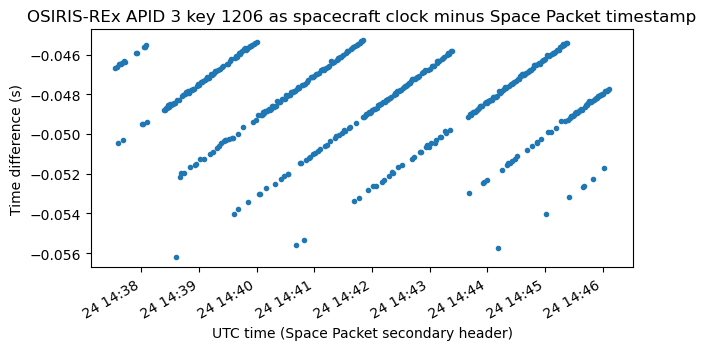

In [37]:
plt.plot(
    timestamps_by_apid[3][1206],
    (np.datetime64('2023-08-01T18:40:28.544')
 + np.timedelta64(1, 'ns') * (1e9 * (values_by_apid[3][1206].view('float64').byteswap() - 744187124))
 - timestamps_by_apid[3][1206]) / np.timedelta64(1, 's'), '.')
plt.title('OSIRIS-REx APID 3 key 1206 as spacecraft clock minus Space Packet timestamp')
plt.ylabel('Time difference (s)')
plt.xlabel('UTC time (Space Packet secondary header)')
plt.gcf().autofmt_xdate()

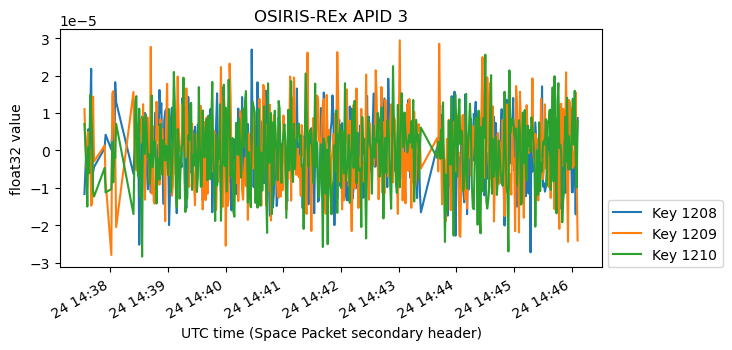

In [38]:
e = values_by_apid[3][1208].view('float32').byteswap()
f = values_by_apid[3][1209].view('float32').byteswap()
g = values_by_apid[3][1210].view('float32').byteswap()
te = timestamps_by_apid[3][1208]
tf = timestamps_by_apid[3][1209]
tg = timestamps_by_apid[3][1210]
plt.plot(te, e, label='Key 1208')
plt.plot(tf, f, label='Key 1209')
plt.plot(tg, g, label='Key 1210')
plt.gcf().autofmt_xdate()
plt.legend(loc=(1.01, 0))
plt.title('OSIRIS-REx APID 3')
plt.ylabel('float32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

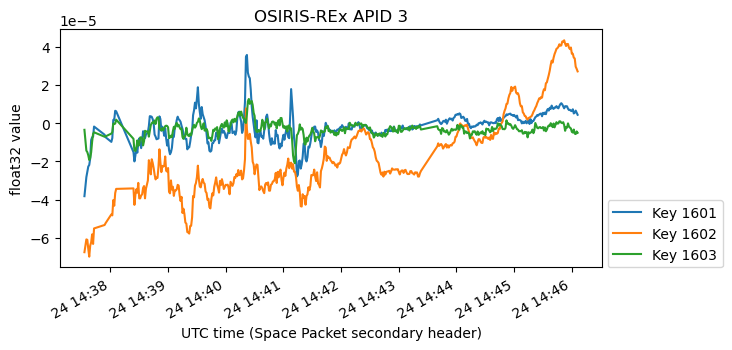

In [39]:
h = values_by_apid[3][1601].view('float32').byteswap()
i = values_by_apid[3][1602].view('float32').byteswap()
j = values_by_apid[3][1603].view('float32').byteswap()
th = timestamps_by_apid[3][1601]
ti = timestamps_by_apid[3][1602]
tj = timestamps_by_apid[3][1603]
plt.plot(th, h, label='Key 1601')
plt.plot(ti, i, label='Key 1602')
plt.plot(tj, j, label='Key 1603')
plt.gcf().autofmt_xdate()
plt.legend(loc=(1.01, 0))
plt.title('OSIRIS-REx APID 3')
plt.ylabel('float32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

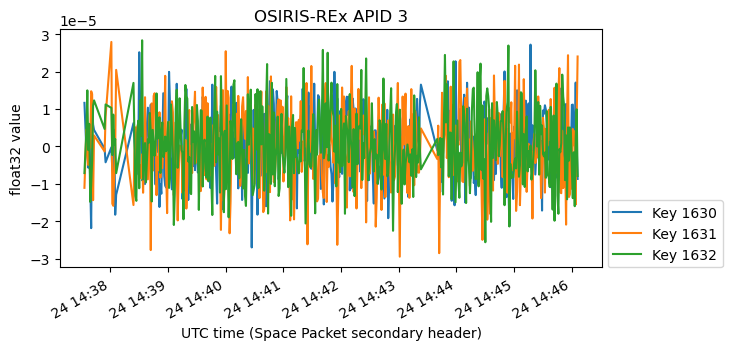

In [40]:
k = values_by_apid[3][1630].view('float32').byteswap()
l = values_by_apid[3][1631].view('float32').byteswap()
m = values_by_apid[3][1632].view('float32').byteswap()
tk = timestamps_by_apid[3][1630]
tl = timestamps_by_apid[3][1631]
tm = timestamps_by_apid[3][1632]
plt.plot(tk, k, label='Key 1630')
plt.plot(tl, l, label='Key 1631')
plt.plot(tm, m, label='Key 1632')
plt.gcf().autofmt_xdate()
plt.legend(loc=(1.01, 0))
plt.title('OSIRIS-REx APID 3')
plt.ylabel('float32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

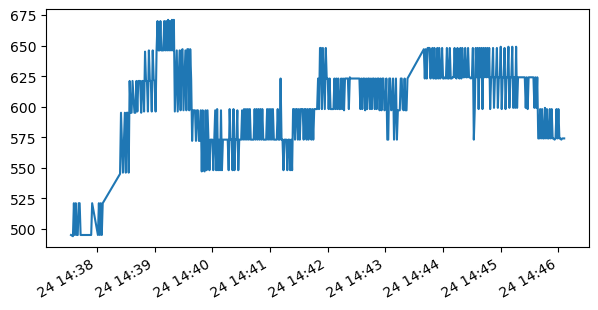

In [41]:
plt.plot(timestamps_by_apid[3][17231], values_by_apid[3][17231].view('int16').byteswap())
plt.gcf().autofmt_xdate()

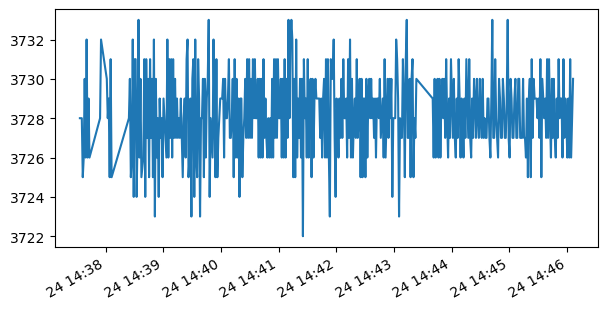

In [42]:
plt.plot(timestamps_by_apid[3][17237], values_by_apid[3][17237].view('int16').byteswap())
plt.gcf().autofmt_xdate()

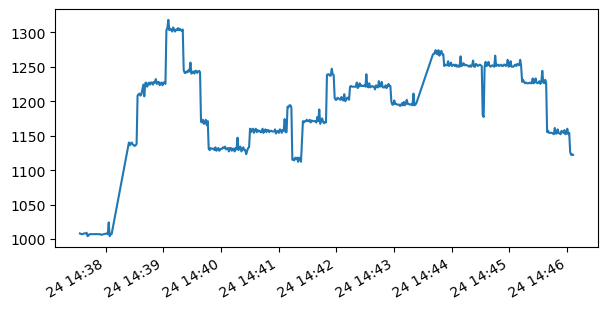

In [43]:
plt.plot(timestamps_by_apid[3][17251], values_by_apid[3][17251].view('int16').byteswap())
plt.gcf().autofmt_xdate()

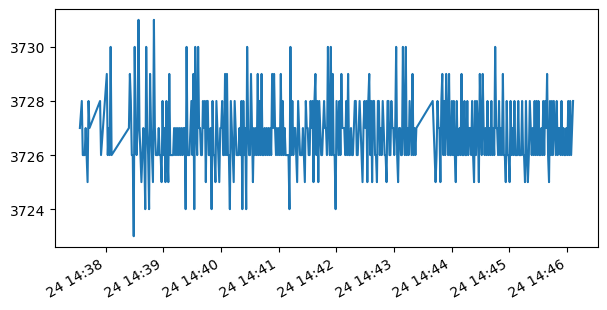

In [44]:
plt.plot(timestamps_by_apid[3][17257], values_by_apid[3][17257].view('int16').byteswap())
plt.gcf().autofmt_xdate()

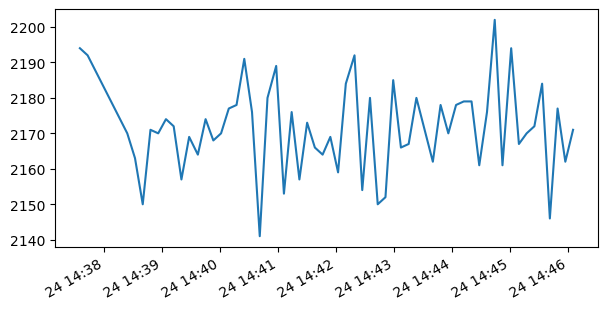

In [45]:
plt.plot(timestamps_by_apid[3][33880], values_by_apid[3][33880].view('int16').byteswap())
plt.gcf().autofmt_xdate()

## APID 4

APID 4 repeats some of the APID 3 values, at a lower temporal resolution.

In [46]:
{k: k in values_by_apid[4] for k in values_by_apid[3]}

{1202: True,
 1203: True,
 1204: True,
 1205: True,
 1206: True,
 1208: False,
 1209: False,
 1210: False,
 1601: False,
 1602: False,
 1603: False,
 1630: False,
 1631: False,
 1632: False,
 17231: False,
 17237: False,
 17251: False,
 17257: False,
 33880: False}

In [47]:
values_by_apid[4].keys() & values_by_apid[5].keys()

{1202, 1203, 1204, 1205, 1206}

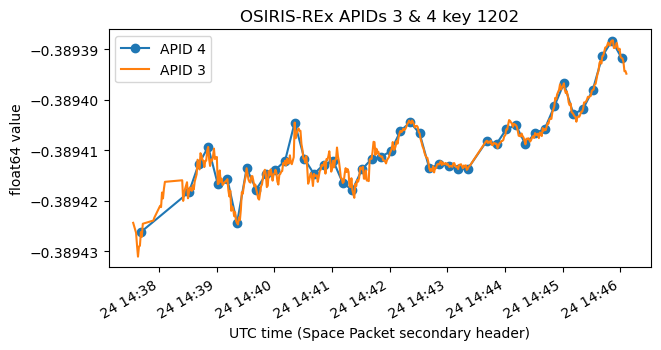

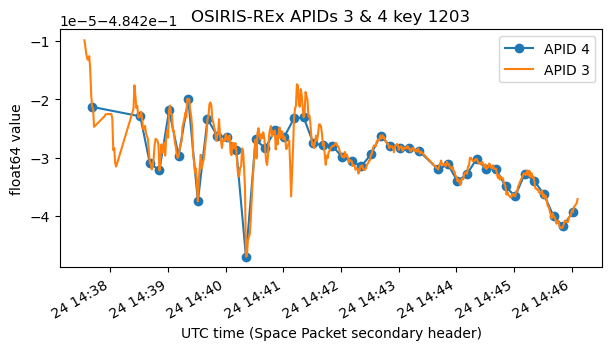

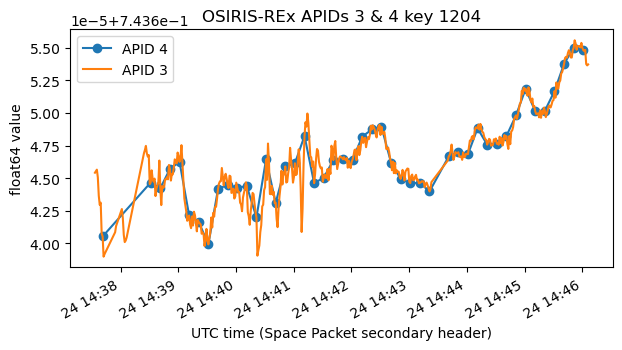

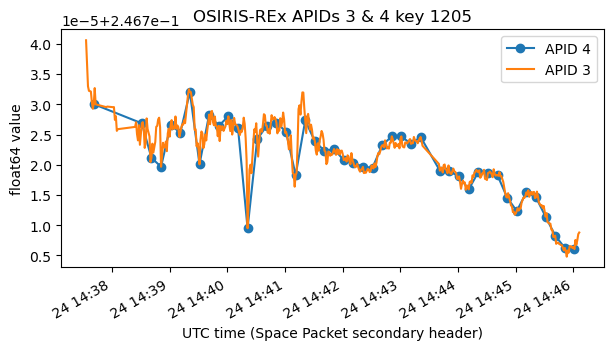

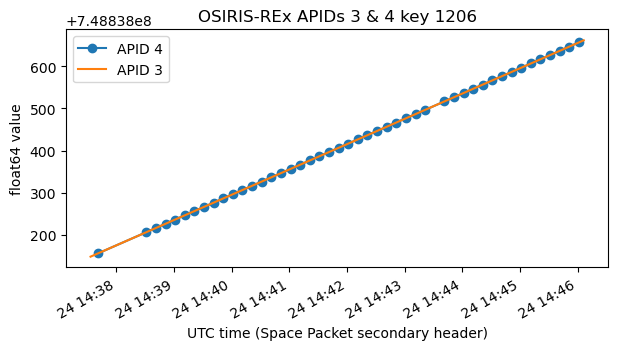

In [48]:
for k in range(1202, 1207):
    x = values_by_apid[4][k].view('float64').byteswap()
    tx = timestamps_by_apid[4][k]
    y = values_by_apid[3][k].view('float64').byteswap()
    ty = timestamps_by_apid[3][k]
    plt.figure()
    plt.plot(tx, x, 'o-', label='APID 4')
    plt.plot(ty, y, label='APID 3')
    plt.gcf().autofmt_xdate()
    plt.title(f'OSIRIS-REx APIDs 3 & 4 key {k}')
    plt.legend()
    plt.ylabel('float64 value')
    plt.xlabel('UTC time (Space Packet secondary header)');

In [49]:
sorted(values_by_apid[4])

[315,
 316,
 317,
 318,
 329,
 330,
 331,
 515,
 516,
 517,
 518,
 529,
 530,
 531,
 1202,
 1203,
 1204,
 1205,
 1206,
 1219,
 1220,
 1293,
 1294,
 1295,
 1297,
 1298,
 1299,
 1315,
 1316,
 1317,
 1318,
 1325,
 1326,
 1327,
 1328,
 1343,
 1344,
 1345,
 1346,
 1505,
 1506,
 1519,
 1520,
 1521,
 1522,
 1524,
 1525,
 1526,
 1527,
 1693,
 1694,
 1695,
 1699,
 1716,
 1717,
 1718,
 1757,
 1759,
 1760,
 1761,
 1923,
 1924,
 1926,
 1927,
 2068,
 2074,
 2080,
 2086,
 2105,
 2111,
 8492,
 8493,
 8494,
 8495,
 8496,
 8497,
 8498,
 8499,
 8500,
 8501,
 8502,
 8503,
 8504,
 8505,
 8524,
 8525,
 8526,
 8533,
 8534,
 8535,
 8536,
 8537,
 8692,
 8693,
 8694,
 8695,
 8696,
 8697,
 8698,
 8699,
 8700,
 8701,
 8703,
 8704,
 8705,
 8724,
 8725,
 8733,
 8734,
 8818,
 8858,
 8898,
 8938,
 12282,
 12283,
 12284,
 12285,
 12286,
 12287,
 16472,
 16473,
 16474,
 16475,
 16476,
 16477,
 16484,
 16485,
 16486,
 16488,
 16489,
 16490,
 16491,
 16493,
 16494,
 16495,
 16496,
 16497,
 16498,
 16503,
 16511,
 16513,

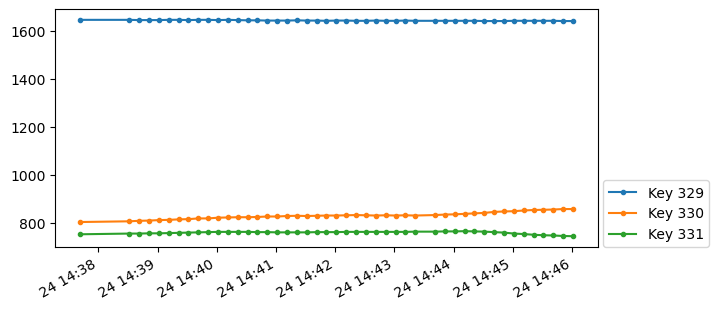

In [50]:
for j in range(329, 332):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

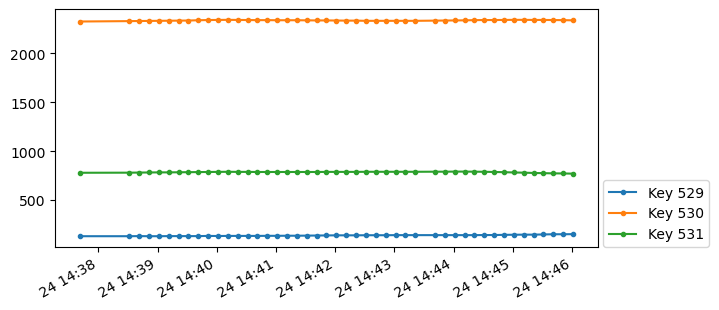

In [51]:
for j in range(529, 532):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

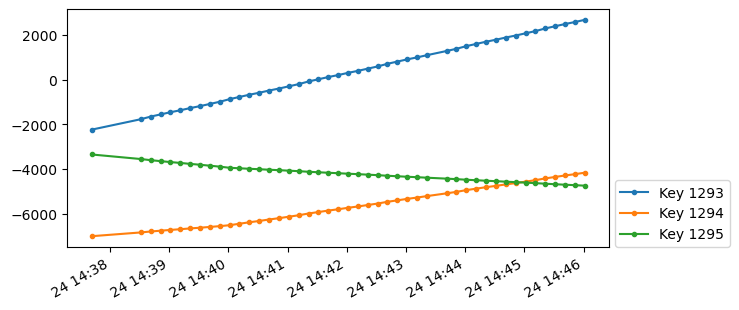

In [52]:
for j in range(1293, 1296):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('float32').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

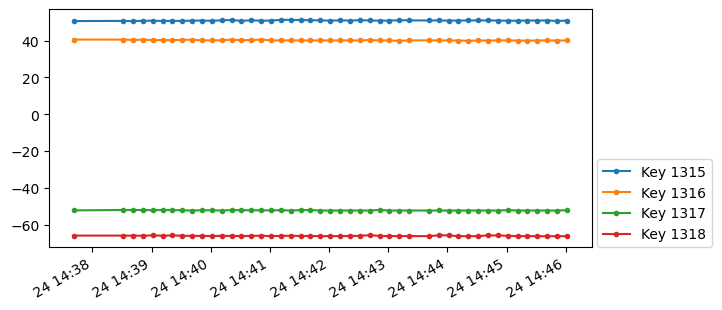

In [53]:
for j in range(1315, 1319):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('float32').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

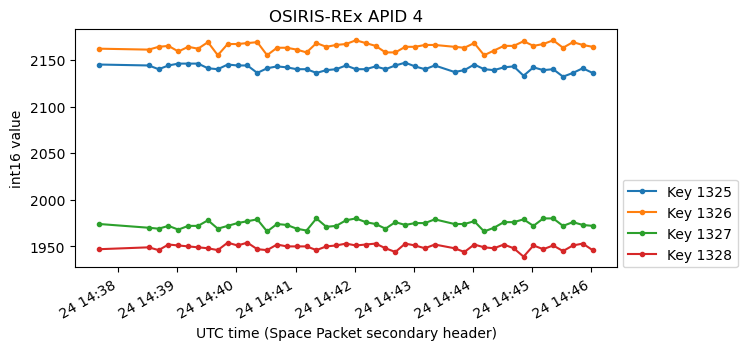

In [54]:
for j in range(1325, 1329):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 4')
plt.ylabel('int16 value')
plt.xlabel('UTC time (Space Packet secondary header)');

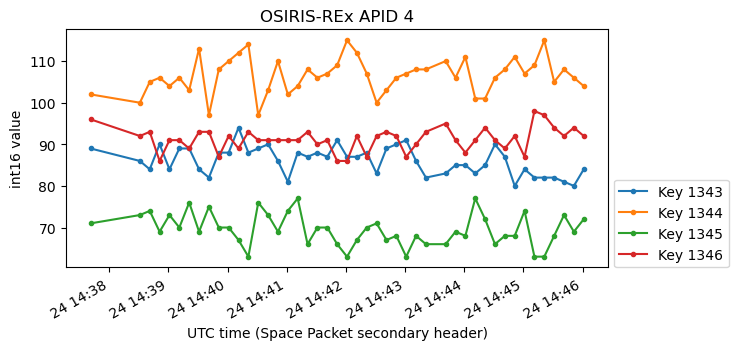

In [55]:
for j in range(1343, 1347):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 4')
plt.ylabel('int16 value')
plt.xlabel('UTC time (Space Packet secondary header)');

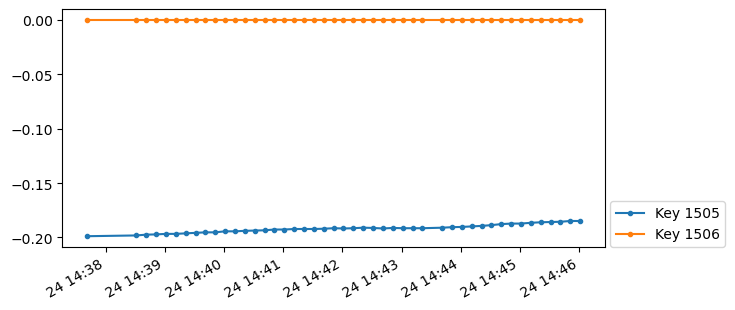

In [56]:
for j in range(1505, 1507):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('float32').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

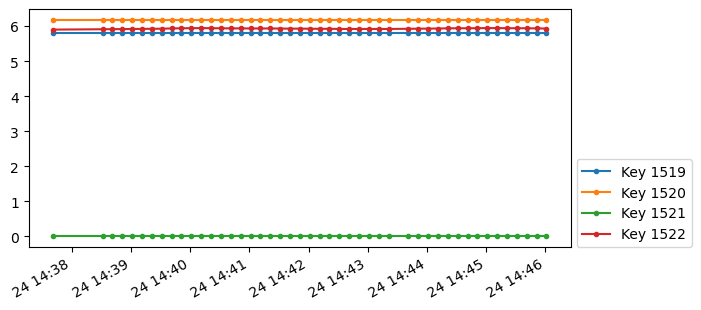

In [57]:
for j in range(1519, 1523):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('float32').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

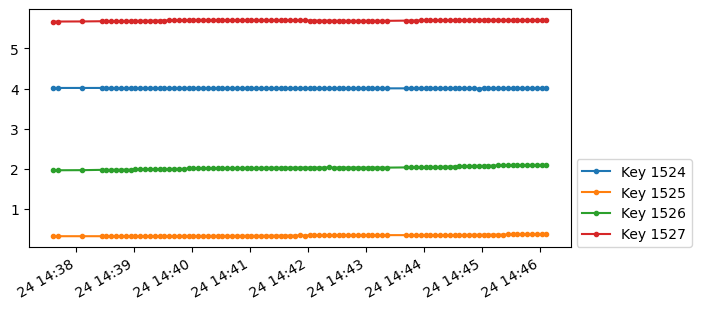

In [58]:
for j in range(1524, 1528):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('float32').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

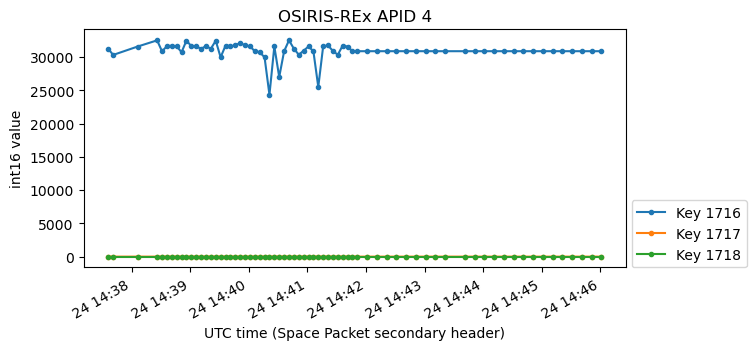

In [59]:
for j in range(1716, 1719):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 4')
plt.ylabel('int16 value')
plt.xlabel('UTC time (Space Packet secondary header)');

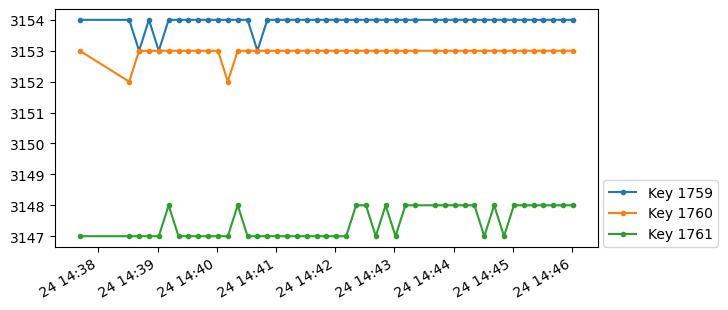

In [60]:
for j in range(1759, 1762):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

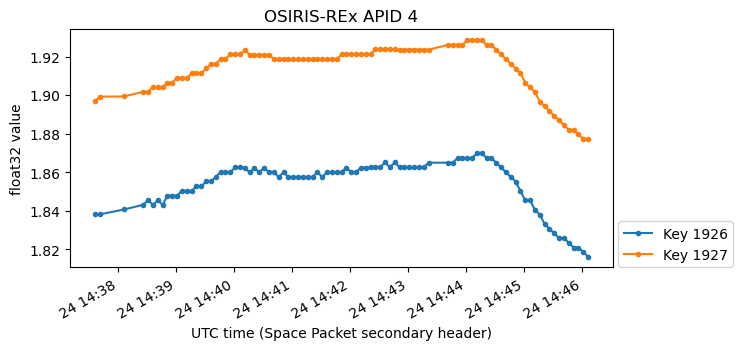

In [61]:
for j in range(1926, 1928):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('float32').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 4')
plt.ylabel('float32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

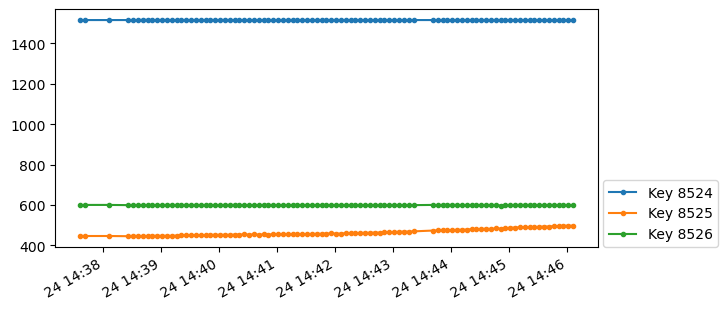

In [62]:
for j in range(8524, 8527):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

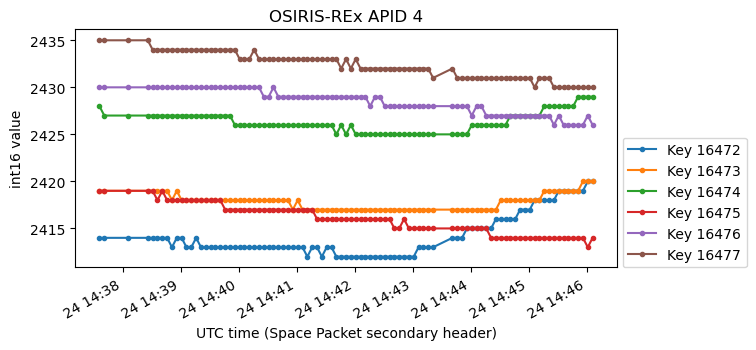

In [63]:
for j in range(16472, 16478):
    plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 4')
plt.ylabel('int16 value')
plt.xlabel('UTC time (Space Packet secondary header)');

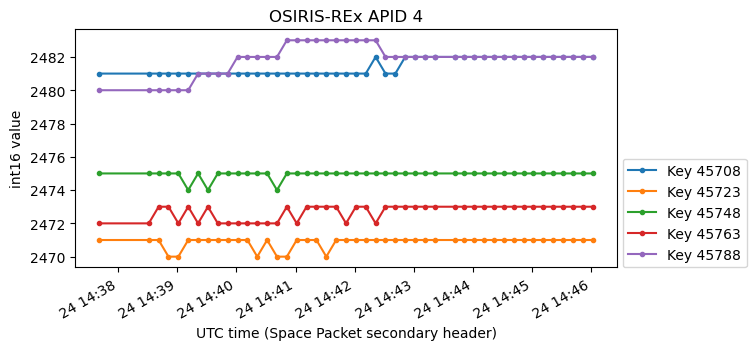

In [64]:
for j in range(45700, 45800):
    if j in values_by_apid[4]:
        plt.plot(timestamps_by_apid[4][j], values_by_apid[4][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 4')
plt.ylabel('int16 value')
plt.xlabel('UTC time (Space Packet secondary header)');

## APID 5

APID 5 repeats some of the APID 3 values at a much lower temporal resolution. There are other key-values that seem to correspond to ADCS quaternions, but with the opposite sign. There is an operational change at around 14:42 that freezes some values and changes their transmission rate (this is even visible in the raster map).

In [65]:
{k: k in values_by_apid[5] for k in values_by_apid[3]}

{1202: True,
 1203: True,
 1204: True,
 1205: True,
 1206: True,
 1208: False,
 1209: False,
 1210: False,
 1601: False,
 1602: False,
 1603: False,
 1630: False,
 1631: False,
 1632: False,
 17231: False,
 17237: False,
 17251: False,
 17257: False,
 33880: False}

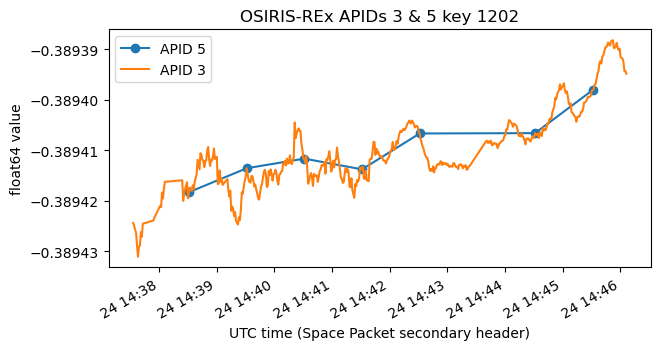

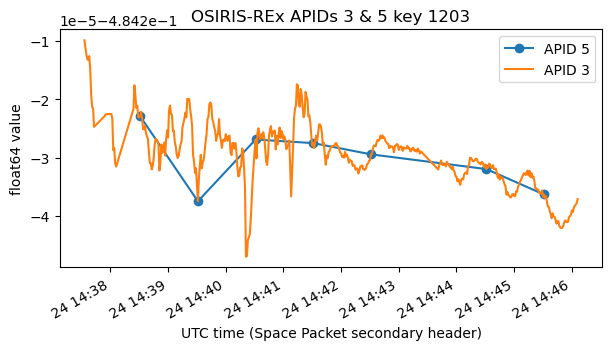

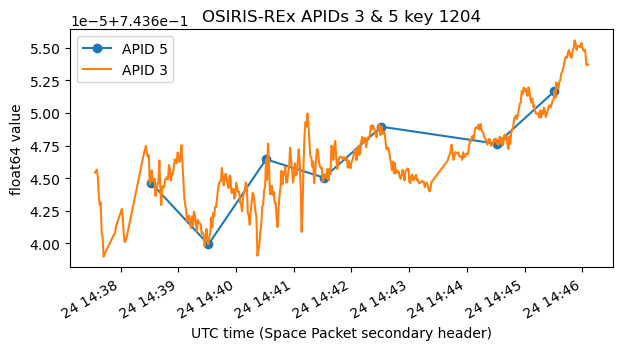

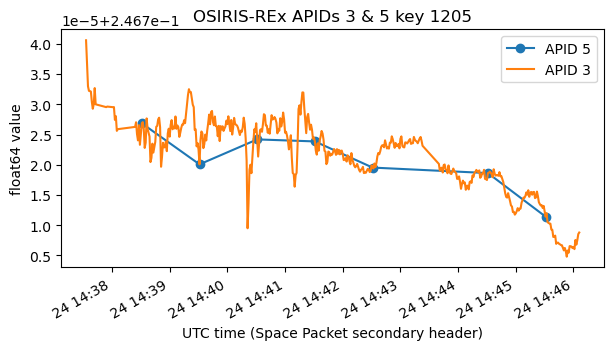

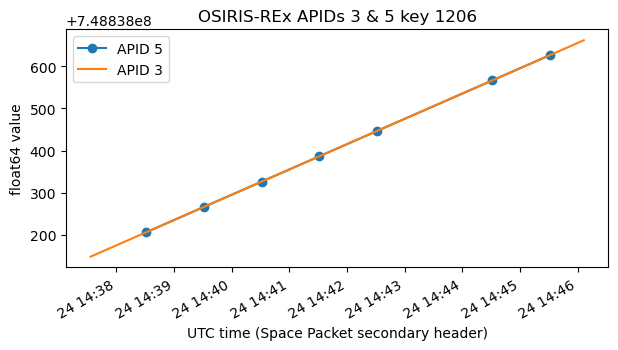

In [66]:
for k in range(1202, 1207):
    x = values_by_apid[5][k].view('float64').byteswap()
    tx = timestamps_by_apid[5][k]
    y = values_by_apid[3][k].view('float64').byteswap()
    ty = timestamps_by_apid[3][k]
    plt.figure()
    plt.plot(tx, x, 'o-', label='APID 5')
    plt.plot(ty, y, label='APID 3')
    plt.gcf().autofmt_xdate()
    plt.title(f'OSIRIS-REx APIDs 3 & 5 key {k}')
    plt.legend()
    plt.ylabel('float64 value')
    plt.xlabel('UTC time (Space Packet secondary header)');

In [67]:
{k: v.shape[0] for k, v in values_by_apid[5].items()}

{1001: 94,
 1002: 94,
 1003: 94,
 1007: 94,
 1008: 94,
 1009: 94,
 1010: 94,
 1011: 94,
 1012: 94,
 1013: 94,
 1014: 94,
 1015: 94,
 1016: 94,
 1017: 94,
 1018: 94,
 1019: 94,
 1020: 94,
 1021: 94,
 1024: 94,
 1180: 94,
 1626: 94,
 1627: 94,
 1628: 94,
 1667: 9,
 1668: 9,
 1669: 9,
 1670: 9,
 1671: 9,
 1696: 94,
 1697: 94,
 1702: 48,
 1703: 48,
 1704: 48,
 1705: 48,
 1706: 48,
 1720: 48,
 1721: 48,
 1722: 48,
 26: 22,
 20: 14,
 21: 7,
 22: 7,
 23: 7,
 24: 7,
 25: 7,
 27: 7,
 28: 7,
 29: 7,
 30: 7,
 31: 7,
 32: 7,
 33: 7,
 1004: 7,
 1005: 7,
 1006: 7,
 1022: 7,
 1023: 7,
 1025: 7,
 1026: 7,
 1027: 7,
 1028: 7,
 1029: 7,
 1030: 7,
 1031: 7,
 1032: 7,
 1033: 7,
 1034: 7,
 1035: 7,
 1036: 7,
 1037: 7,
 1038: 7,
 1039: 7,
 1040: 7,
 1041: 7,
 1042: 7,
 1043: 7,
 1044: 7,
 1045: 7,
 1046: 7,
 1047: 7,
 1048: 7,
 1049: 7,
 1050: 7,
 1051: 7,
 1052: 7,
 1053: 7,
 1054: 7,
 1055: 7,
 1056: 7,
 1057: 7,
 1058: 7,
 1059: 7,
 1060: 7,
 1061: 7,
 1062: 7,
 1063: 7,
 1064: 7,
 1065: 7,
 1066: 7,
 10

In [68]:
sorted({k: v.shape[0] for k, v in values_by_apid[5].items() if v.shape[0] >= 30})

[1001,
 1002,
 1003,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020,
 1021,
 1024,
 1180,
 1626,
 1627,
 1628,
 1696,
 1697,
 1702,
 1703,
 1704,
 1705,
 1706,
 1720,
 1721,
 1722]

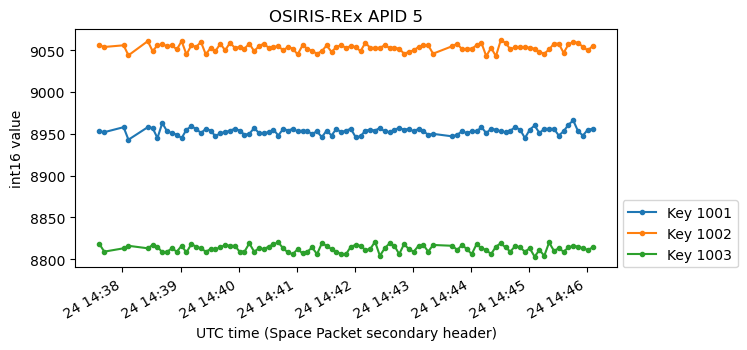

In [69]:
for j in range(1001, 1004):
    plt.plot(timestamps_by_apid[5][j], values_by_apid[5][j].view('int16').byteswap(), '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 5')
plt.ylabel('int16 value')
plt.xlabel('UTC time (Space Packet secondary header)');

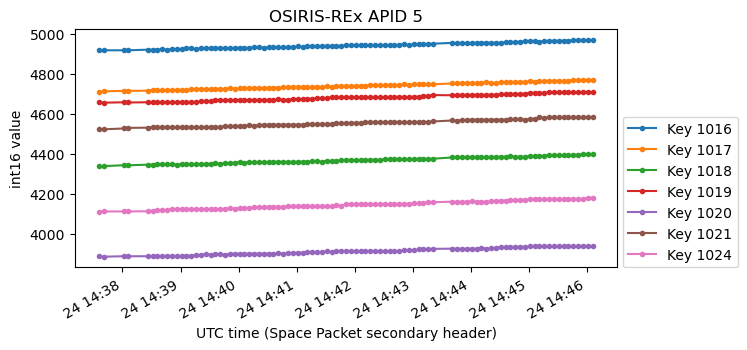

In [70]:
for j in list(range(1016, 1022)) + [1024]:
    x = values_by_apid[5][j].view('int16').byteswap()
    plt.plot(timestamps_by_apid[5][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 5')
plt.ylabel('int16 value')
plt.xlabel('UTC time (Space Packet secondary header)');

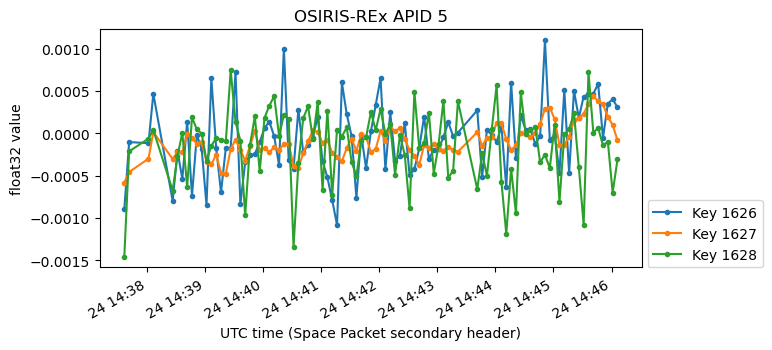

In [71]:
for j in range(1626, 1629):
    x = values_by_apid[5][j].view('float32').byteswap()
    plt.plot(timestamps_by_apid[5][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 5')
plt.ylabel('float32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

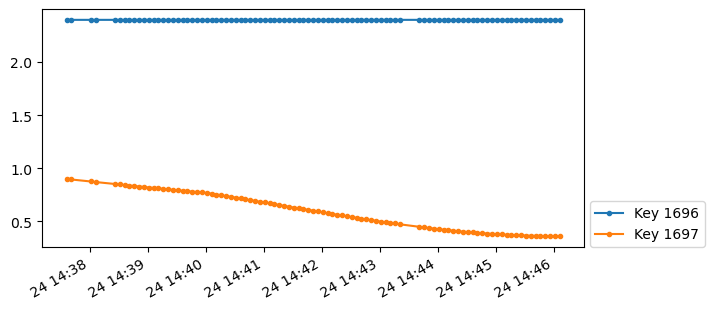

In [72]:
for j in range(1696, 1698):
    x = values_by_apid[5][j].view('float32').byteswap()
    plt.plot(timestamps_by_apid[5][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

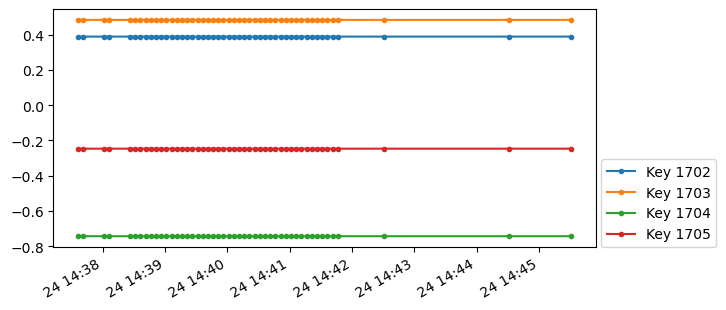

In [73]:
for j in range(1702, 1706):
    x = values_by_apid[5][j].view('float64').byteswap()
    plt.plot(timestamps_by_apid[5][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()

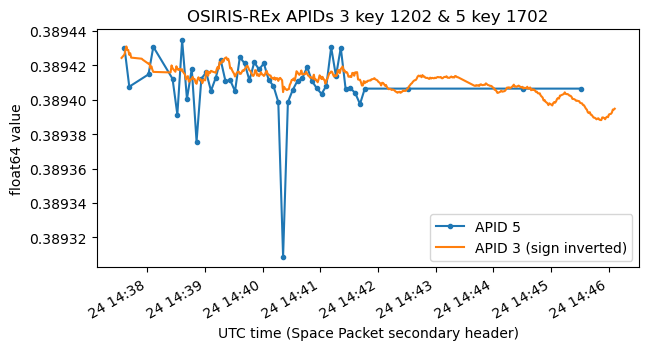

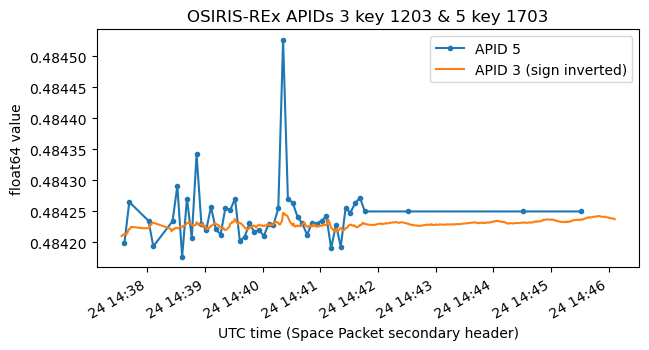

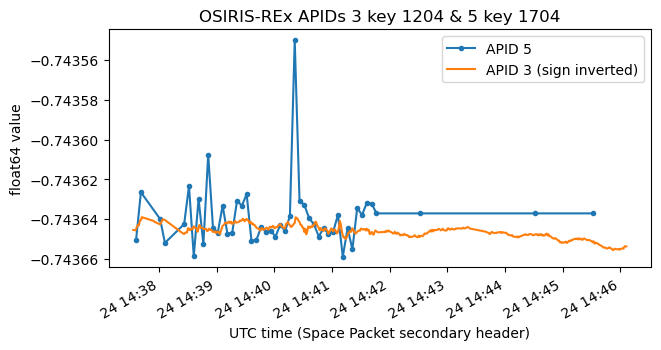

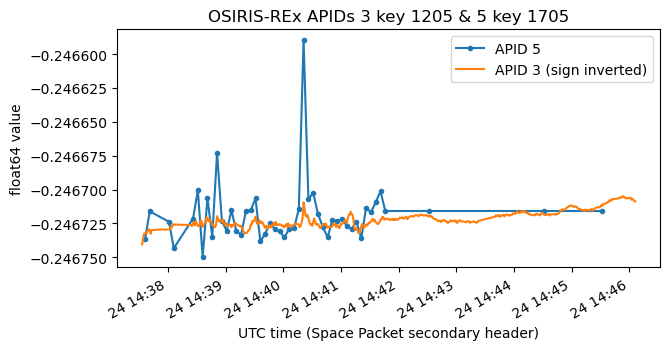

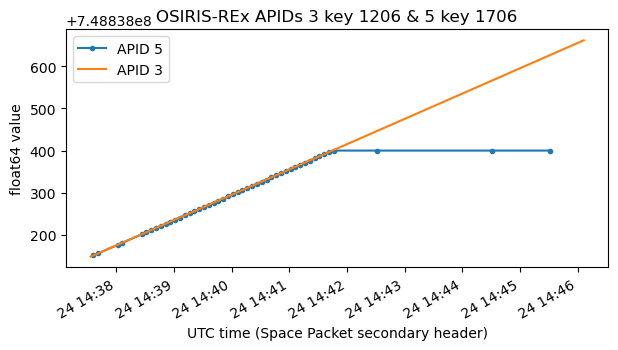

In [74]:
for j, k in zip(range(1702, 1707), range(1202, 1207)):
    plt.figure()
    x = values_by_apid[5][j].view('float64').byteswap()
    plt.plot(timestamps_by_apid[5][j], x, '.-', label='APID 5')
    y = values_by_apid[3][k].view('float64').byteswap()
    invert = k != 1206
    plt.plot(timestamps_by_apid[3][k], -y if invert else y, '-',
             label='APID 3 (sign inverted)' if invert else 'APID 3')
    plt.gcf().autofmt_xdate()
    plt.title(f'OSIRIS-REx APIDs 3 key {k} & 5 key {j}')
    plt.legend()
    plt.ylabel('float64 value')
    plt.xlabel('UTC time (Space Packet secondary header)');

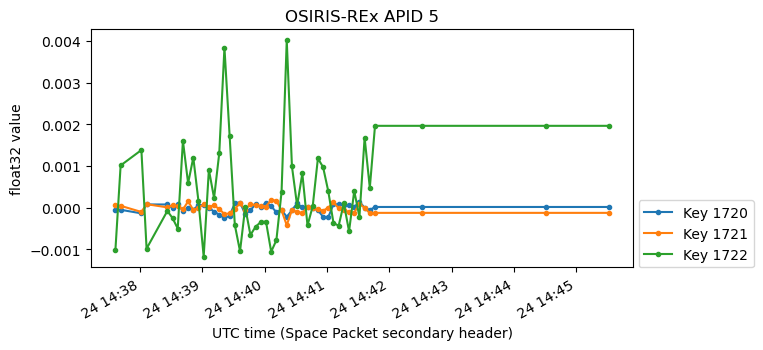

In [75]:
for j in range(1720, 1723):
    x = values_by_apid[5][j].view('float32').byteswap()
    plt.plot(timestamps_by_apid[5][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 5')
plt.ylabel('float32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

## APID 6

APID 6 contains a very large number of different keys. Most of these are only transmited once every 2.5 minutes, in a burst of several maximum length packets. The remaining keys are transmitted with high periodicity. This APID does not contain keys in common with the others. The same operational change as in APID 5 also has consecuences in this APID.

In [76]:
values_by_apid[3].keys() & values_by_apid[6].keys()

set()

In [77]:
values_by_apid[4].keys() & values_by_apid[6].keys()

set()

In [78]:
values_by_apid[5].keys() & values_by_apid[6].keys()

set()

In [79]:
len(values_by_apid[6].keys())

12578

In [80]:
sorted([k for k, v in values_by_apid[6].items() if v.shape[0] >= 20])

[1212,
 1213,
 1214,
 1216,
 1217,
 1218,
 1748,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 2641,
 2642,
 9716,
 9842,
 10060,
 10064,
 10077,
 10081,
 10389,
 12319,
 12320,
 12321,
 12322,
 12329,
 12330,
 12331,
 12332,
 12339,
 12340,
 12341,
 12342,
 12349,
 12350,
 12351,
 12352,
 13396,
 13402,
 14211,
 41415,
 41417,
 41418]

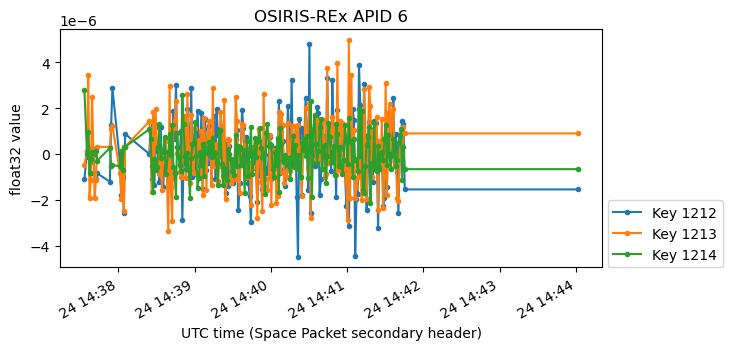

In [81]:
for j in range(1212, 1215):
    x = values_by_apid[6][j].view('float32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('float32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

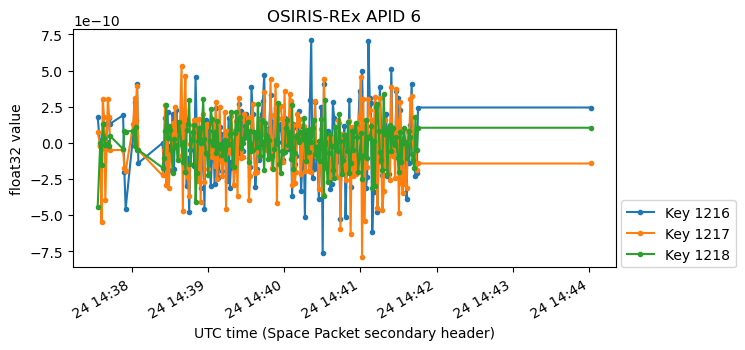

In [82]:
for j in range(1216, 1219):
    x = values_by_apid[6][j].view('float32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('float32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

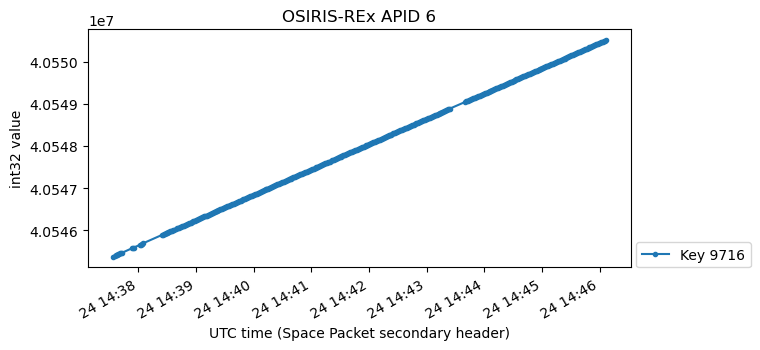

In [83]:
for j in [9716]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

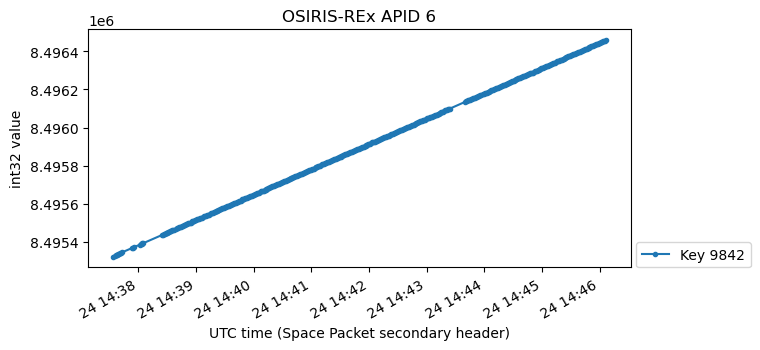

In [84]:
for j in [9842]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

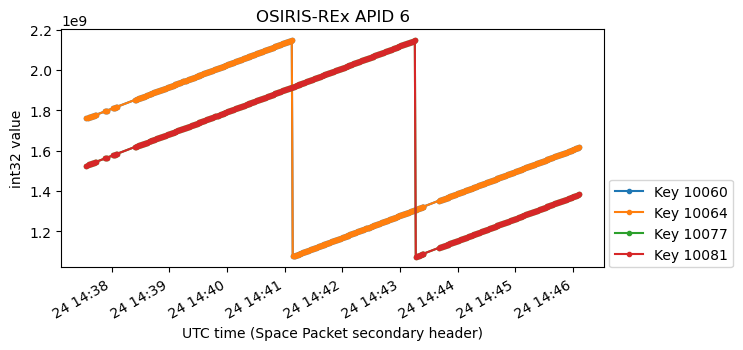

In [85]:
for j in [10060, 10064, 10077, 10081]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

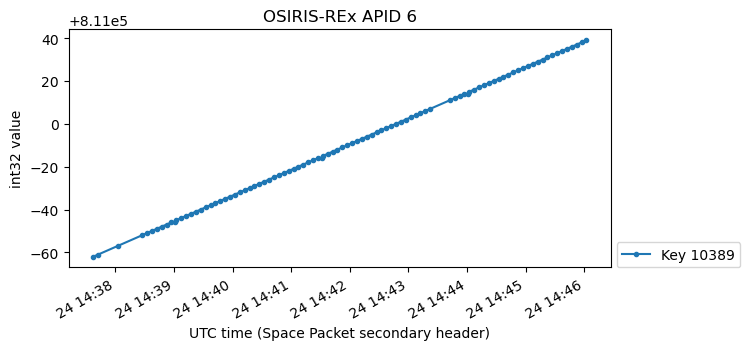

In [86]:
for j in [10389]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

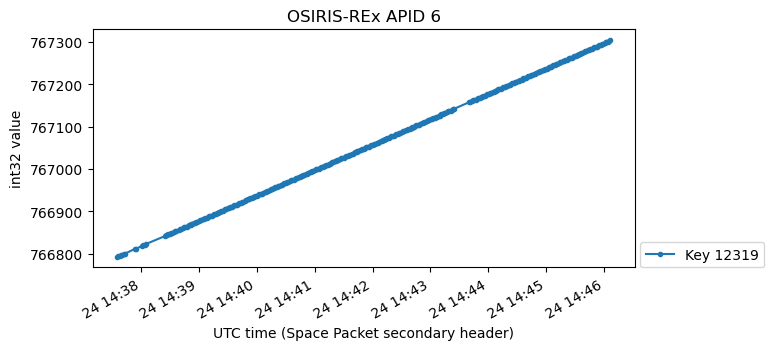

In [87]:
for j in [12319]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

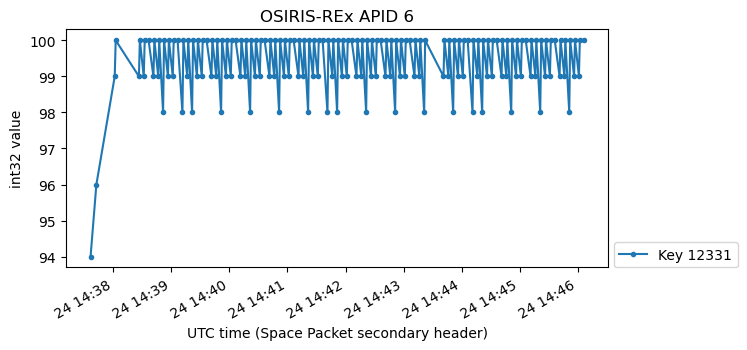

In [88]:
for j in [12331]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

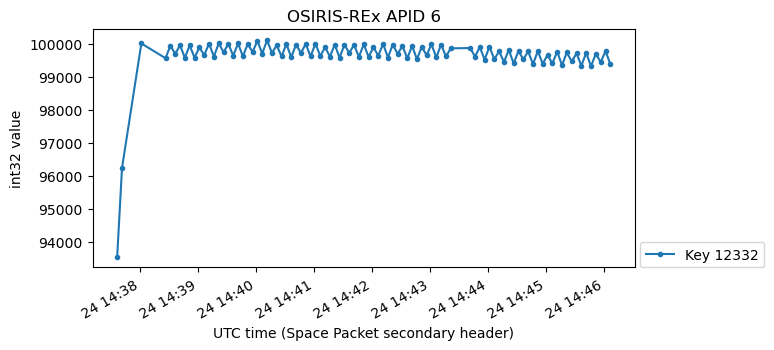

In [89]:
for j in [12332]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

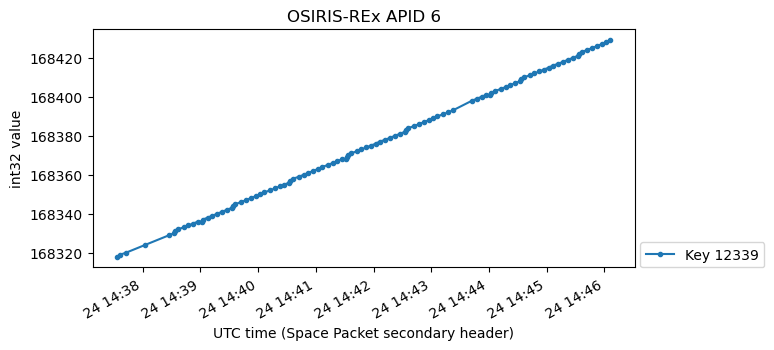

In [90]:
for j in [12339]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

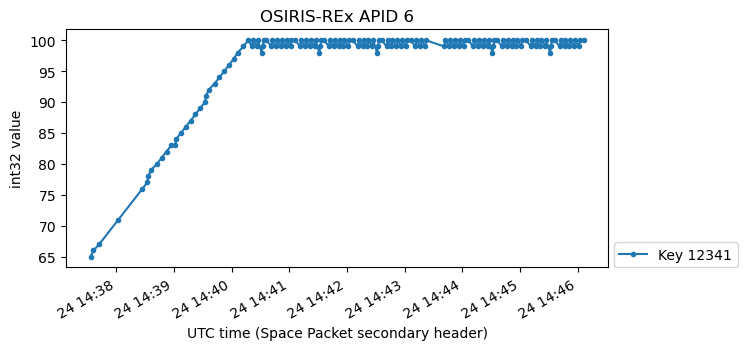

In [91]:
for j in [12341]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

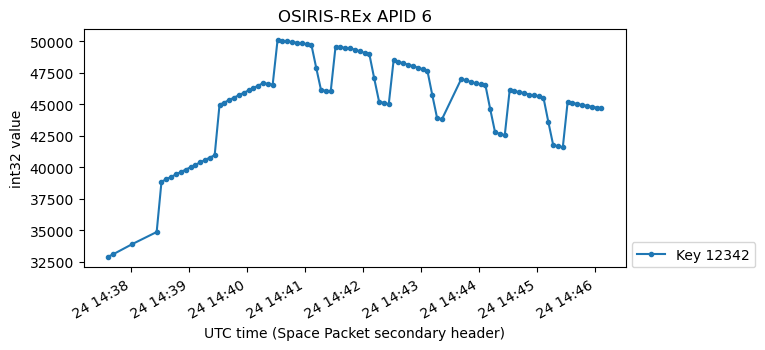

In [92]:
for j in [12342]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

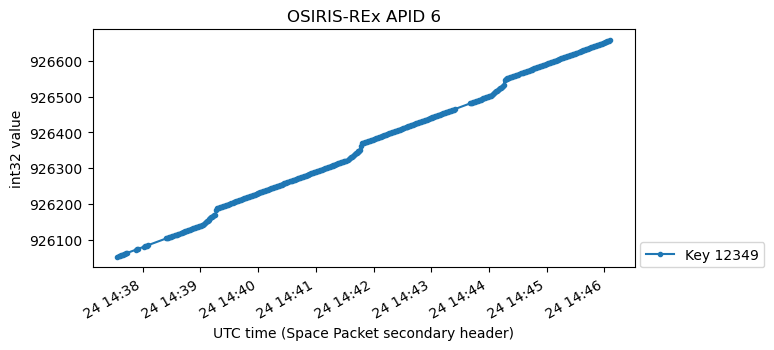

In [93]:
for j in [12349]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

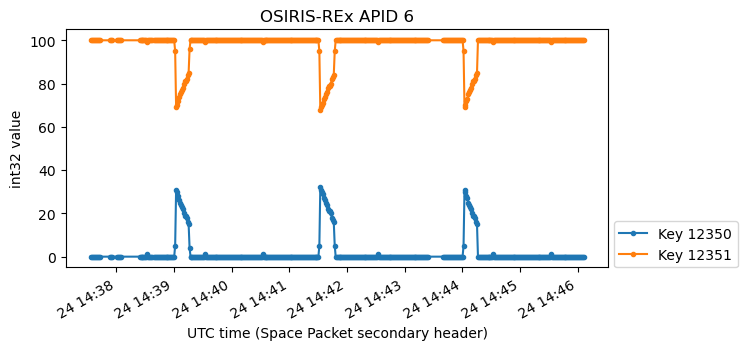

In [94]:
for j in range(12350, 12352):
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

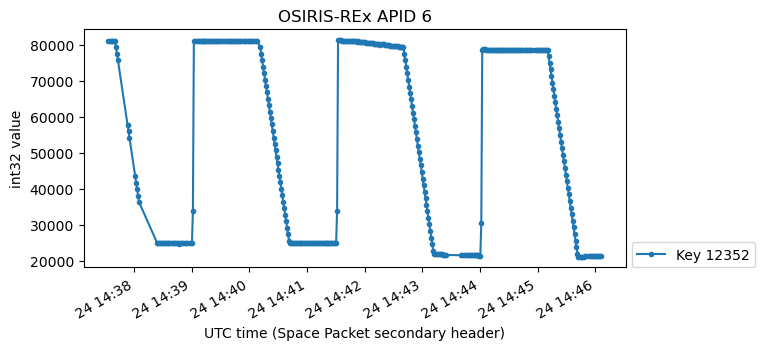

In [95]:
for j in [12352]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

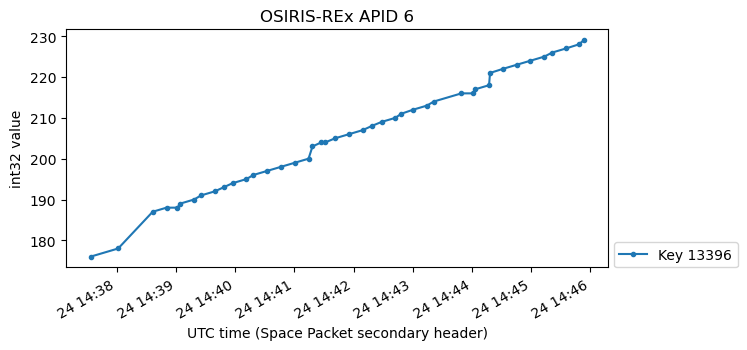

In [96]:
for j in [13396]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

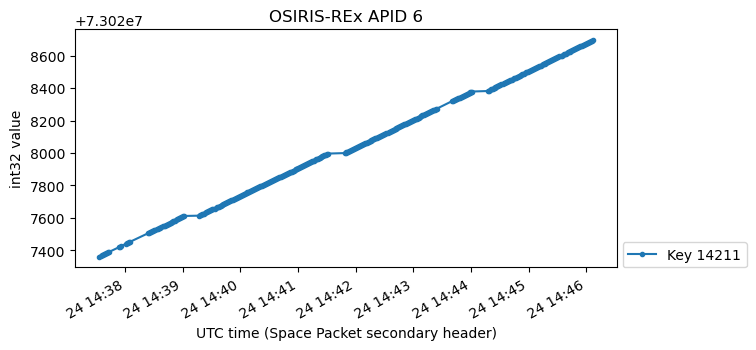

In [97]:
for j in [14211]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

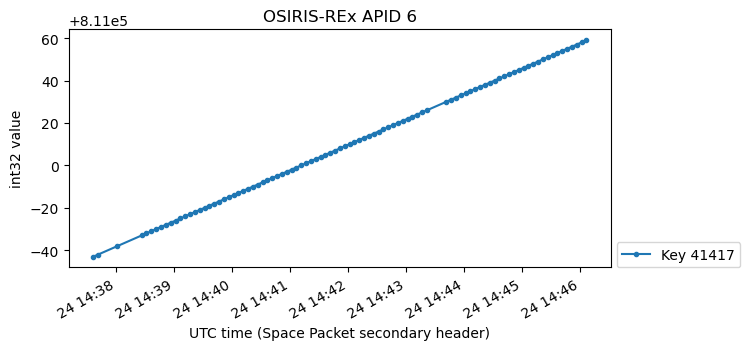

In [98]:
for j in [41417]:
    x = values_by_apid[6][j].view('int32').byteswap()
    plt.plot(timestamps_by_apid[6][j], x, '.-', label=f'Key {j}')
plt.legend(loc=(1.01, 0))
plt.gcf().autofmt_xdate()
plt.title('OSIRIS-REx APID 6')
plt.ylabel('int32 value')
plt.xlabel('UTC time (Space Packet secondary header)');

# VC 63

Idle frames contain a first header pointer of `0x7fe` (only idle data). The packet zone is filled with `0xaa` bytes.

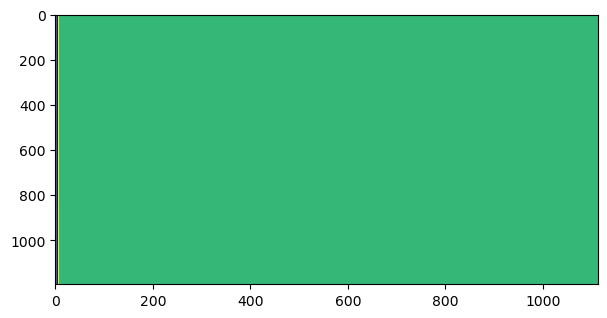

In [99]:
plt.imshow(frames[vcid == 63], aspect='auto', interpolation='none')

In [100]:
np.all(frames[vcid == 63][:, 6:8] == np.array([0x7, 0xfe]))

True

In [101]:
np.all(frames[vcid == 63][:, 8:] == 0xaa)

True